# Librerias iniciales

In [ ]:
pip install rasterio geopandas cartopy reverse_geocode pycountry_convert

# Descarga del conjunto de datos

In [ ]:
"""
This code will download the dataset ziped files from Google Drive to a local directory.
This script requires gdown: https://github.com/wkentaro/gdown

You can find the dataset here: https://drive.google.com/drive/folders/1IZ-Qebb-df2DFxfuSc2fXMRgd7493PDi

If you want to download only some of the regions, you can comment the undesired ones in the REGIONS constant.
Remember that the files will need more space when you uncomprees it, so watch out your disk space.

"""

import gdown
import os

# Set to false if you want to download the subset of samples
DOWNLOAD_FULL_DATASET = True

OUTPUT_DIR = './dataset/compressed/'

BASE_URL = 'https://drive.google.com/uc?id={}'

REGIONS = {
    'South_America': '1hnBUmYkvFYohTf9hTnKiyp2MXVevglK7', # About 13GB - https://drive.google.com/file/d/1hnBUmYkvFYohTf9hTnKiyp2MXVevglK7/view?usp=sharing
    'Oceania': '1xHYTICHKU0u3-kIrq-pM9k0YaeQt60Bt', # About 2GB https://drive.google.com/file/d/1xHYTICHKU0u3-kIrq-pM9k0YaeQt60Bt/view?usp=sharing
    'North_America1': '1BXRGldTdGGNeWDOFqNnmiNPuPQjweB2M', # About 14GB - https://drive.google.com/file/d/1BXRGldTdGGNeWDOFqNnmiNPuPQjweB2M/view?usp=sharing
    'North_America2': '1zW_pEIggJ5Li7uQX9XKMfHkcgL3kiUoi', # About 3GB - https://drive.google.com/file/d/1zW_pEIggJ5Li7uQX9XKMfHkcgL3kiUoi/view?usp=sharing
    'Africa': '1Ng3JwsjJPApshk8lJdGcsNHI52NaEMDX', # About 29GB - https://drive.google.com/file/d/1Ng3JwsjJPApshk8lJdGcsNHI52NaEMDX/view?usp=sharing
    'Europe': '1vANGtfuEdn0ZnILA6BYXW1_7jt8CU0gA', # About 15GB - https://drive.google.com/file/d/1vANGtfuEdn0ZnILA6BYXW1_7jt8CU0gA/view?usp=sharing
    'Asia1': '1xgOQkeQIswq3hLBhNzuNPTtsL4ZavuC3', # About 13GB - https://drive.google.com/file/d/1xgOQkeQIswq3hLBhNzuNPTtsL4ZavuC3/view?usp=sharing
    'Asia2': '1w_wv0_QZhnH9jO1ygJg6ssTrXupIbTHp', # About 9GB - https://drive.google.com/file/d/1w_wv0_QZhnH9jO1ygJg6ssTrXupIbTHp/view?usp=sharing
    'Asia3': '1heefSuPsnLZkNSJ2jTa4M-jGWo_9nAri', # About 16GB - https://drive.google.com/file/d/1heefSuPsnLZkNSJ2jTa4M-jGWo_9nAri/view?usp=sharing
    'Asia4': '1lyR6y6u8tSozfv3AQJ1PuUcdR0BU9yUk', # About 8GB - https://drive.google.com/file/d/1lyR6y6u8tSozfv3AQJ1PuUcdR0BU9yUk/view?usp=sharing
    'Asia5': '1Y1UysFrZ8AiugKvDpWI3nHcjo7-CQ4Dp', # Abouut 34GB - https://drive.google.com/file/d/1Y1UysFrZ8AiugKvDpWI3nHcjo7-CQ4Dp/view?usp=sharing
}

SUBSET_SAMPLES = {
    'samples' : '1gwQdhXrxCybcO16vem09DfW5fPadAA_p',
}

# Place to download the samples
# Is different from the Full Dataset to avoid mistakes running the others scripts
OUTPUT_SAMPLES = './dataset/samples/'

def download_file(file_id, output):
    url = BASE_URL.format(file_id)
    print('Downloading: {}'.format(url))
    gdown.download(url, output)


if __name__ == '__main__':

    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    if DOWNLOAD_FULL_DATASET:
        for region in REGIONS:

            zip_file_name = '{}.zip'.format(region)
            output = os.path.join(OUTPUT_DIR, zip_file_name)

            download_file(REGIONS[region], output)

    else:
        zip_file_name = 'samples.zip'
        output = os.path.join(OUTPUT_SAMPLES, zip_file_name)

        download_file(SUBSET_SAMPLES['samples'], output)


#Algoritmo de Clasificacion koppen geiger

In [ ]:
import geopandas as gpd
import rasterio
import os
import math
import re
from pyproj import Transformer

# Shapefile
koppen_file = "./koppen_geiger_0p1.tif"

# Función para extraer Path, Row y número de parche desde el nombre del archivo
def parse_filename(filename):
    """
    Extrae Path, Row y número de parche desde el nombre del archivo Landsat-8.
    Funciona para formatos como:
    LC08_L1TP_049066_20200812_20200813_01_RT_p00637.tif
    """
    match = re.search(r"LC08_(?:L1TP|L1GT|L1GS)_(\d{3})(\d{3})_\d{8}_\d{8}_\d{2}_\w+_p(\d{5})\.npy", filename)
    if match:
        path = int(match.group(1))
        row = int(match.group(2))
        patch_number = int(match.group(3))
        return path, row, patch_number
    return None

# Función principal para asignar clasificación y renombrar el archivo
def classify_and_rename_patch(filename, transform, crs):
    """
    Toma un archivo de parche, obtiene su clasificación Köppen-Geiger
    y renombra el archivo agregando "_X" donde X es la clasificación.
    """
    #Calcular coordenadas UTM del centro del parche
    x_utm, y_utm = rasterio.transform.xy(transform, 128, 128)  # Se usa el transform del PARCHE

    # Convertir UTM → Lat/Lon
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    lon_centro, lat_centro = transformer.transform(x_utm, y_utm)

    # Obtener la clasificación Köppen-Geiger
    koppen_class = None
    with rasterio.open(koppen_file) as dataset:
        row, col = dataset.index(lon_centro, lat_centro)
        koppen_class = dataset.read(1)[row, col]

    # Generar nuevo nombre con la clasificación Köppen-Geiger y el continente al que pertenece
    name, ext = os.path.splitext(filename)
    new_filename = f"{name}_{koppen_class}_{CURRENT_CONTINENT_CODE}{ext}"

    return new_filename

# Descompresion y Clasificacion Multiproceso

In [ ]:
# !rm -rf ./dataset/images/
# !rm -rf ./dataset/masks/
!rm -rf ./dataset/tmp/

In [ ]:
import zipfile
from glob import glob
import os
import shutil
import tempfile
import rasterio
from rasterio.io import MemoryFile
from multiprocessing import Pool
import numpy as np

# Set to false if you are uncompressing the samples provided in the GitHub repository
FULL_DATASET = True
MAX_PIXEL_VALUE = 65535

# This constants are used if you are unziping the *small* samples patches
IMAGES_PATH = './dataset/images/'
MASKS_PATH = './dataset/masks/'

# This constants are used to unzip the full dataset
FULL_DATASET_ZIPS_PATH = './dataset/compressed/' # where the continents zips are stored
FULL_DATASET_UNZIP_PATH = './dataset/' # where the continents zips will be unziped

def get_continent_from_zip(zip_path):
    """
    Extrae el código del continente desde el nombre del archivo ZIP.
    Ejemplo:
    - "./dataset/compressed/Asia4.zip" → "Asia"
    - "./dataset/compressed/SouthAmerica.zip" → "America"
    """
    filename = os.path.basename(zip_path)  # Obtiene "Asia4.zip"
    continent_name = os.path.splitext(filename)[0]  # Remueve ".zip"

    # Mapear nombres de continentes a códigos cortos
    continent_map = {
        "South_America": "America",
        "Oceania": "Oceania",
        "North_America1": "America",
        "North_America2": "America",
        "Africa": "Africa",
        "Europe": "Europe",
        "Asia1": "Asia",
        "Asia2": "Asia",
        "Asia3": "Asia",
        "Asia4": "Asia",
        "Asia5": "Asia"
    }

    return continent_map.get(continent_name, "XX")  # Retorna el código, o "XX" si no encuentra continente

from itertools import islice

def chunkify(lst, n):
    """Divide lst en n partes aproximadamente iguales"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def process_chunk(chunk):
    for zip_file in chunk:
        unzip_patches(zip_file)

def unzip_patches(patches_zip):
      output_dir = patches_output_dir
      with tempfile.TemporaryDirectory() as temp_output_dir:
          if patches_zip.endswith('masks_derivates.zip'):
              pass
              # with zipfile.ZipFile(patches_zip, 'r') as zip_ref:
              #     zip_ref.extractall(tmp_derivates)
              # derivate_patches = glob(os.path.join(tmp_derivates, '*.tif'))
              # for derivate_patch in derivate_patches:
              #     if '_voting_' in derivate_patch.lower():
              #         shutil.move(derivate_patch, derivate_patch.replace(tmp_derivates, voting_output_dir))
              #     elif '_intersection_' in derivate_patch.lower():
              #         shutil.move(derivate_patch, derivate_patch.replace(tmp_derivates, intersection_output_dir))
              # shutil.rmtree(tmp_derivates)

          elif patches_zip.endswith('masks.zip'):
              with zipfile.ZipFile(patches_zip, 'r') as zip_ref:
                    zip_ref.extractall(masks_output_dir)
          else:
              with zipfile.ZipFile(patches_zip, 'r') as zip_ref:
                    zip_ref.extractall(temp_output_dir)
          os.remove(patches_zip)

          # Procesar archivos TIFF
          tiff_files = glob(os.path.join(temp_output_dir, '*.tif'))
          process_tiff_files(tiff_files)

          reduced_numpy_files = glob(os.path.join(temp_output_dir, '*.npy'))
          for numpy_file in reduced_numpy_files:
              shutil.move(numpy_file, os.path.join(output_dir, os.path.basename(numpy_file)))
          numpz_files = glob(os.path.join(temp_output_dir, '*.npz'))
          for numpz_file in numpz_files:
              shutil.move(numpz_file, os.path.join(output_dir, os.path.basename(numpz_file)))

def process_tiff_files(tiff_files):
    """
    Procesa archivos TIFF, extrae las bandas 7, 6 , 2 y crea el Active Fire Index, guarda los datos directamente en archivos NumPy y la informacion
    de las coordenadas en archivos .npz.
    """
    for tiff_file in tiff_files:
        with rasterio.open(tiff_file) as src:
            # Verificar que el archivo tenga al menos 7 bandas
            if src.count < 7:
                continue
            # Leer las bandas seleccionadas
            img = src.read((7, 6, 2)).transpose((1, 2, 0))

            # Calculo del Active Fire Index
            ratio = np.divide(img[:,:,0], img[:,:,2], out=np.zeros_like(img[:,:,0], dtype=np.float32), where=(img[:,:,2] != 0))
            img = np.stack((img[:, :, 0], img[:, :, 1], img[:, :, 2], ratio), axis=-1)
            img = np.float32(img) / MAX_PIXEL_VALUE

            # Crear el nombre del archivo de salida en formato NumPy
            numpy_filename = tiff_file.replace('.tif', '.npy')
            numpy_filename = classify_and_rename_patch(numpy_filename, src.transform, src.crs)

            # Guardar el array en formato NumPy con Clasificacion koppen geiger
            np.save(numpy_filename, img)

            # Crear nuevo archivo para transform
            npz_filename = numpy_filename.replace('.npy', '_T.npz')

            # metadatos en .npz
            np.savez(npz_filename, transform=np.array(src.transform), crs=str(src.crs))

        # Eliminar el archivo TIFF original
        os.remove(tiff_file)

if FULL_DATASET:
    print('Unziping Full Dataset...')

    images_output = os.path.join(FULL_DATASET_UNZIP_PATH, 'images')
    patches_output_dir = os.path.join(images_output, 'patches')
    if not os.path.exists(patches_output_dir):
        os.makedirs(patches_output_dir)

    masks_output = os.path.join(FULL_DATASET_UNZIP_PATH, 'masks')
    masks_output_dir = os.path.join(masks_output, 'patches')
    if not os.path.exists(masks_output_dir):
        os.makedirs(masks_output_dir)

    voting_output_dir = os.path.join(FULL_DATASET_UNZIP_PATH, 'masks', 'voting')
    if not os.path.exists(voting_output_dir):
        os.makedirs(voting_output_dir)

    intersection_output_dir = os.path.join(FULL_DATASET_UNZIP_PATH, 'masks', 'intersection')
    if not os.path.exists(intersection_output_dir):
        os.makedirs(intersection_output_dir)

    zips_continents = glob(os.path.join(FULL_DATASET_ZIPS_PATH, '*.zip'))

    tmp_dir = os.path.join(FULL_DATASET_UNZIP_PATH, 'tmp')
    tmp_derivates = os.path.join(FULL_DATASET_UNZIP_PATH, 'tmp_derivates')

    print('Unzip images to {}'.format(patches_output_dir))
    print('Unzip masks to {}'.format(masks_output_dir))

    CURRENT_CONTINENT_CODE = None
    # Descomprime los zips de cada continente
    for zip_continent in zips_continents:
        CURRENT_CONTINENT_CODE = get_continent_from_zip(zip_continent)  # Asignar continente actual
        print('Unziping: {}'.format(zip_continent))
        print(CURRENT_CONTINENT_CODE)

        tmp_dir = os.path.join(FULL_DATASET_UNZIP_PATH, 'tmp')
        if not os.path.exists(tmp_dir):
            os.makedirs(tmp_dir)

        with zipfile.ZipFile(zip_continent, 'r') as zip_ref:
            zip_ref.extractall(tmp_dir)
            # Remove .zip file after unzip
            os.remove(zip_continent)

        patches_zips = glob(os.path.join(tmp_dir, '*.zip'))
        print('Num. of zips unpacked: {}'.format(len(patches_zips)))

        num_processes=!nproc
        num_processes=int(num_processes[0])
        chunks = list(chunkify(patches_zips, num_processes))

        # Descomprimir parches dentro del continente con hilos
        with Pool(processes=num_processes) as pool:
            pool.map(process_chunk, chunks)
    print('Deleted temp_dir')
    shutil.rmtree(tmp_dir)

    print('Done!')
print("Processing complete!")

In [ ]:
ls -1 dataset/images/patches | wc -l

292428


In [ ]:
ls -1 dataset/masks/patches | wc -l

287554


# Köppen-Geiger and WRS2 Shapefiles

Dimensiones: 3600 x 1800
Resolución: (0.1, 0.1)
Coordenadas del Esquina Superior Izquierda: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Coordenadas (19.43, -99.13) → Clase Köppen-Geiger: 12
Coordenadas (-15.78, -47.93) → Clase Köppen-Geiger: 3
Coordenadas (35.68, 139.76) → Clase Köppen-Geiger: 14
Coordenadas (-33.87, 151.21) → Clase Köppen-Geiger: 14


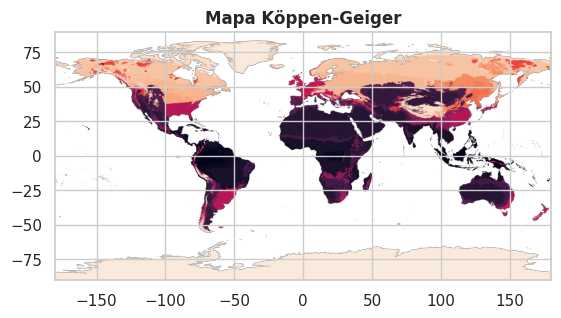

In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling

# Ruta del archivo Köppen-Geiger (ajustar según tu descarga)
koppen_file = "koppen_geiger_0p1.tif"

# Abrir el archivo raster
with rasterio.open(koppen_file) as dataset:
    # Mostrar información básica del raster
    print(f"Dimensiones: {dataset.width} x {dataset.height}")
    print(f"Resolución: {dataset.res}")  # Resolución en grados
    print(f"Coordenadas del Esquina Superior Izquierda: {dataset.bounds}")

    # Definir algunas coordenadas de prueba (Lat, Lon)
    coordenadas = [
        (19.43, -99.13),  # Ciudad de México
        (-15.78, -47.93),  # Brasilia
        (35.68, 139.76),  # Tokio
        (-33.87, 151.21)  # Sídney
    ]

    # Extraer clasificación climática de cada coordenada
    for lat, lon in coordenadas:
        # Convertir lat/lon a índices de matriz del raster
        row, col = dataset.index(lon, lat)
        # Obtener el valor del raster en esa posición
        koppen_class = dataset.read(1)[row, col]
        print(f"Coordenadas ({lat}, {lon}) → Clase Köppen-Geiger: {koppen_class}")

    # Muestra el raster en escala de grises
    show(dataset, title="Mapa Köppen-Geiger")

In [ ]:
import rasterio
import numpy as np

# Archivo Köppen-Geiger
koppen_file = "koppen_geiger_0p1.tif"

# Abrir el raster
with rasterio.open(koppen_file) as dataset:
    koppen_data = dataset.read(1)  # Leer la banda 1 con las clases climáticas

# Obtener valores únicos y contar frecuencia
unique_values, counts = np.unique(koppen_data, return_counts=True)

# Mostrar los valores y su frecuencia
print("📌 Clases Köppen-Geiger presentes en el raster:")
for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} píxeles")


📌 Clases Köppen-Geiger presentes en el raster:
Clase 0: 4268934 píxeles
Clase 1: 62064 píxeles
Clase 2: 42738 píxeles
Clase 3: 150591 píxeles
Clase 4: 200752 píxeles
Clase 5: 75185 píxeles
Clase 6: 74499 píxeles
Clase 7: 90464 píxeles
Clase 8: 15833 píxeles
Clase 9: 9967 píxeles
Clase 10: 18 píxeles
Clase 11: 36456 píxeles
Clase 12: 13728 píxeles
Clase 13: 20 píxeles
Clase 14: 59648 píxeles
Clase 15: 37240 píxeles
Clase 16: 1461 píxeles
Clase 17: 2341 píxeles
Clase 18: 6761 píxeles
Clase 19: 28161 píxeles
Clase 20: 200 píxeles
Clase 21: 11837 píxeles
Clase 22: 19978 píxeles
Clase 23: 37404 píxeles
Clase 24: 4615 píxeles
Clase 25: 19815 píxeles
Clase 26: 124660 píxeles
Clase 27: 266833 píxeles
Clase 28: 2338 píxeles
Clase 29: 149192 píxeles
Clase 30: 666267 píxeles


In [ ]:
print(wrs2.crs)

EPSG:4326


In [ ]:
import geopandas as gpd

# Ruta del archivo WRS-2
wrs2_shapefile = "WRS2_descending.shp"

# Cargar el shapefile con GeoPandas
wrs2 = gpd.read_file(wrs2_shapefile)

# Mostrar las primeras filas para entender la estructura
wrs2.head()

AREA  PERIMETER  PR_  PR_ID  RINGS_OK  RINGS_NOK  PATH  ROW MODE  \
0  15.74326   26.98611  1.0    1.0         1          0    13    1    D   
1  14.55366   25.84254  2.0    2.0         1          0    13    2    D   
2  13.37247   24.20303  3.0    3.0         1          0    13    3    D   
3  12.26691   22.40265  4.0    4.0         1          0    13    4    D   
4  11.26511   20.64284  5.0    5.0         1          0    13    5    D   

   SEQUENCE   WRSPR      PR ACQDayL7 ACQDayL8  \
0      2233  013001  013001        1        9   
1      2234  013002  013002        1        9   
2      2235  013003  013003        1        9   
3      2236  013004  013004        1        9   
4      2237  013005  013005        1        9   

                                            geometry  
0  POLYGON ((-10.80341 80.9888, -8.97407 80.342, ...  
1  POLYGON ((-29.2425 80.18681, -29.29593 80.1989...  
2  POLYGON ((-24.04206 79.12261, -23.78294 79.063...  
3  POLYGON ((-36.66813 77.46094, -40.05219 78.098...  
4  POLYGON ((-44.1121 76.93656, -44.1247 76.9388,...

In [ ]:
print(wrs2.sample(5))

           AREA  PERIMETER     PR_   PR_ID  RINGS_OK  RINGS_NOK  PATH  ROW  \
10579   2.93285    6.90135  3016.0  3016.0         1          0   217   40   
26033  14.55373   25.84273  1358.0  1358.0         1          0   104  118   
5288    2.97367    6.95566  3305.0  3305.0         1          0   228   81   
28294   4.24221    8.69432  2503.0  2503.0         1          0   159   23   
3856    6.47224   12.09544   509.0   509.0         1          0    43   13   

      MODE  SEQUENCE   WRSPR      PR ACQDayL7 ACQDayL8  \
10579    D     19880  217040  217040        6       14   
26033    D     50710  104118  104118       15        7   
5288     D      9257  228081  228081        3       11   
28294    D     55079  159023  159023       16        8   
3856     D      9933  043013  043013        3       11   

                                                geometry  
10579  POLYGON ((-32.93113 28.24928, -32.9313 28.2493...  
26033  POLYGON ((74.39119 -80.9888, 71.75198 -80.2733...  
5288 

# Mapa de distribucion de clases koppen geiger


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


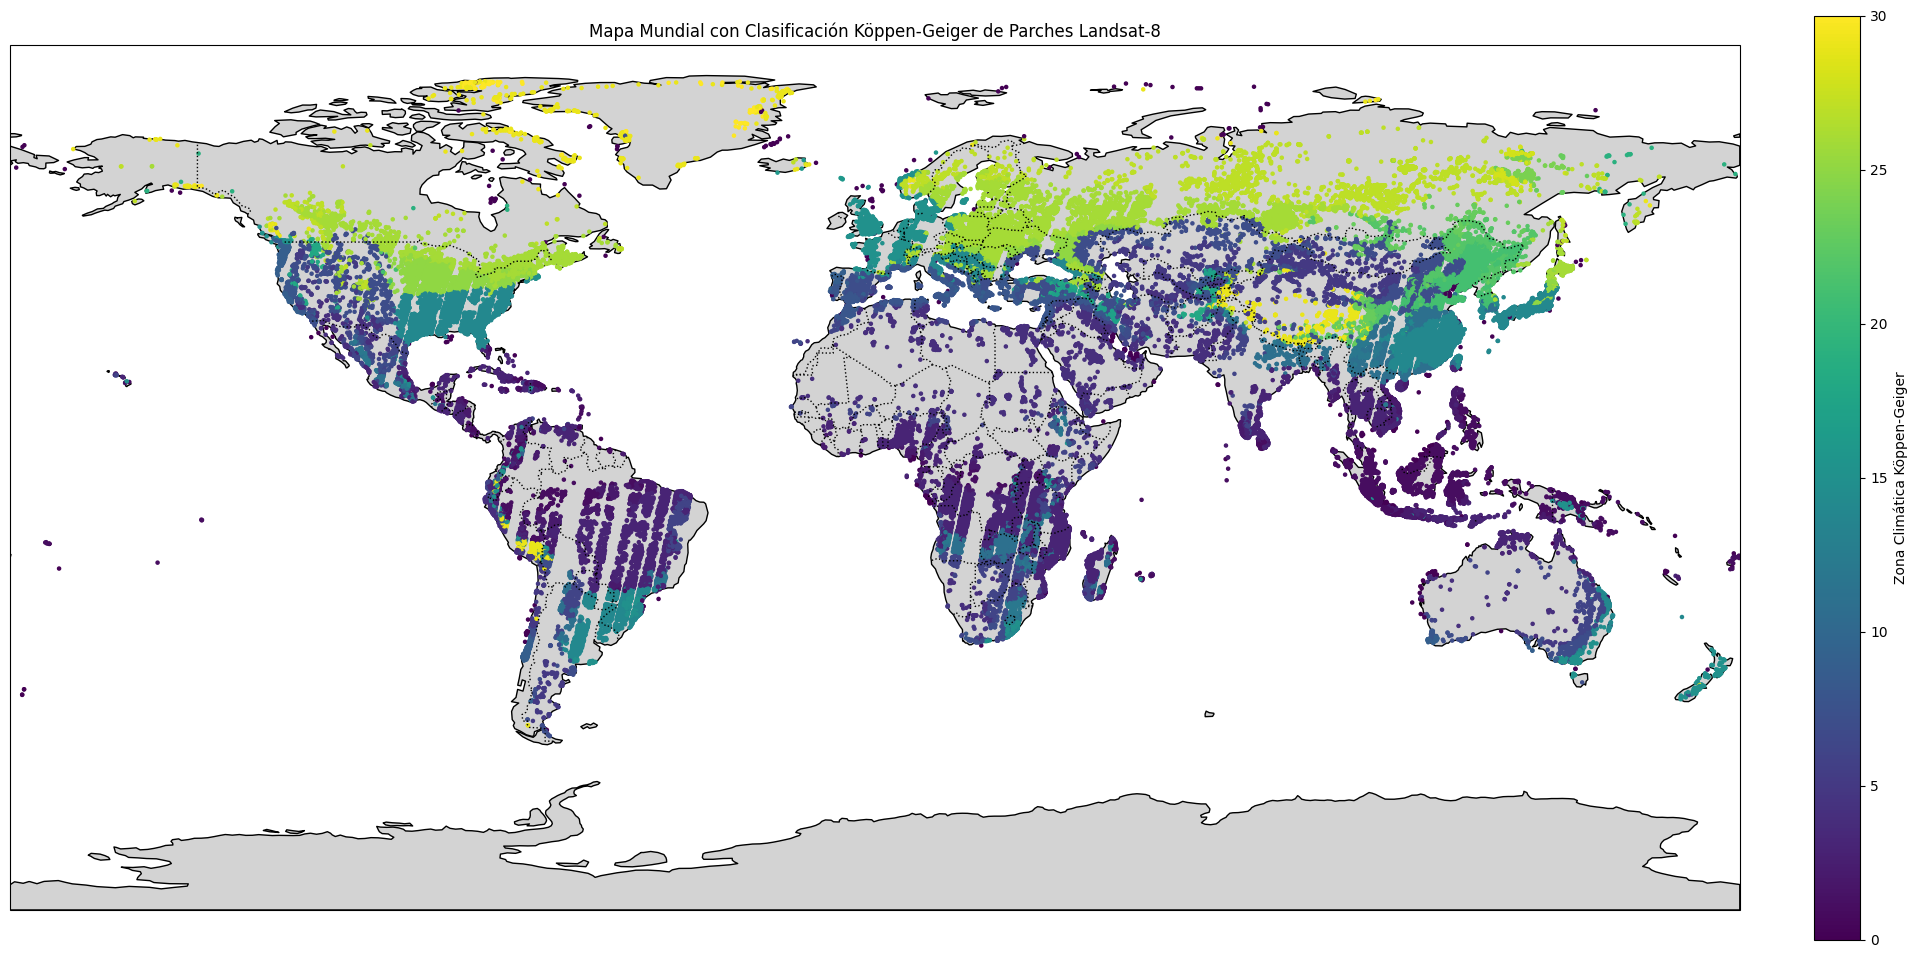

In [ ]:
import os
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio.transform import Affine
from rasterio.crs import CRS

# Archivos de entrada
input_folder = "./dataset/images/patches/"  # Ruta donde están los archivos de imágenes

# Función para extraer Path, Row y clasificación Köppen-Geiger del nombre del archivo
def parse_filename(filename):
    """
    Extrae Path, Row, número de parche, clasificación Köppen-Geiger y continente desde el nombre del archivo .npy.
    Ejemplo válido:
    LC08_L1TP_049066_20200812_20200813_01_RT_p00637_14_Africa.npy → path=49, row=66, patch=637, koppen_class=14, continent='Africa'
    """
    match = re.search(r"LC08_(?:L1TP|L1GT|L1GS)_(\d{3})(\d{3})_\d{8}_\d{8}_\d{2}_\w+_p(\d{5})_(\d+)_(\w+)\.npy", filename)
    if match:
        path = int(match.group(1))        # Path (ej. 049 → 49)
        row = int(match.group(2))         # Row (ej. 066 → 66)
        patch_number = int(match.group(3))  # Número de parche (ej. 00637 → 637)
        koppen_class = int(match.group(4))  # Clasificación Köppen-Geiger (ej. 14)
        continent = match.group(5)        # Continente (ej. 'SA')

        return path, row, patch_number, koppen_class, continent

    return None

def get_patch_center_coords(npy_file):
    """
    Obtiene las coordenadas geográficas (lat/lon) del centro de un parche.
    Lee `transform` y `crs` desde el archivo `{nombre}T.npz`.
    """
    # Construir el nombre del archivo de metadatos `T.npz`
    metadata_file = npy_file.replace(".npy", "_T.npz")

    # Cargar transformación y CRS desde `T.npz`
    with np.load(metadata_file, allow_pickle=True) as data:
        transform = data["transform"]
        crs = data["crs"].item()  # Convertir string EPSG
        #Convertir el array a Affine
        transform = Affine(*transform.flatten())
        crs = CRS.from_string(crs)

    # Convertir CRS a formato correcto
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

    # Calcular coordenadas UTM del centro del parche (128,128 es el centro del parche 256x256)
    x_utm, y_utm = rasterio.transform.xy(transform, 128, 128)

    # Convertir UTM → Lat/Lon
    lon_centro, lat_centro = transformer.transform(x_utm, y_utm)

    return lon_centro, lat_centro

# Recorrer la carpeta y obtener coordenadas y clasificaciones climáticas
patch_data = []

for filename in os.listdir(input_folder):
    if filename.endswith(".npy"):
        parsed = parse_filename(filename)
        if parsed:
            path, row, patch_number, koppen_class, continent = parsed
            npy_path = os.path.join(input_folder, filename)
            lon, lat = get_patch_center_coords(npy_path)
            patch_data.append((lon, lat, koppen_class))

# Crear el mapa mundial con puntos de datos
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Extraer coordenadas y clases Köppen para graficar
lons, lats, koppen_classes = zip(*patch_data)

# Usar la escala de colores "viridis" (dark blue → green → yellow)
sc = ax.scatter(lons, lats, c=koppen_classes, cmap="viridis", marker=".", s=20, edgecolor="face", transform=ccrs.PlateCarree())

# Agregar barra de color
cbar = plt.colorbar(sc, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Zona Climática Köppen-Geiger")

# Título del mapa
ax.set_title("Mapa Mundial con Clasificación Köppen-Geiger de Parches Landsat-8", fontsize=12)

# Mostrar el mapa
plt.savefig("Mapa Mundial con Clasificación Köppen-Geiger de Parches Landsat-8.png", dpi=300)
plt.show()

In [ ]:
df_errores = df[df["koppen_class"] == 0]

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar shapefile WRS-2
wrs2_shapefile = "WRS2_descending.shp"
wrs2 = gpd.read_file(wrs2_shapefile)

# Crear GeoDataFrame con los parches problemáticos
df_errores["geometry"] = df_errores.apply(lambda row: wrs2[(wrs2["PATH"] == row["path"]) & (wrs2["ROW"] == row["row"])].geometry.iloc[0], axis=1)
gdf_errores = gpd.GeoDataFrame(df_errores, geometry="geometry")

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
wrs2.plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.5)
gdf_errores.plot(ax=ax, color="red", markersize=10, label="Parches con Clase 0")
plt.title("Ubicación de los Parches con Köppen-Geiger = 0")
plt.legend()
plt.show()

KeyError: 'path'

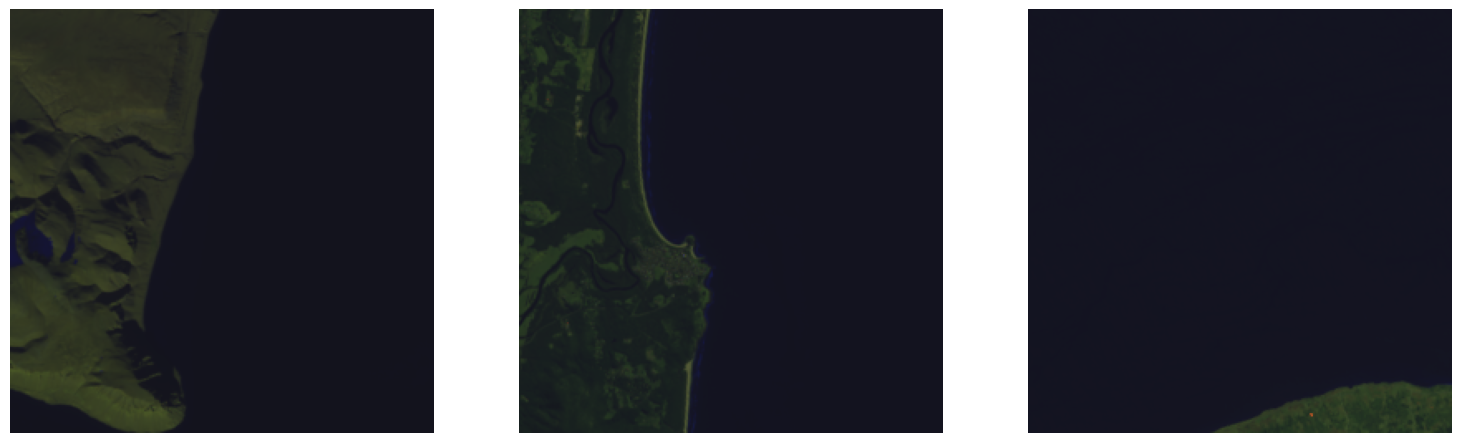

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Ruta de las imágenes en formato .npy
IMAGES_PATH = './dataset/images/patches/'

# Regex para extraer Número de Parche y Köppen-Geiger Class
regex = r"LC08_(?:L1TP|L1GT|L1GS)_(\d{3})(\d{3})_\d{8}_\d{8}_\d{2}_\w+_p(\d{5})_(\d+)_(\w+)\.npy"

# Obtener lista de imágenes
npy_files = glob(os.path.join(IMAGES_PATH, "*.npy"))

# Filtrar solo imágenes con Köppen-Geiger = 0
patches_koppen_0 = []

for npy_file in npy_files:
    filename = os.path.basename(npy_file)
    match = re.search(regex, filename)

    if match:
        koppen_class = int(match.group(4))  # Extraer la clase Köppen-Geiger
        if koppen_class == 0:
            patches_koppen_0.append(npy_file)

# Seleccionar algunas imágenes para visualizar (máximo 6)
num_patches = min(len(patches_koppen_0), 3)
selected_patches = np.random.choice(patches_koppen_0, num_patches, replace=False)

# Visualizar los Parches
fig, axes = plt.subplots(1, num_patches, figsize=(6.2*num_patches, 3*num_patches))

if num_patches == 1:
    axes = [axes]  # Asegurar que axes sea iterable

for ax, npy_file in zip(axes, selected_patches):
    # Cargar la imagen .npy
    img = np.load(npy_file)[:, :, :3]  # Solo usar las bandas SWIR1, SWIR2, BLUE

    # Normalizar la imagen entre 0 y 1
    #img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    # Mostrar imagen
    ax.imshow(img)
    #ax.set_title(os.path.basename(npy_file), fontsize=10)
    ax.axis("off")

#plt.suptitle("Parches con Köppen-Geiger = 0", fontsize=16)
plt.savefig("Parches_Class0.png", dpi=300, bbox_inches='tight')
plt.show()


# Dataset Dataframe

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import rasterio
from glob import glob
from multiprocessing import Pool, cpu_count
from tqdm import tqdm  # Barra de progreso

# Rutas de imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'
OUTPUT_FOLDER = './dataset/'

# Cargar todas las máscaras en un set para búsqueda rápida
all_masks = set(os.path.basename(mask) for mask in glob(os.path.join(MASKS_PATH, "*.tif")))

# Expresión Regular para extraer información del nombre del archivo `.npy`
filename_regex = re.compile(r"^(LC08_(?:L1TP|L1GT|L1GS)_\d{3}\d{3}_\d{8}_\d{8}_\d{2}_\w+_p\d{5})_(\d+)_(\w+)\.npy$")

# Función para extraer información del nombre del archivo
def parse_npy_filename(filename):
    match = filename_regex.match(filename)
    if match:
        base_name, koppen_class, continent = match.groups()
        return filename, base_name, int(koppen_class), continent
    return None

# Buscar máscaras TIFF basadas en la nomenclatura
def find_mask_files(base_name):
    masks_found = {}
    for algorithm in ["Kumar-Roy", "Murphy", "Schroeder"]:
        mask_filename = re.sub(r"(p\d{5})$", rf"{algorithm}_\1", base_name) + ".tif"
        if mask_filename in all_masks:
            masks_found[algorithm] = os.path.join(MASKS_PATH, mask_filename)
    return masks_found

# Obtener número de píxeles de incendio
def get_fire_pixels(mask_path):
    with rasterio.open(mask_path) as mask:
        return np.sum(mask.read(1) == 1)

# Procesar un archivo `.npy`
def process_npy_file(npy_file):
    filename = os.path.basename(npy_file)
    parsed = parse_npy_filename(filename)
    if not parsed:
        return None  # Ignorar archivos con nombres inválidos

    filename, base_name, koppen_class, continent = parsed
    mask_files = find_mask_files(base_name)

    if not mask_files:  # 📌 Si no hay máscaras, registrar con valores vacíos
        return [filename, koppen_class, continent, "None", "0"]

    algorithms, fire_pixels = [], []
    for algorithm, mask_path in mask_files.items():
        num_fire_pixels = get_fire_pixels(mask_path)
        algorithms.append(algorithm)
        fire_pixels.append(str(num_fire_pixels))

    return [filename, koppen_class, continent, ";".join(algorithms), ";".join(fire_pixels)]

# Obtener lista de archivos `.npy`
npy_files = glob(os.path.join(IMAGES_PATH, "*.npy"))
num_processes=!nproc
num_processes=int(num_processes[0])

# Procesar en paralelo con barra de progreso
with Pool(processes=num_processes) as pool:
    results = list(tqdm(pool.imap_unordered(process_npy_file, npy_files), total=len(npy_files), desc="Procesando archivos con "+str(num_processes)+" hilos", unit="archivo"))

# Filtrar resultados nulos
results = [r for r in results if r is not None]

# Crear DataFrame y guardar CSV
df = pd.DataFrame.from_records(results, columns=["filename", "koppen_class", "continent", "algorithms", "fire_pixels"])
df.to_csv(os.path.join(OUTPUT_FOLDER, "dataset_analysis_with_algorithms.csv"), index=False)

print("Dataset generado y guardado en 'dataset_analysis_with_algorithms.csv'")

Procesando archivos con 12 hilos: 100%|██████████| 146214/146214 [05:32<00:00, 439.10archivo/s]


Dataset generado y guardado en 'dataset_analysis_with_algorithms.csv'


## Verificacion de coherencia

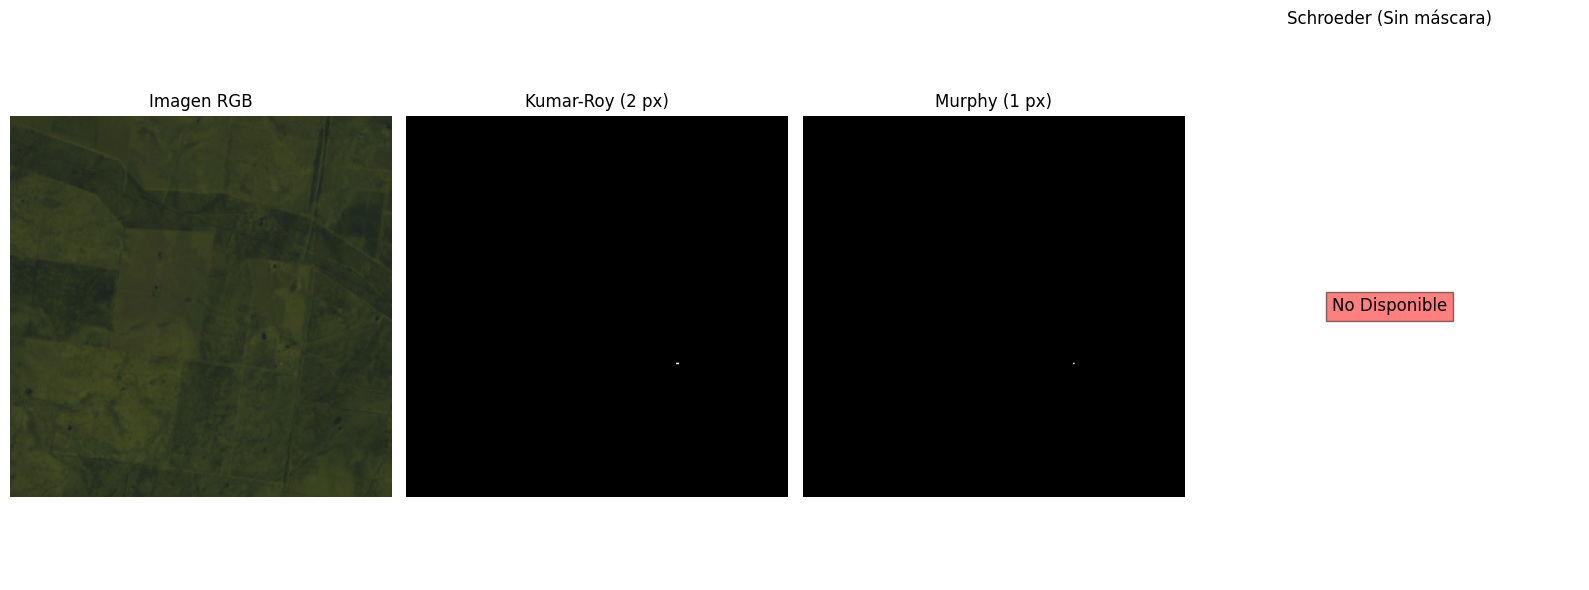

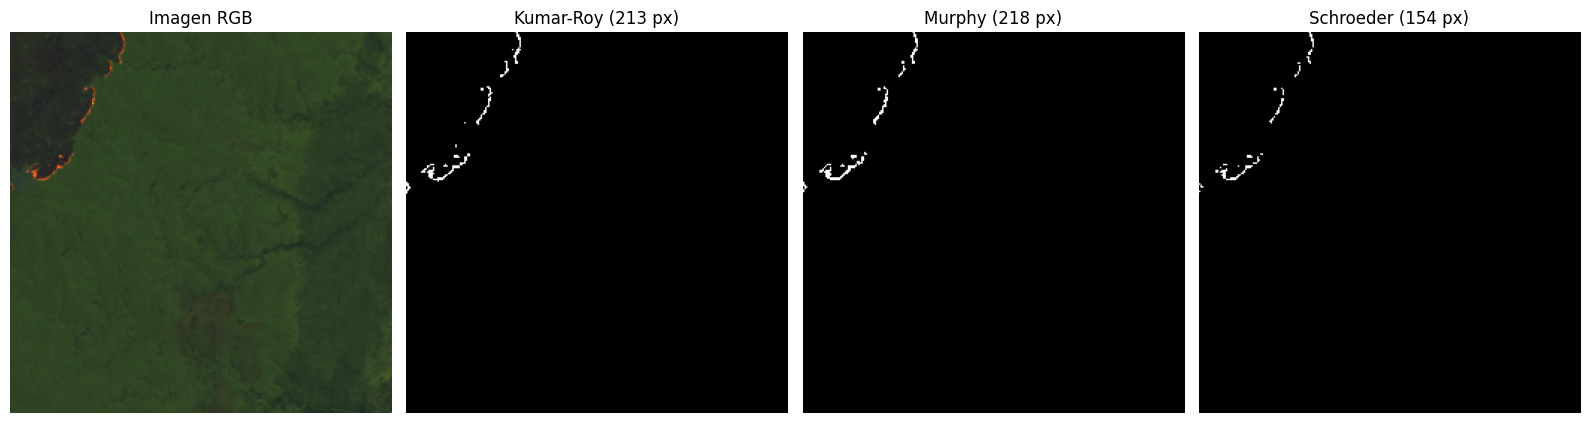

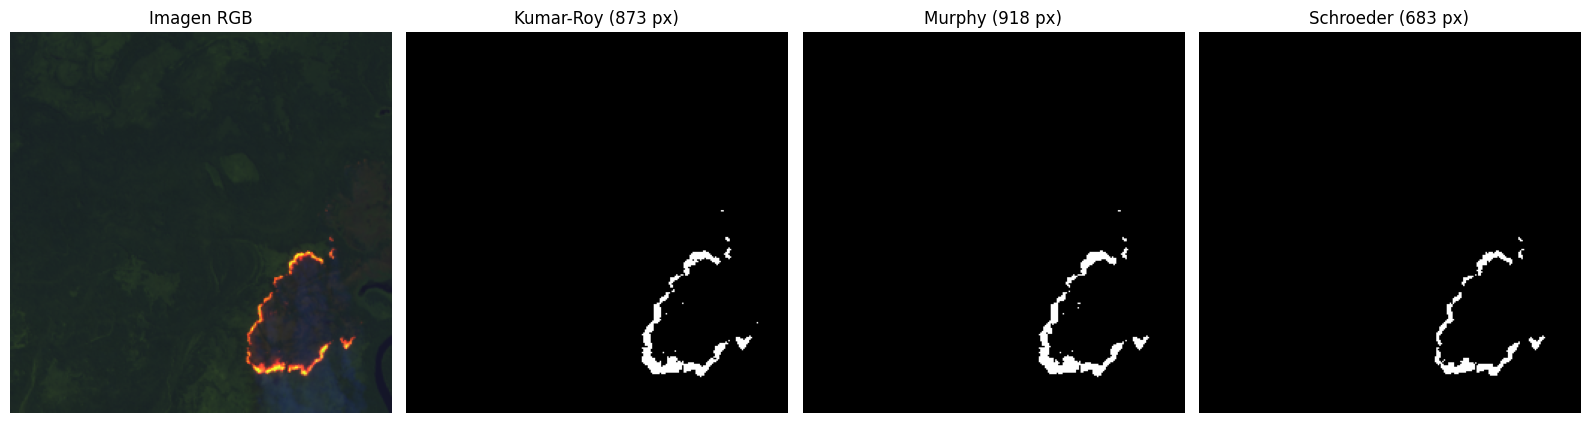

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from glob import glob

# Rutas de imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'
DATASET_CSV = './dataset/dataset_analysis_with_algorithms.csv'

# Cargar dataset
df = pd.read_csv(DATASET_CSV)
pixel_ranges = [(0, 130), (131, 618), (618, 99999)]
selected_patches = []

# Seleccionar un parche aleatorio dentro de cada rango
for min_pixels, max_pixels in pixel_ranges:
    filtered_df = df[(df["fire_pixels"].apply(lambda x: any(int(px) in range(min_pixels, max_pixels) for px in map(int, str(x).split(";")))))]
    if not filtered_df.empty:
        selected_patches.append(filtered_df.sample(n=1, random_state=41).iloc[0])

# Función para generar nombres de máscaras
def find_mask_files(base_name):
    """
    Genera los nombres correctos de las máscaras siguiendo la misma lógica que en la generación de dataset.
    """
    masks_found = {}
    for algorithm in ["Kumar-Roy", "Murphy", "Schroeder"]:
        mask_filename = re.sub(r"(p\d{5})$", rf"{algorithm}_\1", base_name) + ".tif"
        mask_path = os.path.join(MASKS_PATH, mask_filename)
        if os.path.exists(mask_path):
            masks_found[algorithm] = mask_path
    return masks_found

# Función para visualizar parches
def visualize_patch(row):
    filename = row["filename"]
    algorithms = row["algorithms"].split(";")
    fire_pixels = row["fire_pixels"].split(";")

    img_path = os.path.join(IMAGES_PATH, filename)

    # Obtener el nombre base sin Koppen ni continente
    base_name = filename.rsplit("_", 2)[0]  # Quita _koppenClass_continent.npy
    mask_paths = find_mask_files(base_name)  # 📌 Ahora usa la misma lógica que `find_mask_files()`

    # Cargar imagen
    image = np.load(img_path)[:, :, :3]

    # Cargar máscaras si existen
    masks = {}
    for algo in ["Kumar-Roy", "Murphy", "Schroeder"]:
        masks[algo] = rasterio.open(mask_paths[algo]).read(1) if algo in mask_paths else None

    # Crear la figura
    fig, axes = plt.subplots(1, 4, figsize=(16, 6))

    # 📌 Mostrar imagen original
    axes[0].imshow(image)
    axes[0].set_title("Imagen RGB")
    axes[0].axis("off")

    # 📌 Mostrar máscaras disponibles
    for i, algo in enumerate(["Kumar-Roy", "Murphy", "Schroeder"], start=1):
        if masks[algo] is not None:
            axes[i].imshow(masks[algo], cmap="gray")
            axes[i].set_title(f"{algo} ({fire_pixels[i-1]} px)")
        else:
            axes[i].text(0.5, 0.5, "No Disponible", fontsize=12, ha='center', va='center', bbox=dict(facecolor='red', alpha=0.5))
            axes[i].set_title(f"{algo} (Sin máscara)")
        axes[i].axis("off")

    # Mostrar la figura
    plt.tight_layout()
    plt.show()

# Visualizar parches seleccionados
for patch in selected_patches:
    visualize_patch(patch)

# Manual Anotations

In [ ]:
"""
This code will download the manually annotated images from Google Drive to a local directory.
This script requires gdown: https://github.com/wkentaro/gdown

You can find the manual annotations (patches) here: https://drive.google.com/drive/folders/1Gv96zhQ0HwIyquDL8vroarHoz_SJXtv5
The entire scene used to do the patches here: https://drive.google.com/drive/folders/1Pmf2mXLhN65_z6YPOi16GEvMGnNTsghD
"""

import gdown
import os

OUTPUT_DIR = './dataset/manual_annotations/compressed/'

# Set to true if you want to download the original scenes instead of the patches
DOWNLOAD_SCENES = False

BASE_URL = 'https://drive.google.com/uc?id={}'

PATCHES = {
    #'masks_patches': '1RCURItVvqsT_oMxlhB5NYiRp8SJ9_xZ3', # https://drive.google.com/file/d/1RCURItVvqsT_oMxlhB5NYiRp8SJ9_xZ3/view?usp=sharing
    'manual_annotations_patches': '1LdsX-rH5hy_82jfc1akO8p4n0_N8lRgf', # https://drive.google.com/file/d/1LdsX-rH5hy_82jfc1akO8p4n0_N8lRgf/view?usp=sharing
    'landsat_patches': '1uZnc65_GRFdAoavGoUKkJfeVQOUI8lVg', # https://drive.google.com/file/d/1uZnc65_GRFdAoavGoUKkJfeVQOUI8lVg/view?usp=sharing
}

SCENES = {
    #'masks_scenes': '198S-3FzWGA194Y5n2jFWJR0ui1OYDPYl', # https://drive.google.com/file/d/198S-3FzWGA194Y5n2jFWJR0ui1OYDPYl/view?usp=sharing
    'manual_annotatnios_scenes': '1Z38aevKnjmggsgW0Rnl9xzp377_XjXmu', # https://drive.google.com/file/d/1Z38aevKnjmggsgW0Rnl9xzp377_XjXmu/view?usp=sharing
    'landsat_scenes': '1tbdzAsijYKKSJlZB1M8WdyuIDCz6dZD6', # https://drive.google.com/file/d/1tbdzAsijYKKSJlZB1M8WdyuIDCz6dZD6/view?usp=sharing

}

def download_file(file_id, output):
    url = BASE_URL.format(file_id)
    print('Downloading: {}'.format(url))
    gdown.download(url, output)

def download_files(files):
    for file in files:

        zip_file_name = '{}.zip'.format(file)
        output = os.path.join(OUTPUT_DIR, zip_file_name)

        download_file(files[file], output)

if __name__ == '__main__':

    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    if DOWNLOAD_SCENES:
        download_files(SCENES)
    else:
        download_files(PATCHES)

Downloading: https://drive.google.com/uc?id=1LdsX-rH5hy_82jfc1akO8p4n0_N8lRgf


Downloading...
From: https://drive.google.com/uc?id=1LdsX-rH5hy_82jfc1akO8p4n0_N8lRgf
To: /content/dataset/manual_annotations/compressed/manual_annotations_patches.zip
100%|██████████| 82.9k/82.9k [00:00<00:00, 66.4MB/s]


Downloading: https://drive.google.com/uc?id=1uZnc65_GRFdAoavGoUKkJfeVQOUI8lVg


Downloading...
From (original): https://drive.google.com/uc?id=1uZnc65_GRFdAoavGoUKkJfeVQOUI8lVg
From (redirected): https://drive.google.com/uc?id=1uZnc65_GRFdAoavGoUKkJfeVQOUI8lVg&confirm=t&uuid=3b3eb459-c33a-4a96-83a1-14734f3b5bc6
To: /content/dataset/manual_annotations/compressed/landsat_patches.zip
100%|██████████| 9.61G/9.61G [01:19<00:00, 121MB/s]


In [ ]:
!rm -rf ./dataset/manual_annotations/unziped/

In [ ]:
# Librerias
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import zipfile
import shutil
from glob import glob
from multiprocessing import Pool
from itertools import islice
import reverse_geocode
import pycountry_convert as pc
from pyproj import Transformer
import warnings
warnings.filterwarnings("ignore")
import csv
from tqdm import tqdm

In [ ]:
# Configuración de rutas
INPUT_DIR = './dataset/manual_annotations/compressed'
OUTPUT_DIR = './dataset/manual_annotations/unziped'
MAX_PIXEL_VALUE = 65535  # Ajusta según el rango de valores de los TIFF
koppen_file = "./koppen_geiger_0p1.tif"

# Diccionario de códigos de continente a nombres
continent_names = {
    "AF": "Africa",
    "AS": "Asia",
    "EU": "Europe",
    "NA": "AmericaNorth",
    "SA": "AmericaSouth",
    "OC": "Oceania",
    "AN": "Antartida",
}

def get_continent(lat, lon):
    try:
        # Obtener país a partir de las coordenadas
        location = reverse_geocode.search([(lat, lon)])[0]
        country_code = location['country_code']

        # Obtener el código del continente
        continent_code = pc.country_alpha2_to_continent_code(country_code)

        # Convertir código de continente a nombre
        return continent_names.get(continent_code, "Desconocido")
    except Exception as e:
        return f"Error: {str(e)}"

# Función principal para asignar clasificación y renombrar el archivo
def classify_and_rename_patch(filename, transform, crs):
    """
    Toma un archivo de parche, obtiene su clasificación Köppen-Geiger
    y renombra el archivo agregando "_X" donde X es la clasificación.
    """
    #Calcular coordenadas UTM del centro del parche
    x_utm, y_utm = rasterio.transform.xy(transform, 128, 128)  # Se usa el transform del PARCHE

    # Convertir UTM → Lat/Lon
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    lon_centro, lat_centro = transformer.transform(x_utm, y_utm)

    # Obtener la clasificación Köppen-Geiger
    koppen_class = None
    with rasterio.open(koppen_file) as dataset:
        row, col = dataset.index(lon_centro, lat_centro)
        koppen_class = dataset.read(1)[row, col]

    # Generar nuevo nombre con la clasificación Köppen-Geiger y el continente al que pertenece
    name, ext = os.path.splitext(filename)
    CURRENT_CONTINENT_CODE=get_continent(lat_centro, lon_centro)
    new_filename = f"{name}_{koppen_class}_{CURRENT_CONTINENT_CODE}{ext}"

    return new_filename

def chunkify(lst, n):
    """Divide lst en n partes aproximadamente iguales"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def process_tiff_file(tiff_file):
    """
    Procesa archivos TIFF, extrae las bandas 7, 6 , 2 y crea el Active Fire Index, guarda los datos directamente en archivos NumPy y la informacion
    de las coordenadas en archivos .npz.
    """
    with rasterio.open(tiff_file) as src:
        # Verificar que el archivo tenga al menos 7 bandas
        if src.count < 7:
            print('Archivo tiff con menos de 7 bandas')
            return
        # Leer las bandas seleccionadas
        img = src.read((7, 6, 2)).transpose((1, 2, 0))

        # Calculo del Active Fire Index
        ratio = np.divide(img[:,:,0], img[:,:,2], out=np.zeros_like(img[:,:,0], dtype=np.float32), where=(img[:,:,2] != 0))
        img = np.stack((img[:, :, 0], img[:, :, 1], img[:, :, 2], ratio), axis=-1)
        img = np.divide(img, MAX_PIXEL_VALUE, dtype=np.float32)

        # Crear el nombre del archivo de salida en formato NumPy
        numpy_filename = tiff_file.replace('.tif', '.npy')
        numpy_filename = classify_and_rename_patch(numpy_filename, src.transform, src.crs)

        # Guardar el array en formato NumPy con Clasificacion koppen geiger
        np.save(numpy_filename, img)

        # Crear nuevo archivo para transform
        npz_filename = numpy_filename.replace('.npy', '_T.npz')

        # metadatos en .npz
        np.savez(npz_filename, transform=np.array(src.transform), crs=str(src.crs))

    # Eliminar el archivo TIFF original
    os.remove(tiff_file)

def process_chunk(chunk):
    for tiff_file in chunk:
        process_tiff_file(tiff_file)

# Crear carpeta de salida de parches
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Rutas de archivo zip grande
patches_zip_path = os.path.join(INPUT_DIR, 'landsat_patches.zip')

# Extraer zips
with zipfile.ZipFile(patches_zip_path, 'r') as zip_ref:
    print('Extrayendo...')
    zip_ref.extractall(OUTPUT_DIR)

# Contar parches extraidos
patches = glob(os.path.join(os.path.join(OUTPUT_DIR, 'landsat_patches'), '*.tif'))
print('Number of tiffs unpacked: {}'.format(len(patches)))

# Calcular chunks mediante el numero de nucleos disponibles
num_processes=!nproc
num_processes=int(num_processes[0])
chunks = list(chunkify(patches, num_processes))
# Procesar tiffs de los chunks mediante hilos
with Pool(processes=num_processes) as pool:
    pool.map(process_chunk, chunks)

print("Proceso completado.")

Extrayendo...
Number of tiffs unpacked: 9044
Proceso completado.


In [ ]:
!rm -rf ./dataset/manual_annotations/unziped/

In [ ]:
manual_zip_path = os.path.join(INPUT_DIR, 'manual_annotations_patches.zip')
OUTPUT_DIR = './dataset/manual_annotations/unziped'
# Extraer zips
with zipfile.ZipFile(manual_zip_path, 'r') as zip_ref:
    zip_ref.extractall(OUTPUT_DIR)

## Comprobacion de Coherencia

In [ ]:
# Rutas
RGB_IMAGES_PATH = './dataset/manual_annotations/unziped/landsat_patches/'
MASKS_PATH = './dataset/manual_annotations/unziped/manual_annotations_patches/'

MAX_PIXEL_VALUE = 65535

# Función para cargar una imagen RGB usando bandas específicas
def load_rgb_image(image_path):
    rgb_image = np.load(image_path)
    rgb_image = (rgb_image * 255).astype(np.uint8)
    return rgb_image

# Función para cargar una máscara binaria
def load_mask(mask_path):
    with rasterio.open(mask_path) as src:
        mask = src.read(1)  # Leer la primera banda de la máscara
    return mask

# Obtener lista de máscaras
mask_files = glob.glob(os.path.join(MASKS_PATH, '*.tif'))

# Iterar sobre las máscaras y buscar imágenes RGB correspondientes
for mask_path in mask_files:
    # Extraer el nombre base (sin directorio ni extensión) de la máscara
    mask_name = os.path.basename(mask_path)
    # Dividir el nombre en partes usando '_v1' y concatenar para formar el nombre original
    parts = mask_name.split('_v1')
    rgb_name = parts[0] + parts[1].replace('.tif', '*.npy')
    rgb_image_path = os.path.join(RGB_IMAGES_PATH, rgb_name)
    rgb_image_path = glob.glob(rgb_image_path)
    print(rgb_image_path)

    # Cargar imagen RGB y máscara
    rgb_image = load_rgb_image(rgb_image_path[0])
    print(rgb_image.shape)
    mask = load_mask(mask_path)

    # Visualización
    plt.figure(figsize=(12, 6))

    # Mostrar imagen RGB
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image[:,:,:3])
    plt.title("Imagen RGB:")
    plt.axis("off")

    # Mostrar máscara
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Imagen Etiquetada Manualmente:")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


## Manual Annotations CSV Generator

In [ ]:
# Definir rutas
IMAGES_PATH = './dataset/manual_annotations/unziped/landsat_patches/'
MASKS_PATH = './dataset/manual_annotations/unziped/manual_annotations_patches/'
OUTPUT_FOLDER = './dataset/'
IMAGES_DATAFRAME = os.path.join(OUTPUT_FOLDER, 'images_masks.csv')

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Obtener todas las máscaras disponibles
masks = glob(os.path.join(MASKS_PATH, '*.tif'))
print(f"Total de máscaras encontradas: {len(masks)}")

# Crear el archivo CSV de prueba
with open(IMAGES_DATAFRAME, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    print("Generando imágenes y máscaras asociadas...")

    for mask in tqdm(masks):
        _, mask_name = os.path.split(mask)

        # Generar el nombre de la imagen RGB correspondiente
        image_name_parts = mask_name.split('_v1')
        image_name = image_name_parts[0] + image_name_parts[1].replace('.tif', '*.npy')
        image_path = os.path.join(IMAGES_PATH, image_name)
        image_path = glob(image_path)

        # Verificar si la imagen existe
        if os.path.exists(image_path[0]):
            image_name =  os.path.basename(image_path[0])
            writer.writerow([image_path[0], os.path.join(MASKS_PATH, mask_name)])
        else:
            print(f"Advertencia: Imagen RGB no encontrada para máscara {mask_name}")

# Leer el archivo generado como DataFrame
df = pd.read_csv(IMAGES_DATAFRAME, header=None, names=['images', 'masks'])

# Crear los archivos CSV únicamente para test
test_csv_path_images = os.path.join(OUTPUT_FOLDER, 'images_test.csv')
test_csv_path_masks = os.path.join(OUTPUT_FOLDER, 'masks_test.csv')

df['images'].to_csv(test_csv_path_images, index=False)
df['masks'].to_csv(test_csv_path_masks, index=False)

print(f"Archivos generados:\n- {test_csv_path_images}\n- {test_csv_path_masks}")

Total de máscaras encontradas: 100
Generando imágenes y máscaras asociadas...


100%|██████████| 100/100 [00:02<00:00, 46.82it/s]


Archivos generados:
- ./dataset/images_test.csv
- ./dataset/masks_test.csv


## Verifiaccion de coherencia CANALES

In [ ]:
MAX_PIXEL_VALUE = 65535

# Obtener las rutas de las imágenes y las máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['images'].tolist()
mask_paths = pd.read_csv(masks_csv)['masks'].tolist()

for img_name, mask_name in zip(img_paths, mask_paths):
    # img_path = os.path.join(IMAGES_PATH, img_name)
    # mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_name)
    image[:,:,:3] = (image[:,:,:3] * 255).astype(np.uint8)
    mask = rasterio.open(mask_name).read(1)

    print(image.shape)
    print(np.max(image[:,:,3]))

    # Guardar resultados
    plt.figure(figsize=(24, 16))

    # Mostrar imagen original
    plt.subplot(1, 4, 1)
    plt.imshow(image[:,:,0], cmap='gray', vmax=255, vmin=0)
    plt.title('Canal 1')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(image[:,:,1], cmap='gray', vmax=255, vmin=0)
    plt.title('Canal 2')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(image[:,:,2], cmap='gray', vmax=255, vmin=0)
    plt.title('Canal 3')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(image[:,:,3], cmap='gray', vmin=0, vmax=np.max(image[:,:,3]))
    plt.title('Canal 4')
    plt.axis('off')

    plt.show()

# Data Augmentation for Manual Annotations

In [ ]:
# Directorios donde guardaremos las imágenes aumentadas
IMAGES_PATH = './dataset/manual_annotations/unziped/landsat_patches/'
MASKS_PATH = './dataset/manual_annotations/unziped/manual_annotations_patches/'

# Cargar CSVs originales
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

df_images = pd.read_csv(images_csv)
df_masks = pd.read_csv(masks_csv)

# Obtener las rutas originales de las imágenes y máscaras
img_paths = df_images['images'].tolist()
mask_paths = df_masks['masks'].tolist()

# Lista para almacenar las nuevas rutas
new_images = []
new_masks = []

# Funciones para aplicar espejado
def flip_horizontal(image):
    return np.fliplr(image)

def flip_vertical(image):
    return np.flipud(image)

def flip_both(image):
    return np.fliplr(np.flipud(image))

# Procesar todas las imágenes y máscaras
for img_name, mask_name in zip(img_paths, mask_paths):
    # Cargar la imagen y la máscara
    image = np.load(img_name)

    mask = rasterio.open(mask_name).read(1)

    # Obtener nombres base sin extensión
    base_name = os.path.basename(img_name).replace('.npy', '')
    mask_base_name = os.path.basename(mask_name).replace('.tif', '')
    new_images.append(img_name)
    new_masks.append(mask_name)

    # Aplicar transformaciones y guardar nuevas imágenes y máscaras
    for suffix, transform in zip(['horiz', 'vert', 'both'],
                                 [flip_horizontal, flip_vertical, flip_both]):
        img_transformed = transform(image)
        mask_transformed = transform(mask)

        img_aug_path = os.path.join(IMAGES_PATH, f"{base_name}_{suffix}.npy")
        mask_aug_path = os.path.join(MASKS_PATH, f"{mask_base_name}_{suffix}.tif")

        np.save(img_aug_path, img_transformed)

        with rasterio.open(mask_name) as src:
            profile = src.profile

        with rasterio.open(mask_aug_path, 'w', **profile) as dst:
            dst.write(mask_transformed, 1)

        # Guardar nuevas rutas en listas
        new_images.append(img_aug_path)
        new_masks.append(mask_aug_path)

print("Aumentación completada: Espejado horizontal, vertical y ambos.")

# **2. Actualizar CSVs**
# Crear DataFrames con las nuevas rutas
df_new_images = pd.DataFrame({'images': new_images})
df_new_masks = pd.DataFrame({'masks': new_masks})

# Guardar los nuevos CSVs
df_new_images.to_csv('./dataset/images_test_augmented.csv', index=False)
df_new_masks.to_csv('./dataset/masks_test_augmented.csv', index=False)

print("CSVs actualizados con nuevas imágenes y máscaras aumentadas.")

Aumentación completada: Espejado horizontal, vertical y ambos.
CSVs actualizados con nuevas imágenes y máscaras aumentadas.


In [ ]:
MAX_PIXEL_VALUE = 65535

def showimage(image, subplot, is_mask, title):
    if is_mask:
      plt.subplot(1, 4, subplot)
      plt.imshow(image, vmax=1, vmin=0, cmap='gray')
      plt.title(title)
      plt.axis('off')
    else:
      plt.subplot(1, 4, subplot)
      plt.imshow(image[:,:,:3], vmax=255, vmin=0)
      plt.title(title)
      plt.axis('off')

def get_title(j):
    # Definir título según el índice
    if j == 0:
        return "Original"
    elif j == 1:
        return "Espejado Horizontal"
    elif j == 2:
        return "Espejado Vertical"
    else:
        return "Espejado Ambos"

# Obtener las rutas de las imágenes y las máscaras
images_csv = './dataset/images_test_augmented.csv'
masks_csv = './dataset/masks_test_augmented.csv'

img_paths = pd.read_csv(images_csv)['images'].tolist()
mask_paths = pd.read_csv(masks_csv)['masks'].tolist()

# Mostrar imágenes en lotes de 4 (original + 3 aumentadas)
for i in range(0, len(img_paths), 4):

    plt.figure(figsize=(16, 8))
    for j in range(4):
        title = get_title(j)
        img_name = img_paths[i+j]
        image = np.load(img_name)
        showimage(image, j+1, False, title)
    plt.show()

    plt.figure(figsize=(16, 8))
    for j in range(4):
        title = get_title(j)
        mask_name = mask_paths[i+j]
        mask = rasterio.open(mask_name).read(1)
        showimage(mask, j+1, True, title)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Cargar CSVs
images_csv, masks_csv = './dataset/images_test_augmented.csv', './dataset/masks_test_augmented.csv'
df_images, df_masks = pd.read_csv(images_csv), pd.read_csv(masks_csv)

# Verificar que las imágenes y máscaras coincidan
assert len(df_images) == len(df_masks), "Error: Desbalance entre imágenes y máscaras."

# División en train (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(df_images, df_masks, test_size=0.3, random_state=42, shuffle=True)

# División de temp en validación (20%) y test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, shuffle=True)

# Guardar los nuevos CSVs
for split, X, y in zip(["train", "val", "test"], [X_train, X_val, X_test], [y_train, y_val, y_test]):
    X.to_csv(f'./dataset/images_{split}.csv', index=False)
    y.to_csv(f'./dataset/masks_{split}.csv', index=False)

print(f"✅ División completada: Train {len(X_train)}, Val {len(X_val)}, Test {len(X_test)}")

✅ División completada: Train 280, Val 80, Test 40


# Dividir dataset

## Encontrando limites de grupos por cantidad de pixeles

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns

2  end
3  end
4  end
5  end
6  end
7  end
8  end
9  end


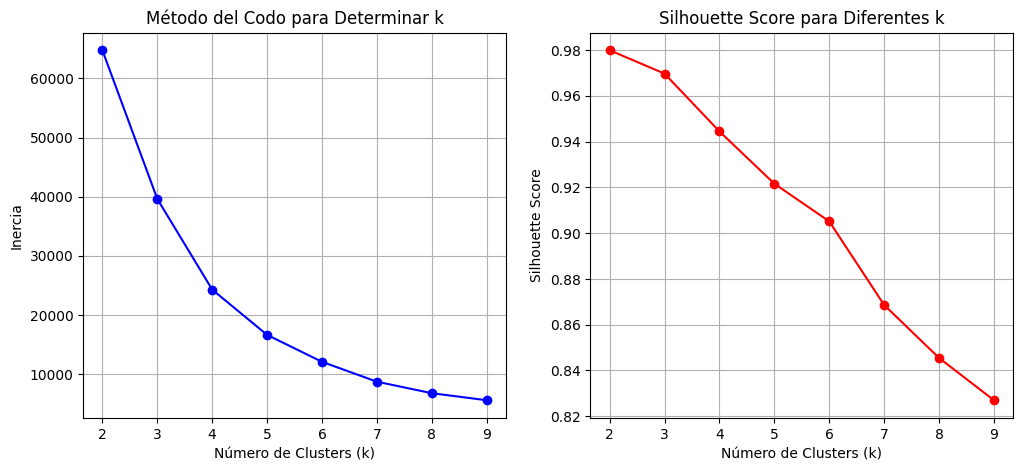

In [ ]:
# Cargar el dataset
df = pd.read_csv("./dataset_analysis_with_algorithms.csv")

# Extraer la columna fire_pixels y calcular el promedio si hay múltiples valores
def compute_fire_pixel_mean(fire_pixel_str):
    values = list(map(int, fire_pixel_str.split(';')))
    return np.mean(values)

df["fire_pixels_avg"] = df["fire_pixels"].apply(compute_fire_pixel_mean)

# Escalar los valores de fire_pixels_avg para mejor clustering
scaler = StandardScaler()
fire_pixels_scaled = scaler.fit_transform(df[["fire_pixels_avg"]])

# Probar diferentes valores de k y calcular la inercia (método del codo)
inertias = []
silhouette_scores = []
k_values = range(2, 10)  # Probamos entre 2 y 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(fire_pixels_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(fire_pixels_scaled, kmeans.labels_))
    print(k, ' end')

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del Codo para Determinar k")
plt.grid()

# Graficar el silhouette score
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='r')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score para Diferentes k")
plt.grid()

plt.show()

In [ ]:
df = pd.read_csv("./dataset_analysis_with_algorithms.csv")

# Extraer la columna fire_pixels y calcular el promedio si hay múltiples valores
def compute_fire_pixel_mean(fire_pixel_str):
    values = list(map(int, fire_pixel_str.split(';')))
    return np.mean(values)

df["fire_pixels_avg"] = df["fire_pixels"].apply(compute_fire_pixel_mean)

# Escalar los valores de fire_pixels_avg para mejor clustering
scaler = StandardScaler()
fire_pixels_scaled = scaler.fit_transform(df[["fire_pixels_avg"]])
kmeans=KMeans(n_clusters=3, random_state=42, n_init=200)
kmeans.fit(fire_pixels_scaled)

KMeans(n_clusters=3, n_init=200, random_state=42)

In [ ]:
df["fire_pixel_group"] = kmeans.fit_predict(fire_pixels_scaled)

In [ ]:
df["fire_pixel_group"].value_counts().sort_index()

fire_pixel_group
0    145322
1       832
2        60
Name: count, dtype: int64

<ipython-input-14-8170548d3414>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["fire_pixel_group"], palette="viridis")


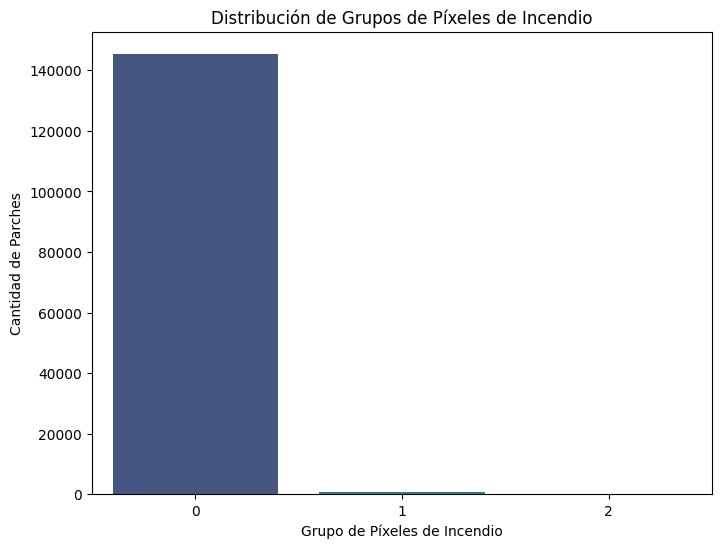

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x=df["fire_pixel_group"], palette="viridis")
plt.xlabel("Grupo de Píxeles de Incendio")
plt.ylabel("Cantidad de Parches")
plt.title("Distribución de Grupos de Píxeles de Incendio")
plt.show()

In [ ]:
df.groupby("fire_pixel_group")["fire_pixels_avg"].describe()

count        mean         std         min         25%  \
fire_pixel_group                                                             
0                 145322.0    5.034081   10.214451    1.000000    1.000000   
1                    832.0  254.102564  116.150319  130.000000  162.333333   
2                     60.0  978.500000  483.505401  618.666667  683.333333   

                         50%          75%          max  
fire_pixel_group                                        
0                   2.000000     4.333333   129.333333  
1                 213.666667   314.333333   612.333333  
2                 810.833333  1041.583333  3231.500000

## Encontrando la relacion entre koppen class y contiente

continent
Asia       74415
America    27760
Africa     27729
Europe     14110
Oceania     2200
Name: count, dtype: int64


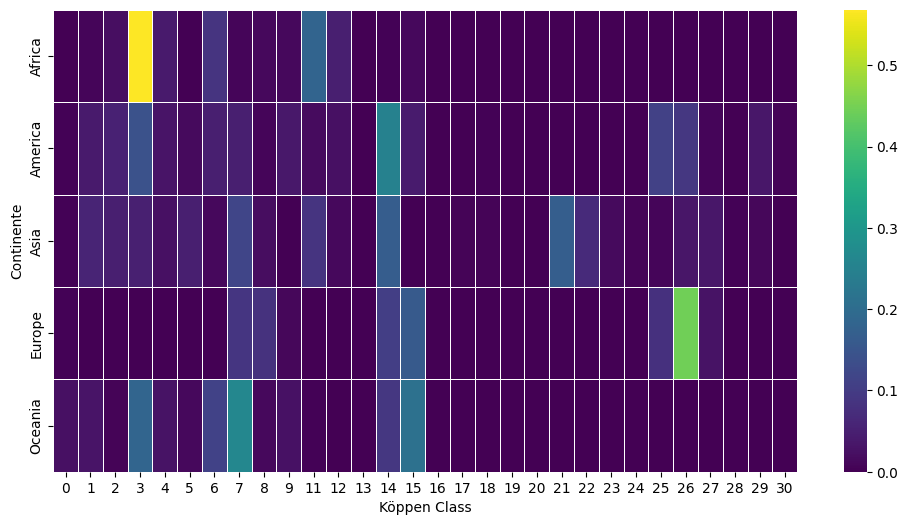

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("./dataset/dataset_analysis_with_algorithms.csv")

# Mostrar la nueva distribución de continentes
print(df["continent"].value_counts())

# Crear una tabla de frecuencia cruzada (matriz de contingencia)
contingency_table = pd.crosstab(df["continent"], df["koppen_class"])

# Normalizar por filas para obtener proporciones dentro de cada continente
contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Visualizar la matriz de contingencia con un heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table_normalized, cmap="viridis", annot=False, linewidths=0.5)
plt.xlabel("Köppen Class")
plt.ylabel("Continente")
#plt.title("Tabla de frecuencia cruzada Köppen-Geiger por Continente")
plt.savefig("Tabla de frecuencia cruzada Köppen-Geiger por Continente.png", dpi=300, bbox_inches='tight')
plt.show()

## Algoritmo de reduccion

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset
DATASET_PATH = "./dataset/dataset_analysis_with_algorithms.csv"
df = pd.read_csv(DATASET_PATH)

# Definir el porcentaje de reducción objetivo
TARGET_REDUCTION = 0.50  # Reducir al 50%
initial_size = len(df)
target_size = int(initial_size * (1 - TARGET_REDUCTION))

# Categorizar píxeles de incendio
def categorize_fire_pixels(num_pixels):
    if num_pixels < 130:
        return "0-130"
    elif num_pixels < 618:
        return "131-618"
    else:
        return "618+"

def parse_fire_pixels(fire_pixels):
    pixel_values = list(map(int, fire_pixels.split(';')))
    return np.mean(pixel_values)

df["fire_pixel_avg"] = df["fire_pixels"].apply(parse_fire_pixels)
df["fire_pixel_group"] = df["fire_pixel_avg"].apply(categorize_fire_pixels)

# Mostrar distribución inicial
counts = df[['continent', 'koppen_class', 'fire_pixel_group']].value_counts()
plt.figure(figsize=(200, 48))
counts.plot(kind='bar')
plt.xlabel('Combinación de Continent, Köppen Class y Fire Pixel Group')
plt.ylabel('Frecuencia')
plt.title('Frecuencia inicial de combinaciones en el dataset')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("frecuencia_combinaciones_inicial.png", dpi=300, bbox_inches='tight')
plt.show()

# Iniciar reducción en pasos de 1% del dataset original
current_size = initial_size
step_size = int(initial_size * 0.001)  # Reducir 1% en cada iteración

while current_size > target_size:
    # Encontrar la combinación más frecuente
    most_common_combination = df[['continent', 'koppen_class', 'fire_pixel_group']].value_counts().idxmax()
    top_continent, top_koppen, top_fire_group = most_common_combination

    # Seleccionar parches a eliminar (batch de 1%)
    to_remove = df[(df["continent"] == top_continent) &
                   (df["koppen_class"] == top_koppen) &
                   (df["fire_pixel_group"] == top_fire_group)]

    if len(to_remove) > 0:
        to_remove = to_remove.sample(n=min(step_size, len(to_remove)), random_state=42)
        df = df.drop(to_remove.index)  # Eliminar filas
        current_size = len(df)
        print(f"Reducido a {current_size} parches, meta: {target_size}")
    else:
        print("No se pudo eliminar más sin afectar clases raras.")
        break  # Evita eliminar en exceso si ya no hay suficientes muestras

# Guardar el dataset reducido
df.to_csv("dataset_analysis_with_algorithms_reduced.csv", index=False)
print("Reducción completa y dataset guardado correctamente.")

# Mostrar distribución final
counts = df[['continent', 'koppen_class', 'fire_pixel_group']].value_counts()
plt.figure(figsize=(100, 12))
counts.plot(kind='bar')
plt.xlabel('Combinación de Continent, Köppen Class y Fire Pixel Group')
plt.ylabel('Frecuencia')
plt.title('Frecuencia Final de combinaciones en el dataset')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("frecuencia_combinaciones_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Definir las rutas
IMAGES_PATH = './dataset/images/patches/'

# Cargar el dataframe
df = pd.read_csv('dataset_analysis_with_algorithms_reduced.csv')

# Función para determinar el grupo de píxeles según los valores
def get_pixel_group(fire_pixel_avg):
    if 0 <= fire_pixel_avg <= 130:
        return '0-130'
    elif 131 <= fire_pixel_avg <= 618:
        return '131-618'
    elif fire_pixel_avg >= 618:
        return '618+'
    else:
        return None

# Agregar una columna para los grupos de píxeles
df['pixel_group'] = df['fire_pixel_avg'].apply(get_pixel_group)

# Crear un loop para cada combinación de clase de Köppen y grupo de píxeles
for koppen_class in df['koppen_class'].unique():
    for pixel_group in ['0-130', '131-618', '618+']:
        # Filtrar las imágenes para cada clase de Köppen y grupo de píxeles
        subset = df[(df['koppen_class'] == koppen_class) & (df['pixel_group'] == pixel_group)]

        # Si hay imágenes para esa combinación de clase y grupo de píxeles
        if not subset.empty:
            # Tomar la primera imagen del subset
            row = subset.iloc[0]
            img_name = row['filename']

            img_path = os.path.join(IMAGES_PATH, img_name)

            # Cargar la imagen
            image = np.load(img_path)

            # Mostrar resultados
            plt.figure(figsize=(12, 8))

            # Mostrar imagen original
            plt.subplot(1, 3, 1)
            plt.imshow(image[:,:,:3])
            plt.title(f'Imagen - {koppen_class} - {pixel_group}')
            plt.axis('off')
            plt.show()

## Graficas de muestreo

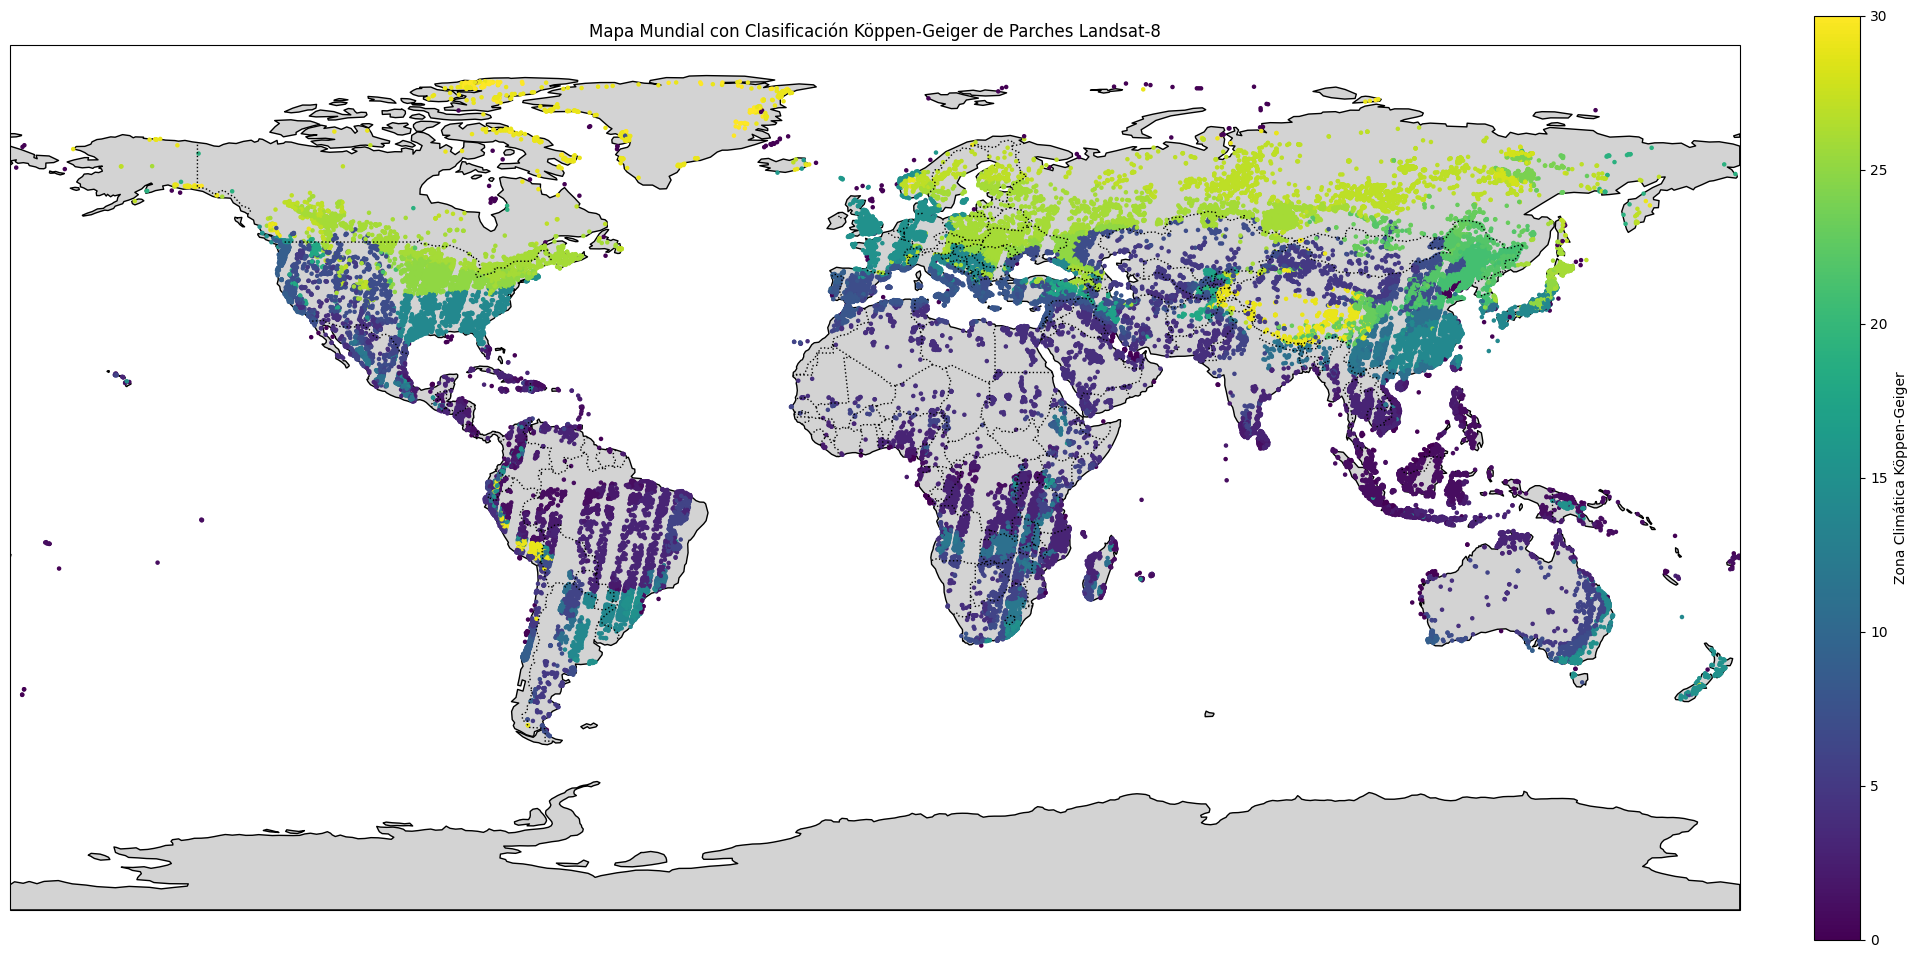

In [ ]:
import os
import re
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio.transform import Affine
from rasterio.crs import CRS
from pyproj import Transformer

# Archivos de entrada
input_folder = "./dataset/images/patches/"  # Ruta de las imágenes
csv_file = "dataset_analysis_with_algorithms_reduced.csv"  # Archivo CSV con los datos

# Cargar el dataframe y extraer la lista de archivos
df = pd.read_csv(csv_file)
file_list = set(df['filename'])  # Convertir la columna 'filename' en un conjunto para búsqueda rápida

# Función para extraer Path, Row y clasificación Köppen-Geiger del nombre del archivo
def parse_filename(filename):
    match = re.search(r"LC08_(?:L1TP|L1GT|L1GS)_(\d{3})(\d{3})_\d{8}_\d{8}_\d{2}_\w+_p(\d{5})_(\d+)_(\w+)\.npy", filename)
    if match:
        path = int(match.group(1))
        row = int(match.group(2))
        patch_number = int(match.group(3))
        koppen_class = int(match.group(4))
        continent = match.group(5)
        return path, row, patch_number, koppen_class, continent
    return None

# Función para obtener coordenadas de un parche
def get_patch_center_coords(npy_file):
    metadata_file = npy_file.replace(".npy", "_T.npz")
    if not os.path.exists(metadata_file):
        return None, None

    with np.load(metadata_file, allow_pickle=True) as data:
        transform = data["transform"]
        crs = data["crs"].item()
        transform = Affine(*transform.flatten())
        crs = CRS.from_string(crs)

    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    x_utm, y_utm = rasterio.transform.xy(transform, 128, 128)
    lon_centro, lat_centro = transformer.transform(x_utm, y_utm)
    return lon_centro, lat_centro

# Recorrer la carpeta y obtener coordenadas y clasificaciones climáticas solo para los archivos en el dataframe
patch_data = []
for filename in os.listdir(input_folder):
    if filename.endswith(".npy") and filename in file_list:  # Filtrar solo los archivos en el CSV
        parsed = parse_filename(filename)
        if parsed:
            path, row, patch_number, koppen_class, continent = parsed
            npy_path = os.path.join(input_folder, filename)
            lon, lat = get_patch_center_coords(npy_path)
            if lon is not None and lat is not None:
                patch_data.append((lon, lat, koppen_class))

# Crear el mapa mundial con puntos de datos
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Extraer coordenadas y clases Köppen para graficar
if patch_data:
    lons, lats, koppen_classes = zip(*patch_data)
    sc = ax.scatter(lons, lats, c=koppen_classes, cmap="viridis", marker=".", s=20, edgecolor="face", transform=ccrs.PlateCarree())
    cbar = plt.colorbar(sc, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
    cbar.set_label("Zona Climática Köppen-Geiger")

ax.set_title("Mapa Mundial con Clasificación Köppen-Geiger de Parches Landsat-8", fontsize=12)
plt.savefig("Mapa Mundial con Clasificación Köppen-Geiger de Parches Landsat-8_Reduced", dpi=300)
plt.show()

In [ ]:
len(patch_data)

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Cargar el dataset
df = pd.read_csv('./dataset/dataset_analysis_with_algorithms.csv')
df_reduced = pd.read_csv('./dataset_analysis_with_algorithms_reduced.csv')

def categorize_fire_pixels(num_pixels):
    if num_pixels < 130:
        return "0-130"
    elif num_pixels < 618:
        return "131-618"
    else:
        return "618+"

def parse_fire_pixels(fire_pixels):
    pixel_values = list(map(int, fire_pixels.split(';')))
    return np.mean(pixel_values)

# Función para visualizar distribuciones
def plot_distributions(df, df_reduced):
    plt.figure(figsize=(12, 6))
    sns.countplot(x="koppen_class", data=df, palette="viridis", order=df["koppen_class"].value_counts().index)
    plt.xlabel("Zona Climática")
    plt.ylabel("Cantidad de Parches")
    #plt.title(f"Distribución de Parches por Zona Climática Antes de Reducción)")
    plt.xticks(rotation=90)
    plt.savefig("Distribución de Parches por Zona Climática PRE.png", dpi=300)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(x="koppen_class", data=df_reduced, palette="viridis", order=df_reduced["koppen_class"].value_counts().index)
    plt.xlabel("Zona Climática")
    plt.ylabel("Cantidad de Parches")
    #plt.title(f"Distribución de Parches por Zona Climática Despues de Reducción)")
    plt.xticks(rotation=90)
    plt.savefig("Distribución de Parches por Zona Climática POST.png", dpi=300)
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.countplot(x="continent", data=df, palette="coolwarm", order=df["continent"].value_counts().index)
    plt.xlabel("Continente")
    plt.ylabel("Cantidad de Parches")
    #plt.title(f"Distribución de Parches por Continente Antes de Reducción)")
    plt.savefig("Distribución de Parches por Continente PRE.png", dpi=300)
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.countplot(x="continent", data=df_reduced, palette="coolwarm", order=df_reduced["continent"].value_counts().index)
    plt.xlabel("Continente")
    plt.ylabel("Cantidad de Parches")
    #plt.title(f"Distribución de Parches por Continente Despues de Reducción)")
    plt.savefig("Distribución de Parches por Continente POST.png", dpi=300)
    plt.show()


    df["fire_pixel_avg"] = df["fire_pixels"].apply(parse_fire_pixels)
    df["fire_pixel_group"] = df["fire_pixel_avg"].apply(categorize_fire_pixels)
    plt.figure(figsize=(10, 6))
    sns.countplot(x="fire_pixel_group", data=df, palette="magma", order=df["fire_pixel_group"].value_counts().index)
    plt.xlabel("Grupo de Píxeles de Incendio")
    plt.ylabel("Cantidad de Parches")
    #plt.title(f"Distribución de Píxeles de Incendio Antes de Reducción)")
    plt.savefig("Distribución de Píxeles de Incendio PRE.png", dpi=300)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.countplot(x="fire_pixel_group", data=df_reduced, palette="magma", order=df_reduced["fire_pixel_group"].value_counts().index)
    plt.xlabel("Grupo de Píxeles de Incendio")
    plt.ylabel("Cantidad de Parches")
    #plt.title(f"Distribución de Píxeles de Incendio Despues de Reducción)")
    plt.savefig("Distribución de Píxeles de Incendio POST.png", dpi=300)
    plt.show()

# Mostrar distribución antes de la reducción
plot_distributions(df, df_reduced)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dataset_path_r = "dataset_analysis_with_algorithms_reduced.csv"
title_suffix_r = "(Después de Reducción)"

dataset_path = "dataset/dataset_analysis_with_algorithms.csv"
title_suffix = "(Antes de Reducción)"

# Cargar el dataset
df = pd.read_csv(dataset_path)
df_r = pd.read_csv(dataset_path_r)

def categorize_fire_pixels(num_pixels):
    num_pixels = np.mean([int(px) for px in str(num_pixels).split(";")])  # Promedio entre algoritmos
    if num_pixels < 130:
        return "0-130"
    elif num_pixels < 618:
        return "131-618"
    else:
        return "618+"

df["fire_pixel_group"] = df["fire_pixels"].apply(categorize_fire_pixels)

# 📌 3️⃣ Función para graficar barras apiladas con la cantidad total de parches
def plot_stacked_bar_count(df_x, group_col, hue_col, title, palette, x_label, legend):
    """
    Genera un gráfico de barras donde el eje X es 'group_col' y cada barra está dividida en segmentos de 'hue_col'.
    El eje Y muestra la cantidad total de parches.
    """
    df_grouped = df_x.groupby([group_col, hue_col]).size().reset_index(name="count")
    df_pivot = df_grouped.pivot(index=group_col, columns=hue_col, values="count").fillna(0)

    # Graficar barras apiladas con la cantidad total de parches
    df_pivot.plot(kind="bar", stacked=True, colormap=palette, figsize=(12, 7.7))
    plt.xlabel(x_label)
    plt.ylabel("Cantidad de Parches")
    #plt.title(f"{title} {title_suffix}")
    plt.legend(title=hue_col, bbox_to_anchor=(1, 1))
    #plt.xticks(rotation=45)
    plt.savefig(title+".png", dpi=600)
    plt.show()

# Gráfico de distribución de Köppen-Geiger dentro de cada continente
plot_stacked_bar_count(
    df,
    group_col="continent",
    hue_col="koppen_class",
    title="Distribución de Köppen-Geiger en Cada Continente PRE",
    palette="coolwarm",
    x_label="Continente",
    legend="Zona Climatica"
)

# Gráfico de distribución de Köppen-Geiger dentro de cada continente
plot_stacked_bar_count(
    df_r,
    group_col="continent",
    hue_col="koppen_class",
    title="Distribución de Köppen-Geiger en Cada Continente POST",
    palette="coolwarm",
    x_label="Continente"
)

plot_stacked_bar_count(
    df,
    group_col="koppen_class",
    hue_col="continent",
    title="Distribución de Continente en Cada clase Köppen-Geiger PRE",
    palette="coolwarm",
    x_label="Zona Climática"
)

plot_stacked_bar_count(
    df_r,
    group_col="koppen_class",
    hue_col="continent",
    title="Distribución de Continente en Cada clase Köppen-Geiger POST",
    palette="coolwarm",
    x_label="Zona Climática"
)

# Gráfico de distribución de Grupos de Píxeles de Incendio dentro de cada continente
plot_stacked_bar_count(
    df,
    group_col="continent",
    hue_col="fire_pixel_group",
    title="Distribución de Grupos de Píxeles de Incendio en Cada Continente PRE",
    palette="coolwarm",
    x_label="Continente"
)

# Gráfico de distribución de Grupos de Píxeles de Incendio dentro de cada continente
plot_stacked_bar_count(
    df_r,
    group_col="continent",
    hue_col="fire_pixel_group",
    title="Distribución de Grupos de Píxeles de Incendio en Cada Continente POST",
    palette="coolwarm",
    x_label="Continente"
)

KeyError: 'Zona Climática'

In [ ]:
# Barras apiladas de algorithm vs. continent
plt.figure(figsize=(10, 6))
df_grouped = df.groupby(['continent', 'algorithms']).size().unstack()
df_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de algoritmos por continente (Antes de reduccion)')
plt.xlabel('Continente')
plt.ylabel('Cantidad')
plt.legend(title='Algoritmos')
plt.show()

# Barras apiladas de algorithm vs. continent
plt.figure(figsize=(10, 6))
df_grouped = df_reduced.groupby(['continent', 'algorithms']).size().unstack()
df_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de algoritmos por continente (Despues de reduccion)')
plt.xlabel('Continente')
plt.ylabel('Cantidad')
plt.legend(title='Algoritmos')
plt.show()

In [ ]:
import pandas as pd

# Cargar el dataset reducido
df = pd.read_csv("./dataset_analysis_with_algorithms_reduced.csv")

# Separar la columna de algoritmos en listas
df["algorithms"] = df["algorithms"].str.split(";")

# Contar cuántos parches contienen cada algoritmo
algo_counts = {
    "Kumar-Roy": df["algorithms"].apply(lambda x: "Kumar-Roy" in x).sum(),
    "Murphy": df["algorithms"].apply(lambda x: "Murphy" in x).sum(),
    "Schroeder": df["algorithms"].apply(lambda x: "Schroeder" in x).sum(),
}

# Crear DataFrame para visualización
algo_df = pd.DataFrame(list(algo_counts.items()), columns=["Algorithm", "Patch Count"])

# Mostrar la distribución antes y después de la reducción
print("Distribución de algoritmos después de la reducción:")
print(algo_df)

# Visualización con barras
import matplotlib.pyplot as plt
import seaborn as sns

Distribución de algoritmos después de la reducción:
   Algorithm  Patch Count
0  Kumar-Roy        70711
1     Murphy        39539
2  Schroeder        30446


<ipython-input-8-3e4cf89461d4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="koppen_class", data=df_algo, palette="viridis", order=df_algo["koppen_class"].value_counts().index)


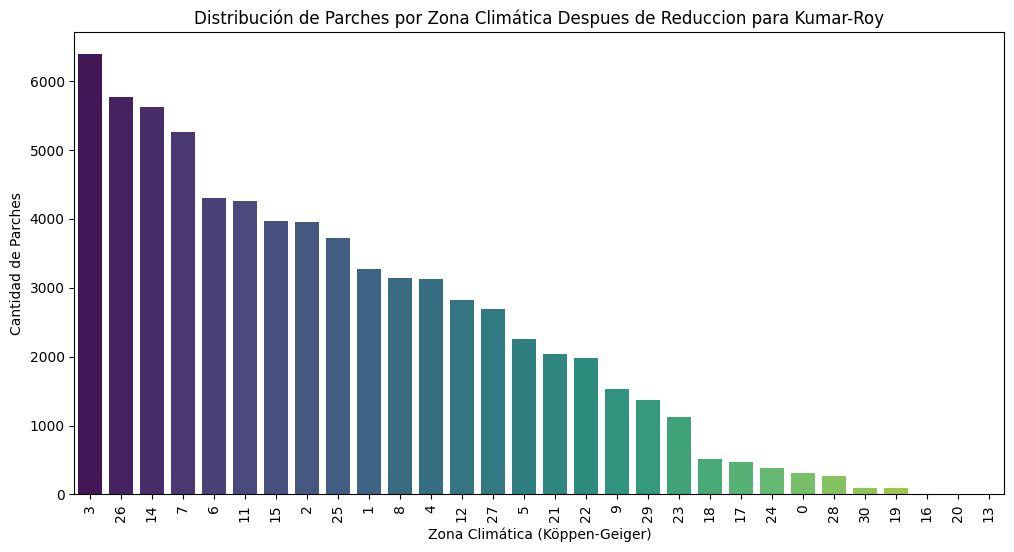

<ipython-input-8-3e4cf89461d4>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="continent", data=df_algo, palette="coolwarm", order=df["continent"].value_counts().index)


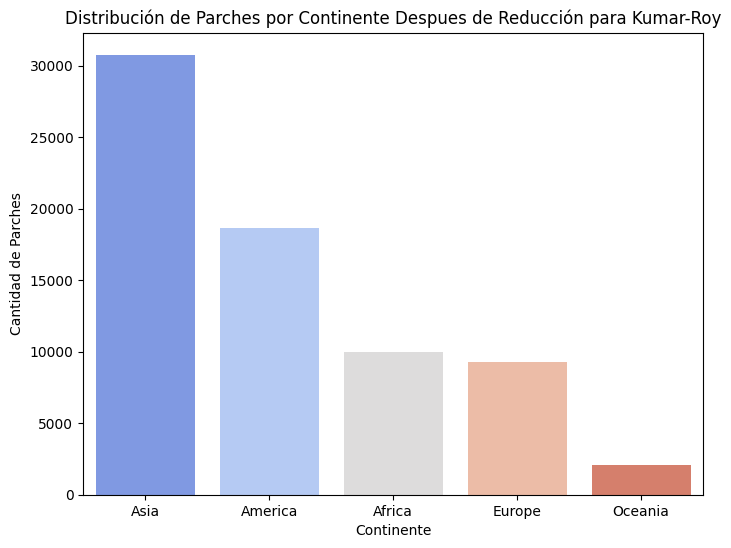

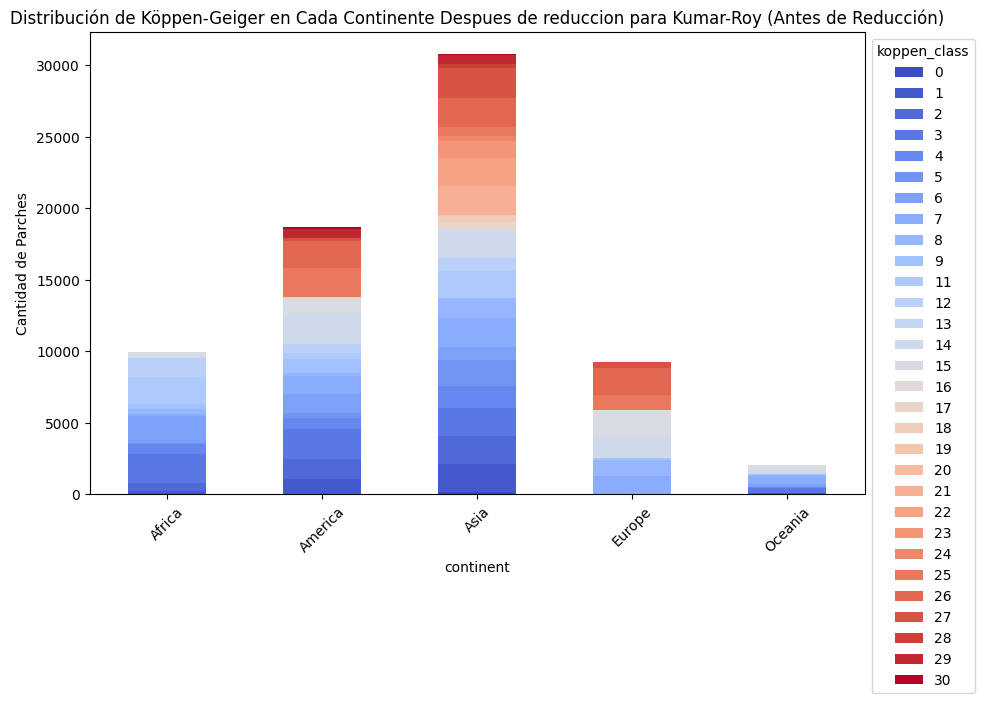

<ipython-input-8-3e4cf89461d4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="koppen_class", data=df_algo, palette="viridis", order=df_algo["koppen_class"].value_counts().index)


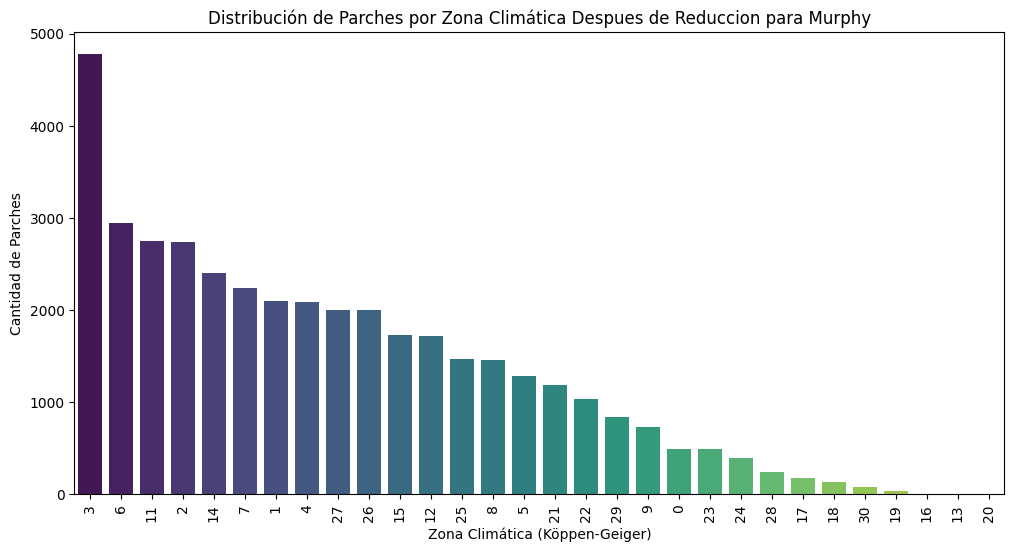

<ipython-input-8-3e4cf89461d4>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="continent", data=df_algo, palette="coolwarm", order=df["continent"].value_counts().index)


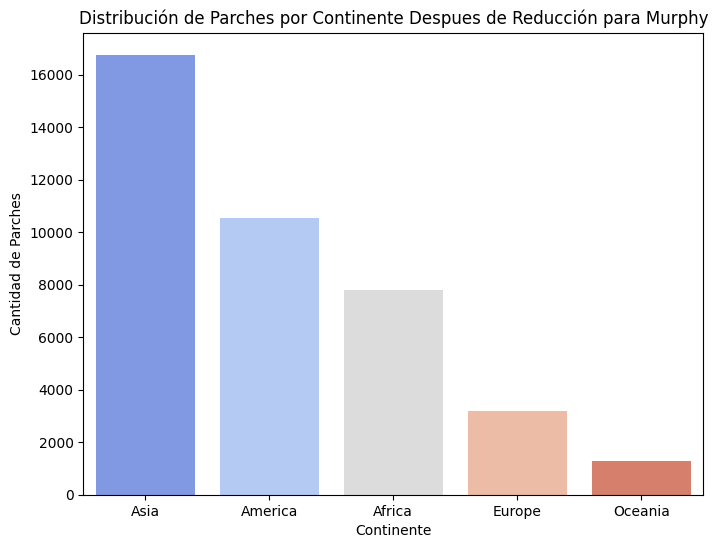

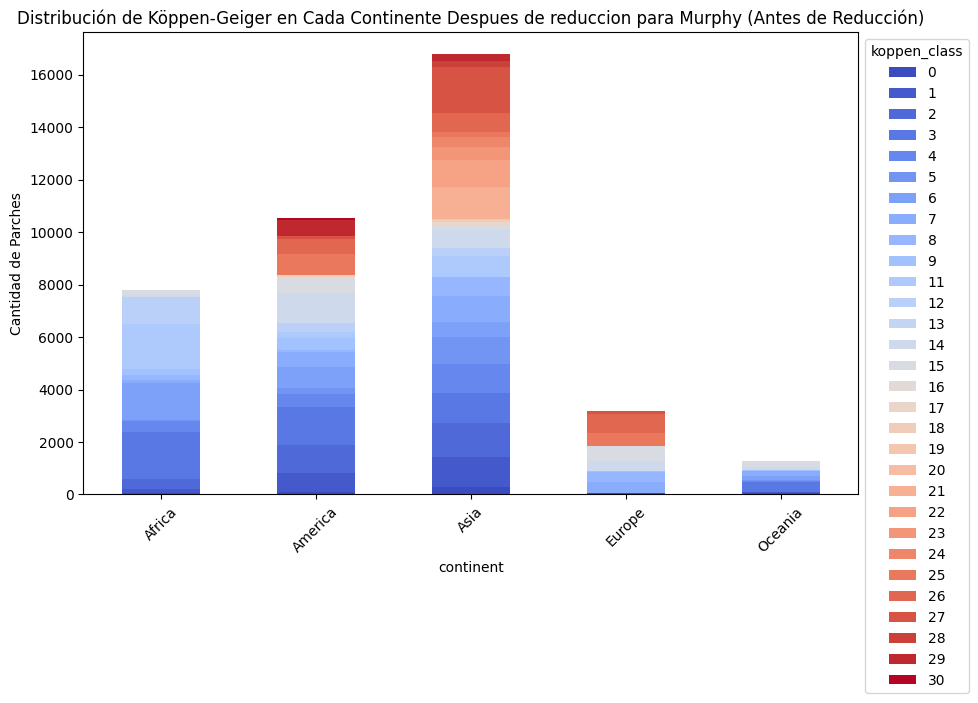

<ipython-input-8-3e4cf89461d4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="koppen_class", data=df_algo, palette="viridis", order=df_algo["koppen_class"].value_counts().index)


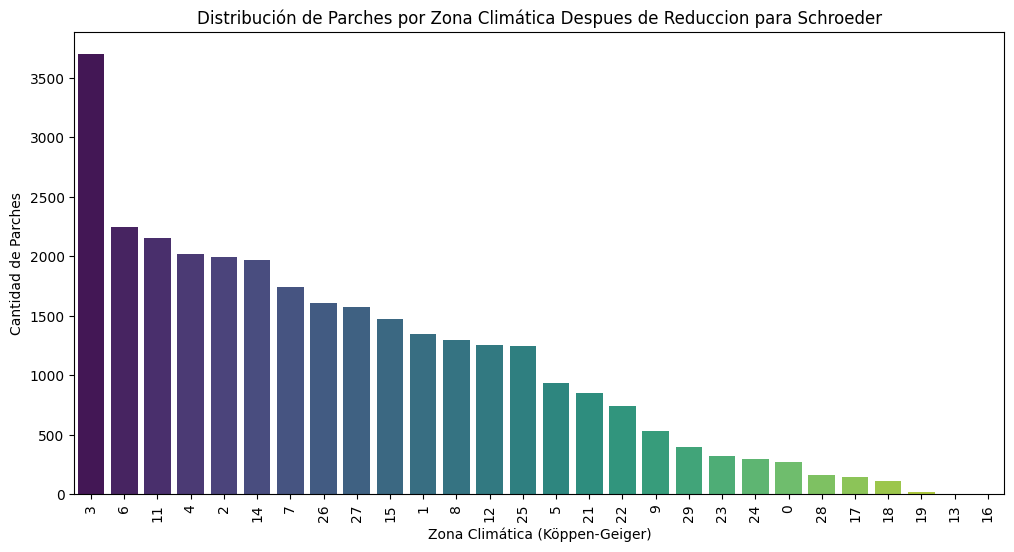

<ipython-input-8-3e4cf89461d4>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="continent", data=df_algo, palette="coolwarm", order=df["continent"].value_counts().index)


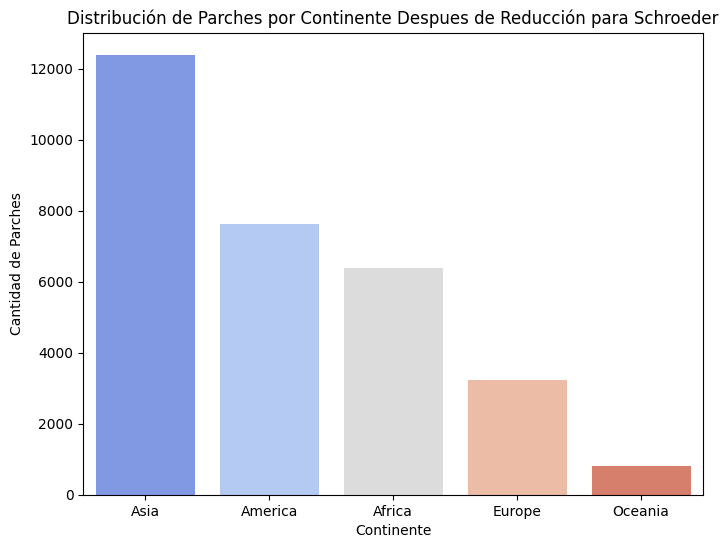

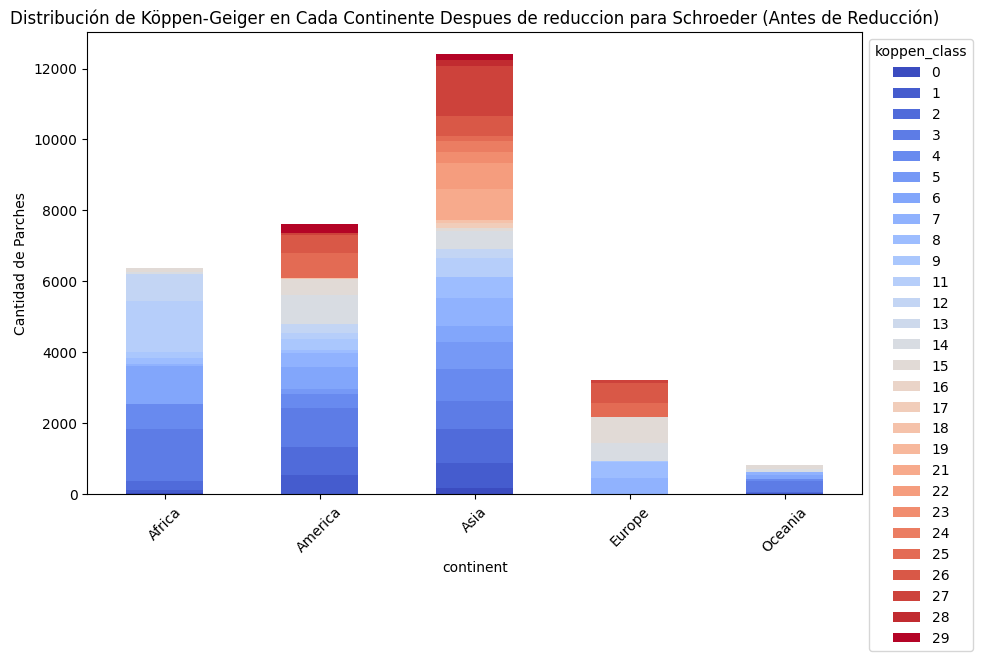

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset reducido
df = pd.read_csv("./dataset_analysis_with_algorithms_reduced.csv")

# Separar la columna de algoritmos en listas
df["algorithms"] = df["algorithms"].str.split(";")

# Iterar sobre cada algoritmo y filtrar el dataset
for algo in ["Kumar-Roy", "Murphy", "Schroeder"]:
    df_algo = df[df["algorithms"].apply(lambda x: algo in x)]  # Filtrar parches donde aparece el algoritmo

    # Crear la gráfica
    plt.figure(figsize=(12, 6))
    sns.countplot(x="koppen_class", data=df_algo, palette="viridis", order=df_algo["koppen_class"].value_counts().index)
    plt.xlabel("Zona Climática (Köppen-Geiger)")
    plt.ylabel("Cantidad de Parches")
    plt.title(f"Distribución de Parches por Zona Climática Despues de Reduccion para {algo}")
    plt.xticks(rotation=90)
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.countplot(x="continent", data=df_algo, palette="coolwarm", order=df["continent"].value_counts().index)
    plt.xlabel("Continente")
    plt.ylabel("Cantidad de Parches")
    plt.title(f"Distribución de Parches por Continente Despues de Reducción para {algo}")
    plt.show()

    # Gráfico de distribución de Köppen-Geiger dentro de cada continente
    plot_stacked_bar_count(
        df_algo,
        group_col="continent",
        hue_col="koppen_class",
        title=f"Distribución de Köppen-Geiger en Cada Continente Despues de reduccion para {algo}",
        palette="coolwarm"
    )

In [ ]:
# Cargar el dataset
df = pd.read_csv(dataset_path)
df_reduced = pd.read_csv('./dataset_analysis_with_algorithms_reduced.csv')
len(df_reduced)

73068

In [ ]:
df.groupby('koppen_class')['koppen_class'].value_counts().sort_values(ascending=False)

koppen_class
3     23865
14    20890
21    12561
7     12107
11    11738
26    11103
2      5596
1      5499
22     5058
6      4826
25     4780
15     4335
5      3975
4      3663
27     3211
8      3205
12     2870
29     1661
9      1563
23     1151
0       562
18      526
17      482
24      425
28      295
30      152
19       98
16       10
13        4
20        3
Name: count, dtype: int64

In [ ]:
df_reduced.groupby('koppen_class')['koppen_class'].value_counts().sort_values(ascending=False)

koppen_class
3     6491
26    5847
14    5706
7     5391
6     4388
11    4292
15    4043
2     3990
25    3758
4     3663
1     3309
8     3205
12    2870
27    2773
5     2369
21    2049
22    1992
29    1661
9     1563
23    1151
0      562
18     526
17     482
24     425
28     295
30     152
19      98
16      10
13       4
20       3
Name: count, dtype: int64

In [ ]:
def categorize_fire_pixels(num_pixels):
    if num_pixels < 130:
        return "0-130"
    elif num_pixels < 618:
        return "131-618"
    else:
        return "618+"

def parse_fire_pixels(fire_pixels):
    pixel_values = list(map(int, fire_pixels.split(';')))
    return np.mean(pixel_values)

df["fire_pixel_avg"] = df["fire_pixels"].apply(parse_fire_pixels)
df["fire_pixel_group"] = df["fire_pixel_avg"].apply(categorize_fire_pixels)
df.groupby('fire_pixel_group')['fire_pixel_group'].value_counts().sort_values(ascending=False)

fire_pixel_group
0-130      145322
131-618       832
618+           60
Name: count, dtype: int64

In [ ]:
df_reduced.groupby('fire_pixel_group')['fire_pixel_group'].value_counts().sort_values(ascending=False)

fire_pixel_group
0-130      72176
131-618      832
618+          60
Name: count, dtype: int64

## Division de Subconjuntos

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import re

# Parámetros de división
TRAIN_RATIO = 0.4
VALIDATION_RATIO = 0.3
TEST_RATIO = 0.3
RANDOM_STATE = 87

# Algoritmo objetivo para la máscara
MASK_ALGORITHM = 'Kumar-Roy'

# Rutas
OUTPUT_FOLDER = './dataset/'

# Cargar el dataset reducido
df = pd.read_csv("./dataset_analysis_with_algorithms_reduced.csv")

print(f"Total de parches antes del filtrado: {len(df)}")

# Generar la columna `maskfile` solo si el algoritmo objetivo está presente
def generate_mask_filename(row):
    algorithms = row["algorithms"].split(";")
    if MASK_ALGORITHM in algorithms:
        # Extraer el nombre base SIN la clase Köppen-Geiger y continente
        base_name = row["filename"].rsplit("_", 2)[0]  # Quita _koppenClass_continent.npy
        # Generar nombre de la máscara con la nomenclatura correcta
        mask_filename = re.sub(r"(p\d{5})$", rf"{MASK_ALGORITHM}_\1", base_name) + ".tif"
        return mask_filename
    return None

df["maskfile"] = df.apply(generate_mask_filename, axis=1)

# Eliminar filas sin máscara
df = df.dropna(subset=["maskfile"]).reset_index(drop=True)

print(f"Total de parches después del filtrado: {len(df)}")

# Obtener combinaciones con menos de 3 muestras
comb_counts = df[['continent', 'koppen_class', 'fire_pixel_group']].value_counts()
rare_combinations = comb_counts[comb_counts < 3].index  # Menos de 3 muestras
exactly_3_combinations = comb_counts[comb_counts == 3].index  # Exactamente 3 muestras

# Extraer combinaciones raras y de exactamente 3 muestras
df_rare = df[df[['continent', 'koppen_class', 'fire_pixel_group']].apply(tuple, axis=1).isin(rare_combinations)].copy()
df_exactly_3 = df[df[['continent', 'koppen_class', 'fire_pixel_group']].apply(tuple, axis=1).isin(exactly_3_combinations)].copy()

# Eliminar estas combinaciones de `df` antes del split
df = df[~df.index.isin(df_rare.index) & ~df.index.isin(df_exactly_3.index)].copy()

print(f"Total de parches después de eliminar combinaciones raras y exactamente 3 muestras: {len(df)}")
print(f"Total de combinaciones raras almacenadas: {len(df_rare)}")
print(f"Total de combinaciones con exactamente 3 muestras almacenadas: {len(df_exactly_3)}")

# Realizar el split asegurando proporciones
x_train, x_temp, y_train, y_temp = train_test_split(
    df["filename"], df["maskfile"],
    test_size=1 - TRAIN_RATIO,
    stratify=df[["continent", "koppen_class", "fire_pixel_group"]],
    random_state=RANDOM_STATE
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=TEST_RATIO / (TEST_RATIO + VALIDATION_RATIO),
    stratify=df.loc[x_temp.index, ["continent", "koppen_class", "fire_pixel_group"]],
    random_state=RANDOM_STATE
)

# Reinsertar combinaciones con exactamente 3 muestras (1 por conjunto)
for _, row in df_exactly_3.iterrows():
    x_train = pd.concat([x_train, pd.Series([row["filename"]])])
    y_train = pd.concat([y_train, pd.Series([row["maskfile"]])])

    x_val = pd.concat([x_val, pd.Series([row["filename"]])])
    y_val = pd.concat([y_val, pd.Series([row["maskfile"]])])

    x_test = pd.concat([x_test, pd.Series([row["filename"]])])
    y_test = pd.concat([y_test, pd.Series([row["maskfile"]])])

print("Se distribuyeron las combinaciones con exactamente 3 muestras en Train/Val/Test.")

# Distribuir combinaciones con 2 muestras alternando entre train, val y test
koppen_counts = df_rare["koppen_class"].value_counts()
index_counter = 0
subsets = [("train", x_train, y_train), ("val", x_val, y_val), ("test", x_test, y_test)]

for koppen_class, count in koppen_counts.items():
    rows = df_rare[df_rare["koppen_class"] == koppen_class]

    for _, row in rows.iterrows():
        subset_name, x_subset, y_subset = subsets[index_counter % 3]  # Alternar entre Train, Val, Test

        x_subset = pd.concat([x_subset, pd.Series([row["filename"]])])
        y_subset = pd.concat([y_subset, pd.Series([row["maskfile"]])])

        index_counter += 1

print("Se distribuyeron combinaciones con 2 muestras alternando entre Train/Val/Test.")

# Guardar subconjuntos
x_train.to_csv(os.path.join(OUTPUT_FOLDER, 'images_train.csv'), index=False)
y_train.to_csv(os.path.join(OUTPUT_FOLDER, 'masks_train.csv'), index=False)
x_val.to_csv(os.path.join(OUTPUT_FOLDER, 'images_val.csv'), index=False)
y_val.to_csv(os.path.join(OUTPUT_FOLDER, 'masks_val.csv'), index=False)
x_test.to_csv(os.path.join(OUTPUT_FOLDER, 'images_test.csv'), index=False)
y_test.to_csv(os.path.join(OUTPUT_FOLDER, 'masks_test.csv'), index=False)

print("División en conjuntos de entrenamiento, validación y prueba completada.")

Total de parches antes del filtrado: 73068
Total de parches después del filtrado: 70730
Total de parches después de eliminar combinaciones raras y exactamente 3 muestras: 70669
Total de combinaciones raras almacenadas: 34
Total de combinaciones con exactamente 3 muestras almacenadas: 27
Se distribuyeron las combinaciones con exactamente 3 muestras en Train/Val/Test.
Se distribuyeron combinaciones con 2 muestras alternando entre Train/Val/Test.
División en conjuntos de entrenamiento, validación y prueba completada.


## Graficas de distribucion de cada subconjunto

In [ ]:
import os
import pandas as pd

# 📌 Rutas
OUTPUT_FOLDER = './dataset/'
DATASET_PATH = "./dataset_analysis_with_algorithms_reduced.csv"

# 📌 Cargar el dataset reducido
df = pd.read_csv(DATASET_PATH)

# 📌 Cargar los archivos de subconjuntos
def load_filenames(subset):
    file_path = os.path.join(OUTPUT_FOLDER, f'images_{subset}.csv')
    return pd.read_csv(file_path)["0"]

# 📌 Filtrar los subconjuntos
df_train = df[df["filename"].isin(load_filenames("train"))]
df_val = df[df["filename"].isin(load_filenames("val"))]
df_test = df[df["filename"].isin(load_filenames("test"))]

print(len(df_train))
print(len(df_val))
print(len(df_test))
print("✅ DataFrames de Train/Val/Test generados y guardados.")


28287
21222
21222
✅ DataFrames de Train/Val/Test generados y guardados.


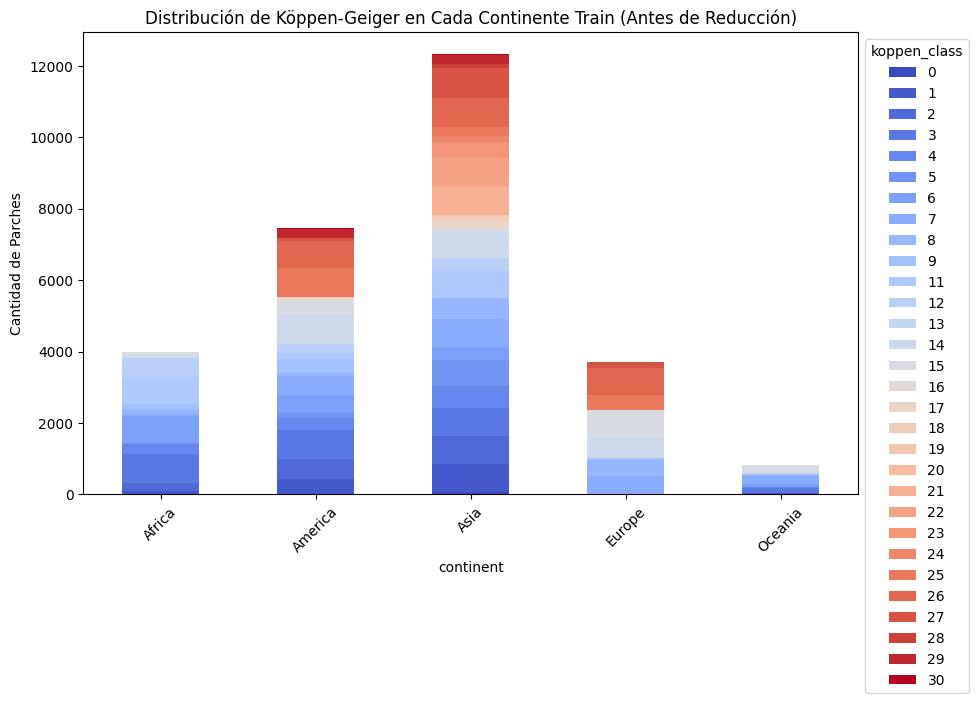

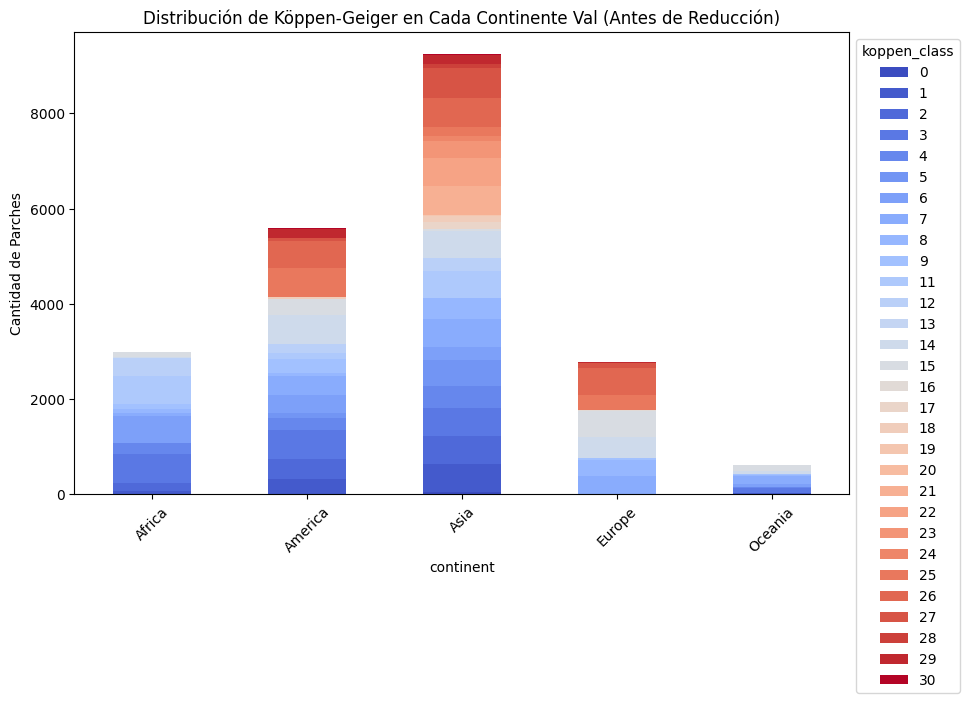

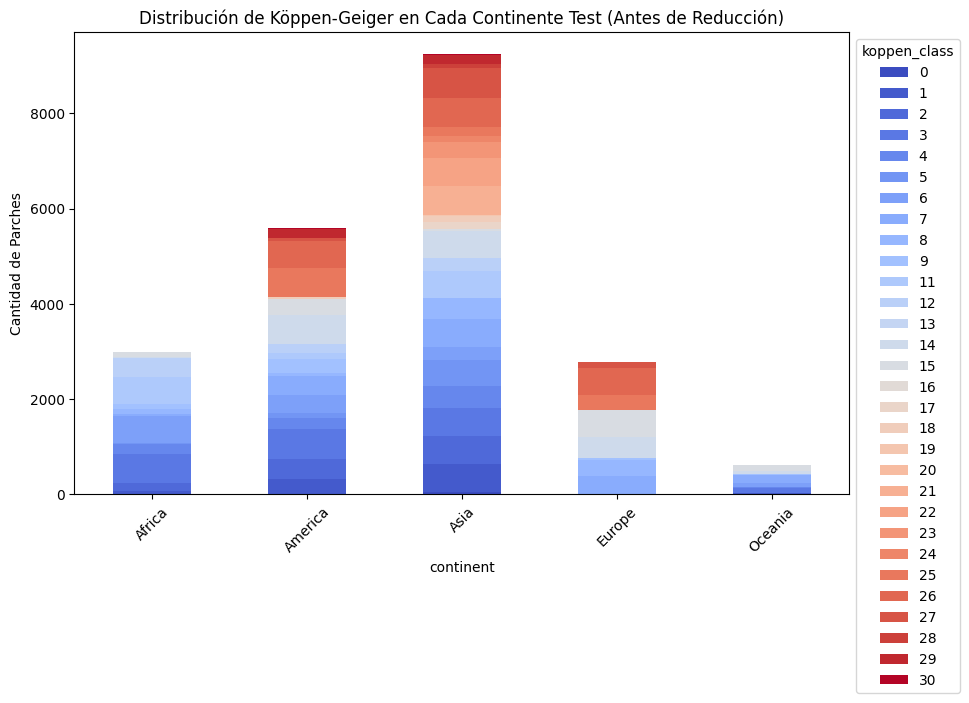

In [ ]:
plot_stacked_bar_count(
    df_train,
    group_col="continent",
    hue_col="koppen_class",
    title="Distribución de Köppen-Geiger en Cada Continente Train",
    palette="coolwarm"
)
plot_stacked_bar_count(
    df_val,
    group_col="continent",
    hue_col="koppen_class",
    title="Distribución de Köppen-Geiger en Cada Continente Val",
    palette="coolwarm"
)
plot_stacked_bar_count(
    df_test,
    group_col="continent",
    hue_col="koppen_class",
    title="Distribución de Köppen-Geiger en Cada Continente Test",
    palette="coolwarm"
)

# Pruebas KMeans

In [ ]:
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

In [ ]:
import pandas as pd
import os
import numpy as np
import rasterio
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
import time
import pickle

BATCHES = 5  # Número de lotes

class KMeansDataGenerator:
    def __init__(self, images_csv, img_dir, batch_size):
        self.img_paths = pd.read_csv(images_csv)['0'].tolist()
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.num_batches = (len(self.img_paths) + batch_size - 1) // batch_size  # Usar ceil division

    def __iter__(self):
        """Devuelve lotes de imágenes como arrays 2D de forma (batch_pixeles, 4)."""
        for i in range(self.num_batches):
            batch_paths = self.img_paths[i * self.batch_size: (i + 1) * self.batch_size]
            num_images_batch = len(batch_paths)
            X_batch = np.empty((num_images_batch * 256 * 256, 4), dtype=np.float32)

            for j, img_name in enumerate(batch_paths):
                img_path = os.path.join(self.img_dir, img_name)
                image = np.load(img_path)  # Cargar imagen (256, 256, 4)
                X_batch[j * 256 * 256: (j + 1) * 256 * 256] = image.reshape(-1, 4)

            yield X_batch

In [ ]:
batch_size = len(pd.read_csv('./dataset/images_train.csv')) // BATCHES  # 10 batches

kmeans = MiniBatchKMeans(n_clusters=2, random_state=42, n_init=100)

data_generator = KMeansDataGenerator('./dataset/images_train.csv', IMAGES_PATH, batch_size)

start_time = time.time()

for X_batch in tqdm(data_generator, total=BATCHES, desc="Entrenando K-Means"):
    kmeans.partial_fit(X_batch)  # Entrenamiento incremental

end_time = time.time()
print(f"Tiempo total de entrenamiento: {end_time - start_time:.2f} segundos")

with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

Entrenando K-Means: 6it [05:12, 52.02s/it]                       

Tiempo total de entrenamiento: 312.15 segundos


In [ ]:
import rasterio

def load_masks(masks_csv, mask_dir):
    # Leer las rutas de las máscaras desde el CSV
    mask_paths = pd.read_csv(masks_csv)['0'].tolist()
    num_masks = len(mask_paths)

    # Inicializar un array vacío para almacenar las máscaras
    y = np.empty((num_masks, 256, 256), dtype=np.int8)

    for i, mask_name in enumerate(mask_paths):
        mask_path = os.path.join(mask_dir, mask_name)
        with rasterio.open(mask_path) as src:
            mask = src.read(1)  # Leer solo el primer canal
        y[i] = mask.astype(np.int8)

    return y


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def evaluate_kmeans_with_generator(kmeans, data_generator, y):
    # Acumular las predicciones de cada batch
    pred_labels_list = []
    i=1
    for X_batch in data_generator:
        pred_labels_batch = kmeans.predict(X_batch)  # Predicción para este lote
        pred_labels_list.append(pred_labels_batch)
        print('Batch #', i, 'Terminado')
        i=i+1

    # Concatenar todas las predicciones
    pred_labels = np.concatenate(pred_labels_list, axis=0)

    # Asegurarse de que las máscaras también se alineen
    y = y.flatten()

    accuracy = accuracy_score(y, pred_labels)
    precision=precision_score(y, pred_labels, average='binary')
    recall=recall_score(y, pred_labels, average='binary')
    f1=f1_score(y, pred_labels, average='binary')
    jaccard=jaccard_score(y, pred_labels, average='binary')

    metrics = {
         "Accuracy": accuracy,
         "Precision": precision,
         "Recall": recall,
         "F1-Score": f1,
         "IoU": jaccard  # Jaccard = IoU
    }

    return metrics

In [ ]:
# Definir el batch size en función del número de imágenes y lotes deseados.
BATCHES = 5
eval_img_list = pd.read_csv('./dataset/images_train.csv')['0'].tolist()
eval_batch_size = len(eval_img_list) // BATCHES  # Usamos el mismo cálculo

data_generator_eval = KMeansDataGenerator('./dataset/images_train.csv', IMAGES_PATH, eval_batch_size)
y_train = load_masks('./dataset/masks_train.csv', MASKS_PATH)

with open("kmeans_model.pkl", "rb") as f:
    kmeans = pickle.load(f)
metrics = evaluate_kmeans_with_generator(kmeans, data_generator_eval, y_train)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Batch # 1 Terminado
Batch # 2 Terminado
Batch # 3 Terminado
Batch # 4 Terminado
Batch # 5 Terminado
Batch # 6 Terminado


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio

class KMeansDataGenerator:
    def __init__(self, images_csv, masks_csv, img_dir, mask_dir, batch_size):
        self.img_paths = pd.read_csv(images_csv)['0'].tolist()
        self.mask_paths = pd.read_csv(masks_csv)['0'].tolist()
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size

        # Asegurarse de que ambos CSV tengan la misma cantidad de entradas
        if len(self.img_paths) != len(self.mask_paths):
            raise ValueError("El número de imágenes y máscaras debe ser igual.")

        self.num_batches = (len(self.img_paths) + batch_size - 1) // batch_size  # División ceil

    def __iter__(self):
        for i in range(self.num_batches):
            batch_img_paths = self.img_paths[i * self.batch_size: (i + 1) * self.batch_size]
            batch_mask_paths = self.mask_paths[i * self.batch_size: (i + 1) * self.batch_size]
            num_images_batch = len(batch_img_paths)

            X_batch = np.empty((num_images_batch * 256 * 256, 4), dtype=np.float32)
            y_batch = np.empty((num_images_batch * 256 * 256,), dtype=np.int8)

            for j, (img_name, mask_name) in enumerate(zip(batch_img_paths, batch_mask_paths)):
                img_path = os.path.join(self.img_dir, img_name)
                mask_path = os.path.join(self.mask_dir, mask_name)

                # Cargar la imagen (.npy, shape: 256x256x4)
                image = np.load(img_path)
                # Cargar la máscara (por ejemplo, TIFF, se asume que tiene un solo canal y shape: 256x256)
                with rasterio.open(mask_path) as src:
                    mask = src.read(1)

                # Aplanar la imagen y la máscara y asignar al batch
                X_batch[j * 256 * 256: (j + 1) * 256 * 256] = image.reshape(-1, 4)
                y_batch[j * 256 * 256: (j + 1) * 256 * 256] = mask.reshape(-1)

            yield X_batch, y_batch

data_generator = KMeansDataGenerator('./dataset/images_train.csv', './dataset/masks_train.csv', IMAGES_PATH, MASKS_PATH, batch_size)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Inicializamos contadores acumulativos
total_correct = 0
total_samples = 0
TP = 0
FP = 0
FN = 0

for X_batch, y_batch in data_generator:
    pred_labels_batch = kmeans.predict(X_batch)

    # Acumular accuracy
    total_correct += np.sum(pred_labels_batch == y_batch.flatten())
    total_samples += y_batch.size

    # Acumular para precisión, recall, etc.
    TP += np.sum((pred_labels_batch == 1) & (y_batch.flatten() == 1))
    FP += np.sum((pred_labels_batch == 1) & (y_batch.flatten() == 0))
    FN += np.sum((pred_labels_batch == 0) & (y_batch.flatten() == 1))

    # Liberamos variables si se necesita
    del X_batch, y_batch, pred_labels_batch

# Calcular métricas globales:
accuracy = total_correct / total_samples
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "IoU": iou
}

print(metrics)


{'Accuracy': 0.6013781840868315, 'Precision': 0.00034876890030550507, 'Recall': 0.8959627674972721, 'F1-Score': 0.0006972663776941319, 'IoU': 0.00034875477633686594}


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import pickle
import matplotlib.pyplot as plt
import random

# Rutas a los archivos y directorios (modifica las rutas según corresponda)
IMAGE_CSV = './dataset/images_train.csv'
MASK_CSV = './dataset/masks_train.csv'

# Cargar las listas de nombres desde los CSV
img_list = pd.read_csv(IMAGE_CSV)['0'].tolist()
mask_list = pd.read_csv(MASK_CSV)['0'].tolist()

# Cargar el modelo kmeans previamente entrenado
with open("kmeans_model.pkl", "rb") as f:
    kmeans = pickle.load(f)

# Seleccionar 10 índices aleatorios para mostrar
num_samples = len(img_list)
indices = random.sample(range(num_samples), 10)

# Crear los subplots: 10 filas x 2 columnas
fig, axs = plt.subplots(10, 2, figsize=(10, 50))
fig.suptitle("Comparación de Máscaras: Original vs. Predicha por K-Means", fontsize=16)

# Iterar sobre los índices seleccionados
for i, idx in enumerate(indices):
    # Cargar la imagen original (archivo .npy, shape: 256x256x4)
    img_path = os.path.join(IMAGES_PATH, img_list[idx])
    image = np.load(img_path)

    # Generar la máscara predicha con K-Means:
    # Se aplanan los píxeles para obtener un array de forma (256*256, 4) y luego se predice.
    X = image.reshape(-1, 4)
    mask_pred = kmeans.predict(X).reshape(256, 256)

    # Cargar la máscara original (ground truth) usando rasterio
    mask_path = os.path.join(MASKS_PATH, mask_list[idx])
    with rasterio.open(mask_path) as src:
        mask_original = src.read(1)  # Se asume que la máscara está en el primer canal

    # Mostrar la máscara original en la columna izquierda
    axs[i, 0].imshow(mask_original, cmap='gray')
    axs[i, 0].set_title(f"Original idx {idx}")
    axs[i, 0].axis("off")

    # Mostrar la máscara predicha en la columna derecha
    axs[i, 1].imshow(mask_pred, cmap='gray')
    axs[i, 1].set_title(f"Predicha idx {idx}")
    axs[i, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Data generator

In [ ]:
import os
import pandas as pd
import rasterio
import numpy as np
import tensorflow
from tensorflow.keras.utils import to_categorical

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

MASK_ALGORITHM = 'Kumar-Roy'

MAX_PIXEL_VALUE = 65535

def get_img_762bands(path):
    img = rasterio.open(path).read((1, 2, 3)).transpose((1, 2, 0))
    ratio = np.divide(img[:,:,0], img[:,:,2], out=np.zeros_like(img[:,:,0], dtype=np.float32), where=(img[:,:,2] != 0))
    img = np.stack((img[:, :, 0], img[:, :, 1], img[:, :, 2], ratio), axis=-1)
    img = np.float32(img) / MAX_PIXEL_VALUE
    return img

def convert_to_one_hot(mask, num_classes=2):
        # Crea una máscara one-hot a partir de las máscaras binarias (0, 1)
        return np.squeeze(np.eye(num_classes)[mask.astype(int)])

class DataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, images_csv, masks_csv, batch_size, img_dir=IMAGES_PATH, mask_dir=MASKS_PATH, image_size=(256, 256)):
        # Leer las rutas de las imágenes y máscaras desde los CSV
        self.img_paths = pd.read_csv(images_csv)['0'].tolist()
        self.mask_paths = pd.read_csv(masks_csv)['0'].tolist()

        self.batch_size = batch_size
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_size = image_size

    def __len__(self):
        # Devuelve el número total de lotes por epoch
        return int(np.floor(len(self.img_paths) / self.batch_size))

    def __getitem__(self, idx):
        # Obtener el índice de lote
        batch_img_paths = self.img_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prealocar
        images = np.empty((self.batch_size, *self.image_size, 4), dtype=np.float32)  # suponiendo 4 canales
        masks  = np.empty((self.batch_size, *self.image_size, 2), dtype=np.uint8)    # one-hot representation

        # Cargar imágenes y máscaras por lotes
        for i, (img_name, mask_name) in enumerate(zip(batch_img_paths, batch_mask_paths)):
            img_path = os.path.join(self.img_dir, img_name)
            mask_path = os.path.join(self.mask_dir, mask_name)

            # Cargar imagen
            images[i] = np.load(img_path)

            # Usar with para cargar la máscara
            with rasterio.open(mask_path) as src:
                mask_raw = src.read(1)

            # Convertir la máscara a one hot
            masks[i] = to_categorical(mask_raw, num_classes=2)

        return images, masks

# Parámetros del generador
batch_size = 24
image_size = (256, 256)

# Inicializar generador de entrenamiento
train_generator = DataGenerator(images_csv='./dataset/images_train.csv',
                                masks_csv='./dataset/masks_train.csv',
                                batch_size=batch_size,
                                image_size=image_size)

val_generator = DataGenerator(images_csv='./dataset/images_val.csv',
                              masks_csv='./dataset/masks_val.csv',
                              batch_size=batch_size,
                              image_size=image_size)

test_generator = DataGenerator(images_csv='./dataset/images_test.csv',
                               masks_csv='./dataset/masks_test.csv',
                               batch_size=batch_size,
                               image_size=image_size)

KeyError: '0'

# Comparacion canales

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model
import pandas as pd
import cv2

MAX_PIXEL_VALUE = 65535

#Configuraciones
OUTPUT_DIR = './inferences4/'  # Carpeta para guardar los resultados

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def check_pixel_range(image_path):
    img=np.load(image_path)
    print(f"Rango de valores de píxel en Banda 7: {img[0].min()} - {img[0].max()}")
    print(f"Rango de valores de píxel en Banda 6: {img[1].min()} - {img[1].max()}")
    print(f"Rango de valores de píxel en Banda 2: {img[2].min()} - {img[2].max()}")

def demonstrate_pixel_composition(image_path, region_size=16):
    # Cargar la imagen en bandas 7, 6, 2
    with np.load(image_path) as src:
        img = src.read((1, 2, 3))  # Leer las bandas 7, 6, 2
        img = np.float32(img) / MAX_PIXEL_VALUE  # Normalizar a valores entre 0 y 1
        img = (img * 255).astype(np.uint8)

    # Encontrar el índice del píxel con el valor máximo en el canal R (banda 7)
    channel_r = img[0]  # Banda 7
    max_index = np.unravel_index(np.argmax(channel_r), channel_r.shape)
    y_center, x_center = max_index  # Coordenadas del píxel con mayor valor

    # Asegurarse de que la región no exceda los límites de la imagen
    half_size = region_size // 2
    x_min = max(0, x_center - half_size)
    x_max = min(channel_r.shape[1], x_center + half_size)
    y_min = max(0, y_center - half_size)
    y_max = min(channel_r.shape[0], y_center + half_size)

    # Extraer la región asegurando que se mantenga dentro de los límites
    region = img[:, y_min:y_max, x_min:x_max]

    # Preparar sub-imágenes con los valores de píxeles sobrepuestos
    fig, axs = plt.subplots(1, 4, figsize=(48, 32))

    # Mostrar la banda 7 (Rojo) con valores sobrepuestos
    axs[0].imshow(region[0], cmap='gray', vmin=0, vmax=255)
    axs[0].set_title('Banda 7 (Rojo)')
    for i in range(region.shape[1]):  # Usar region.shape[1] para iterar sobre la altura
        for j in range(region.shape[2]):  # Usar region.shape[2] para iterar sobre el ancho
            axs[0].text(j, i, f'{region[0, i, j]:.0f}', ha='center', va='center', color='red')

    # Mostrar la banda 6 (Verde) con valores sobrepuestos
    axs[1].imshow(region[1], cmap='gray', vmin=0, vmax=255)
    axs[1].set_title('Banda 6 (Verde)')
    for i in range(region.shape[1]):
        for j in range(region.shape[2]):
            axs[1].text(j, i, f'{region[1, i, j]:.0f}', ha='center', va='center', color='green')

    # Mostrar la banda 2 (Azul) con valores sobrepuestos
    axs[2].imshow(region[2], cmap='gray', vmin=0, vmax=255)
    axs[2].set_title('Banda 2 (Azul)')
    for i in range(region.shape[1]):
        for j in range(region.shape[2]):
            axs[2].text(j, i, f'{region[2, i, j]:.0f}', ha='center', va='center', color='blue')

    # Crear la imagen RGB final combinando las bandas
    rgb_image = np.stack([region[0], region[1], region[2]], axis=-1)

    # Mostrar la imagen RGB compuesta
    axs[3].imshow(rgb_image, vmin=0, vmax=255)
    axs[3].set_title('Imagen RGB Compuesta (Falso Color)')

    plt.tight_layout()
    plt.show()

def get_img_762bands(path):
    img = rasterio.open(path).read((1, 2, 3)).transpose((1, 2, 0))
    img = np.float32(img) / MAX_PIXEL_VALUE  # Normalización
    return (img * 255).astype(np.uint8)

# Obtener las rutas de las imágenes y las máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['images'].tolist()
mask_paths = pd.read_csv(masks_csv)['masks'].tolist()

c=0;

for img_name, mask_name in zip(img_paths, mask_paths):
    c = c + 1
    if c > 20:
      break

    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Llama a la función con la ruta de tu imagen
    check_pixel_range(img_path)

    # Cargar la imagen y la máscara
    image = get_img_762bands(img_path)
    #mask = rasterio.open(mask_path).read(1)#.transpose((1, 2, 0))
    #mask = np.float32(mask)

    plt.figure(figsize=(24, 16))

    # Mostrar imagen original
    plt.subplot(1, 4, 1)
    plt.imshow(image[:,:,0], cmap='gray', vmin=0, vmax=255)
    plt.title('Canal R (Banda 7 SWIR-2)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(image[:,:,1], cmap='gray', vmin=0, vmax=255)
    plt.title('Canal G (Banda 6 SWIR-1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(image[:,:,2], cmap='gray', vmin=0, vmax=255)
    plt.title('Canal B (Banda 2 Blue)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(image[:, :, [0, 1, 2]], vmin=0, vmax=255)
    plt.title('Falso Color')
    plt.axis('off')

    plt.show()
    plt.close()

    # Guardar cada canal de la imagen como un archivo en blanco y negro
    for i in range(3):  # Suponiendo que tienes 3 canales
        channel_image = (image[:, :, i] * 255).astype(np.uint8)  # Convertir a uint8 para OpenCV
        channel_output_path = os.path.join(OUTPUT_DIR, f'{img_name}_canal_{i + 1}.png')

        # Guardar la imagen del canal sin bordes ni títulos
        cv2.imwrite(channel_output_path, channel_image)

    # Llama a la función con tu imagen
    demonstrate_pixel_composition(img_path, region_size=16)

    plt.figure(figsize=(12, 12))
    plt.plot()
    plt.imshow(image[:,:,0], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

    # Guardar la figura
    output_file = os.path.join(OUTPUT_DIR, f'CanalRed_{os.path.basename(img_name)}.png')
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()  # Cerrar la figura para liberar memoria

    # plt.figure(figsize=(12, 12))
    # plt.plot()
    # plt.imshow(image[:,:,1], cmap='gray')
    # plt.axis('off')

    # # Guardar la figura
    # output_file = os.path.join(OUTPUT_DIR, f'Chanel2_{os.path.basename(img_name)}.png')
    # plt.tight_layout()
    # plt.savefig(output_file)
    # plt.close()  # Cerrar la figura para liberar memoria

    # plt.figure(figsize=(12, 12))
    # plt.plot()
    # plt.imshow(image[:,:,2], cmap='gray')
    # plt.axis('off')

    # # Guardar la figura
    # output_file = os.path.join(OUTPUT_DIR, f'Chanel3_{os.path.basename(img_name)}.png')
    # plt.tight_layout()
    # plt.savefig(output_file)
    # plt.close()  # Cerrar la figura para liberar memoria

# Definicion del modelo

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(nClasses, input_height=256, input_width=256, n_filters = 16, dropout = 0.1, batchnorm = True, n_channels=4):
    input_img = Input(shape=(input_height,input_width, n_channels))

    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(2, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

def get_unet_small (nClasses, input_height=128, input_width=128, n_filters = 16, dropout = 0.1, batchnorm = True, n_channels=3):

    input_img = Input(shape=(input_height,input_width, n_channels))

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters = n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c3)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(2, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

def conv2d_block_m(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x1 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)

    # second layer
    x2 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x1) # No se si esta capa debe tener de entrada 'input_tensor' o 'x1'
    if batchnorm:
        x2 = BatchNormalization()(x2)
    x = concatenate([x1, x2])
    x = Activation("relu")(x)
    return x

def up2d_block_m(input_tensor, n_filters, batchnorm = True):
    x = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def get_multiscalenet (nClasses, input_height=256, input_width=256, n_filters = 16, dropout = 0.1, batchnorm = True, n_channels=4):
    input_img = Input(shape=(input_height,input_width, n_channels))

    # Contracting Path
    b1 = conv2d_block_m(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm) # x32
    b2 = conv2d_block_m(input_img, n_filters * 1, kernel_size = 5, batchnorm = batchnorm) # x32
    b3 = conv2d_block_m(input_img, n_filters * 1, kernel_size = 7, batchnorm = batchnorm) # x32

    c1 = concatenate([b1, b2, b3]) # x96
    p1 = MaxPooling2D((2,2))(c1) # 128x128

    b1 = conv2d_block_m(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm) # x64
    b2 = conv2d_block_m(p1, n_filters * 2, kernel_size = 5, batchnorm = batchnorm) # x64
    b3 = conv2d_block_m(p1, n_filters * 2, kernel_size = 7, batchnorm = batchnorm) # x64

    c2 = concatenate([b1, b2, b3]) # x192
    p2 = MaxPooling2D((2,2))(c2) # 64x64

    b1 = conv2d_block_m(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm) # 128
    b2 = conv2d_block_m(p2, n_filters * 4, kernel_size = 5, batchnorm = batchnorm) # 128
    b3 = conv2d_block_m(p2, n_filters * 4, kernel_size = 7, batchnorm = batchnorm) # 128

    c3 = concatenate([b1, b2, b3]) # 384
    p3 = MaxPooling2D((2,2))(c3) # 32x32

    b1 = conv2d_block_m(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm) # 256
    b2 = conv2d_block_m(p3, n_filters * 8, kernel_size = 5, batchnorm = batchnorm) # 256
    b3 = conv2d_block_m(p3, n_filters * 8, kernel_size = 7, batchnorm = batchnorm) # 256

    c4 = concatenate([b1, b2, b3]) # 768
    p4 = MaxPooling2D((2,2))(c4) # 16x16

    b1 = conv2d_block_m(p4, n_filters * 16, kernel_size = 3, batchnorm = batchnorm) # 512
    b2 = conv2d_block_m(p4, n_filters * 16, kernel_size = 5, batchnorm = batchnorm) # 512
    b3 = conv2d_block_m(p4, n_filters * 16, kernel_size = 7, batchnorm = batchnorm) # 512

    c5 = concatenate([b1, b2, b3]) # 1536
    #p5 = MaxPooling2D((2,2))(c5)

    # Expansive Path

    t6 = up2d_block_m(c5, n_filters * 8, batchnorm) # 128
    ibc1 = concatenate([t6, c4]) # 896
    b1 = conv2d_block_m(ibc1, n_filters * 8, kernel_size = 3, batchnorm = batchnorm) # 256
    b2 = conv2d_block_m(ibc1, n_filters * 8, kernel_size = 5, batchnorm = batchnorm) # 256
    b3 = conv2d_block_m(ibc1, n_filters * 8, kernel_size = 7, batchnorm = batchnorm) # 256

    c6 = concatenate([b1, b2, b3]) # 768

    t7 = up2d_block_m(c6, n_filters * 4, batchnorm) # 64
    ibc2 = concatenate([t7, c3]) # 448
    b1 = conv2d_block_m(ibc2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm) # 128
    b2 = conv2d_block_m(ibc2, n_filters * 4, kernel_size = 5, batchnorm = batchnorm) # 128
    b3 = conv2d_block_m(ibc2, n_filters * 4, kernel_size = 7, batchnorm = batchnorm) # 128

    c7 = concatenate([b1, b2, b3]) # 384

    t8 = up2d_block_m(c7, n_filters * 2, batchnorm) # 32
    ibc3 = concatenate([t8, c2]) # 224
    b1 = conv2d_block_m(ibc3, n_filters * 2, kernel_size = 3, batchnorm = batchnorm) # 64
    b2 = conv2d_block_m(ibc3, n_filters * 2, kernel_size = 5, batchnorm = batchnorm) # 64
    b3 = conv2d_block_m(ibc3, n_filters * 2, kernel_size = 7, batchnorm = batchnorm) # 64

    c8 = concatenate([b1, b2, b3]) # 192

    t9 = up2d_block_m(c8, n_filters * 1, batchnorm) # 16
    ibc4 = concatenate([t9, c1]) # 112
    b1 = conv2d_block_m(ibc4, n_filters * 1, kernel_size = 3, batchnorm = batchnorm) # 32
    b2 = conv2d_block_m(ibc4, n_filters * 1, kernel_size = 5, batchnorm = batchnorm) # 32
    b3 = conv2d_block_m(ibc4, n_filters * 1, kernel_size = 7, batchnorm = batchnorm) # 32

    c9 = concatenate([b1, b2, b3]) # 96
    d9 = Dropout(dropout)(c9)

    #outputs = Conv2D(1, (1, 1), activation='relu')(d9)
    outputs = Conv2D(2, (1, 1), activation='softmax')(d9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Construccion del modulo SDI

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = K.int_shape(input_feature)[channel_axis]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    # Global Average Pooling
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    # Global Max Pooling
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    # Combine
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return multiply([input_feature, cbam_feature])

# Spatial Attention (similar to the cbam_block style)
def spatial_attention(input_feature):
    kernel_size = 7
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature

    # Channel-wise mean and max pooling
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(cbam_feature)

    # Concatenate mean and max pooled features
    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    # Apply Conv2D for spatial attention
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    return multiply([input_feature, cbam_feature])

# Función para ajustar las características mediante pooling adaptativo, identidad o interpolación bilineal
def adjust_features(f_j, target_shape, i, j):
    target_h, target_w = target_shape[1:3]
    f_j_h, f_j_w = K.int_shape(f_j)[1:3]

    # Si j < i, aplicamos pooling adaptativo promedio para reducir la resolución
    if j < i:
        pooling_size = (f_j_h // target_h, f_j_w // target_w)
        f_j = AveragePooling2D(pool_size=pooling_size)(f_j)

    # Si j > i, aplicamos interpolación bilineal para aumentar la resolución
    elif j > i:
        f_j = UpSampling2D(size=(target_h // f_j_h, target_w // f_j_w), interpolation='bilinear')(f_j)

    # Si j == i, no hacemos nada (identity mapping)

    return f_j

# SDI Module multinivel
def SDI_module(features_list, channels_list,ratio=8):
    # Lista para guardar las características refinadas de cada nivel
    refined_features = []

    # Iteramos sobre cada nivel de características
    for i in range(len(features_list)):
        # Características de nivel i
        f_i = features_list[i]

        # 1. Aplicar atención de canal y espacial a las características f_i^0
        f_i = channel_attention(f_i, ratio=ratio)
        f_i = spatial_attention(f_i)

        # 2. Aplicar convolución 1x1 para reducir los canales de f_i^1 a c, obteniendo f_i^2
        f_i = Conv2D(filters=channels_list[i], kernel_size=1, padding='same')(f_i)

        # Lista para almacenar las características ajustadas en este nivel i
        resized_features = []

        # 3. Ajustar la resolución de las características de cada nivel j a la resolución del nivel i
        for j in range(len(features_list)):
            f_j = features_list[j]
            f_ij = adjust_features(f_j, K.int_shape(f_i), i, j)

            # 4. Aplicar una convolución 3x3 para suavizar las características ajustadas, obteniendo f_ij^4
            f_ij = Conv2D(filters=channels_list[i], kernel_size=3, padding='same', activation=None)(f_ij)

            # Añadir el mapa de características suavizado a la lista
            resized_features.append(f_ij)

        # 5. Fusionar las características suavizadas mediante el producto de Hadamard, obteniendo f_i^5
        f_i5 = resized_features[0]
        for f_j4 in resized_features[1:]:
            f_i5 = Multiply()([f_i5, f_j4])

        # Añadir las características refinadas de nivel i a la lista
        refined_features.append(f_i5)

    # Devolver las características refinadas para cada nivel
    return refined_features

def get_Unet_v2(nClasses, input_height=256, input_width=256, n_filters = 16, dropout = 0.1, batchnorm = True, n_channels=4):
    input_img = Input(shape=(input_height, input_width, n_channels))

    # Contracting Path (codificador)
    b1 = conv2d_block_m(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm) # x32
    b2 = conv2d_block_m(input_img, n_filters * 1, kernel_size=5, batchnorm=batchnorm) # x32
    b3 = conv2d_block_m(input_img, n_filters * 1, kernel_size=7, batchnorm=batchnorm) # x32

    c1 = concatenate([b1, b2, b3]) # x96
    p1 = MaxPooling2D((2, 2))(c1) # 128x128

    b1 = conv2d_block_m(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm) # x64
    b2 = conv2d_block_m(p1, n_filters * 2, kernel_size=5, batchnorm=batchnorm) # x64
    b3 = conv2d_block_m(p1, n_filters * 2, kernel_size=7, batchnorm=batchnorm) # x64

    c2 = concatenate([b1, b2, b3]) # x192
    p2 = MaxPooling2D((2, 2))(c2) # 64x64

    b1 = conv2d_block_m(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm) # 128
    b2 = conv2d_block_m(p2, n_filters * 4, kernel_size=5, batchnorm=batchnorm) # 128
    b3 = conv2d_block_m(p2, n_filters * 4, kernel_size=7, batchnorm=batchnorm) # 128

    c3 = concatenate([b1, b2, b3]) # 384
    p3 = MaxPooling2D((2, 2))(c3) # 32x32

    b1 = conv2d_block_m(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm) # 256
    b2 = conv2d_block_m(p3, n_filters * 8, kernel_size=5, batchnorm=batchnorm) # 256
    b3 = conv2d_block_m(p3, n_filters * 8, kernel_size=7, batchnorm=batchnorm) # 256

    c4 = concatenate([b1, b2, b3]) # 768
    p4 = MaxPooling2D((2, 2))(c4) # 16x16

    b1 = conv2d_block_m(p4, n_filters * 16, kernel_size=3, batchnorm=batchnorm) # 512
    b2 = conv2d_block_m(p4, n_filters * 16, kernel_size=5, batchnorm=batchnorm) # 512
    b3 = conv2d_block_m(p4, n_filters * 16, kernel_size=7, batchnorm=batchnorm) # 512

    c5 = concatenate([b1, b2, b3]) # 1536
    #p5 = MaxPooling2D((2,2))(c5)

    # SDI module: Llamamos al módulo una vez para todas las características
    channels = [n_filters * 1, n_filters * 2, n_filters * 4, n_filters * 8, n_filters * 16]

    refined_features = SDI_module([c1, c2, c3, c4, c5], channels)

    # Expansive Path (decodificador) - Usamos las características refinadas
    t6 = up2d_block_m(refined_features[4], n_filters * 8, batchnorm) # 128
    ibc1 = concatenate([t6, refined_features[3]]) # 896
    b1 = conv2d_block_m(ibc1, n_filters * 8, kernel_size=3, batchnorm=batchnorm) # 256
    b2 = conv2d_block_m(ibc1, n_filters * 8, kernel_size=5, batchnorm=batchnorm) # 256
    b3 = conv2d_block_m(ibc1, n_filters * 8, kernel_size=7, batchnorm=batchnorm) # 256

    c6 = concatenate([b1, b2, b3]) # 768

    t7 = up2d_block_m(c6, n_filters * 4, batchnorm) # 64
    ibc2 = concatenate([t7, refined_features[2]]) # 448
    b1 = conv2d_block_m(ibc2, n_filters * 4, kernel_size=3, batchnorm=batchnorm) # 128
    b2 = conv2d_block_m(ibc2, n_filters * 4, kernel_size=5, batchnorm=batchnorm) # 128
    b3 = conv2d_block_m(ibc2, n_filters * 4, kernel_size=7, batchnorm=batchnorm) # 128

    c7 = concatenate([b1, b2, b3]) # 384

    t8 = up2d_block_m(c7, n_filters * 2, batchnorm) # 32
    ibc3 = concatenate([t8, refined_features[1]]) # 224
    b1 = conv2d_block_m(ibc3, n_filters * 2, kernel_size=3, batchnorm=batchnorm) # 64
    b2 = conv2d_block_m(ibc3, n_filters * 2, kernel_size=5, batchnorm=batchnorm) # 64
    b3 = conv2d_block_m(ibc3, n_filters * 2, kernel_size=7, batchnorm=batchnorm) # 64

    c8 = concatenate([b1, b2, b3]) # 192

    t9 = up2d_block_m(c8, n_filters * 1, batchnorm) # 16
    ibc4 = concatenate([t9, refined_features[0]]) # 112
    b1 = conv2d_block_m(ibc4, n_filters * 1, kernel_size=3, batchnorm=batchnorm) # 32
    b2 = conv2d_block_m(ibc4, n_filters * 1, kernel_size=5, batchnorm=batchnorm) # 32
    b3 = conv2d_block_m(ibc4, n_filters * 1, kernel_size=7, batchnorm=batchnorm) # 32

    c9 = concatenate([b1, b2, b3]) # 96
    d9 = Dropout(dropout)(c9)

    outputs = Conv2D(2, (1, 1), activation='softmax')(d9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

def get_Unet_v2_small(nClasses, input_height=256, input_width=256, n_filters=16, dropout=0.1, batchnorm=True, n_channels=4):
    input_img = Input(shape=(input_height, input_width, n_channels))

    # Contracting Path (Codificador)
    b1 = conv2d_block_m(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)  # x32
    b2 = conv2d_block_m(input_img, n_filters * 1, kernel_size=5, batchnorm=batchnorm)  # x32
    #b3 = conv2d_block_m(input_img, n_filters * 1, kernel_size=7, batchnorm=batchnorm)  # x32

    c1 = concatenate([b1, b2])  # x96
    p1 = MaxPooling2D((2, 2))(c1)  # 128x128

    b1 = conv2d_block_m(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)  # x64
    b2 = conv2d_block_m(p1, n_filters * 2, kernel_size=5, batchnorm=batchnorm)  # x64
    #b3 = conv2d_block_m(p1, n_filters * 2, kernel_size=7, batchnorm=batchnorm)  # x64

    c2 = concatenate([b1, b2])  # x192
    p2 = MaxPooling2D((2, 2))(c2)  # 64x64

    b1 = conv2d_block_m(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)  # x128
    b2 = conv2d_block_m(p2, n_filters * 4, kernel_size=5, batchnorm=batchnorm)  # x128
    #b3 = conv2d_block_m(p2, n_filters * 4, kernel_size=7, batchnorm=batchnorm)  # x128

    c3 = concatenate([b1, b2])  # x384

    # SDI module: Refinamiento de características
    channels = [n_filters * 1, n_filters * 2, n_filters * 4]
    refined_features = SDI_module([c1, c2, c3], channels)

    # Expansive Path (Decodificador)
    t4 = up2d_block_m(refined_features[2], n_filters * 2, batchnorm)  # x64
    ibc1 = concatenate([t4, refined_features[1]])  # x256
    b1 = conv2d_block_m(ibc1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)  # x64
    b2 = conv2d_block_m(ibc1, n_filters * 2, kernel_size=5, batchnorm=batchnorm)  # x64
    #b3 = conv2d_block_m(ibc1, n_filters * 2, kernel_size=7, batchnorm=batchnorm)  # x64
    c4 = concatenate([b1, b2])  # x192

    t5 = up2d_block_m(c4, n_filters * 1, batchnorm)  # x32
    ibc2 = concatenate([t5, refined_features[0]])  # x128
    b1 = conv2d_block_m(ibc2, n_filters * 1, kernel_size=3, batchnorm=batchnorm)  # x32
    b2 = conv2d_block_m(ibc2, n_filters * 1, kernel_size=5, batchnorm=batchnorm)  # x32
    #b3 = conv2d_block_m(ibc2, n_filters * 1, kernel_size=7, batchnorm=batchnorm)  # x32
    c5 = concatenate([b1, b2])  # x96

    d5 = Dropout(dropout)(c5)
    outputs = Conv2D(2, (1, 1), activation="softmax")(d5)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

def get_unet_small_sdi (nClasses, input_height=128, input_width=128, n_filters = 16, dropout = 0.1, batchnorm = True, n_channels=3):

    input_img = Input(shape=(input_height,input_width, n_channels))

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters = n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    refined_features = SDI_module([c1, c2, c3], [n_filters * 1, n_filters * 2, n_filters * 4])

    # Expansive Path
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(refined_features[2])
    u8 = concatenate([u8, refined_features[1]])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, refined_features[0]])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(2, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

def get_unet_sdi(nClasses, input_height=256, input_width=256, n_filters=16, dropout=0.1, batchnorm=True, n_channels=10):
    input_img = Input(shape=(input_height, input_width, n_channels))

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # SDI Module
    refined_features = SDI_module([c1, c2, c3, c4, c5], [n_filters * 1, n_filters * 2, n_filters * 4, n_filters * 8, n_filters * 16])

    # Expansive Path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(refined_features[4])
    u6 = concatenate([u6, refined_features[3]])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, refined_features[2]])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, refined_features[1]])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, refined_features[0]], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(2, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

def get_model(model_name, nClasses=1, input_height=128, input_width=128, n_filters = 16, dropout = 0.1, batchnorm = True, n_channels=10):
    if model_name == 'unet':
        model = get_unet
    elif model_name == 'unet_sdi':
        model = get_unet_sdi
    elif model_name == 'unet_small':
        model = get_unet_small
    elif model_name == 'unet_small_sdi':
        model = get_unet_small_sdi
    elif model_name == 'multiscale_net':
        model = get_multiscalenet
    elif model_name == 'unet_v2':
        model = get_Unet_v2
    elif model_name == 'unet_v2_small':
        model = get_Unet_v2_small

    return model(
            nClasses      = nClasses,
            input_height  = input_height,
            input_width   = input_width,
            n_filters     = n_filters,
            dropout       = dropout,
            batchnorm     = batchnorm,
            n_channels    = n_channels
        )

# Librerias para entrenamiento

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import glob
import matplotlib.pyplot as plt

from tensorflow.python.keras.backend import set_session
import keras
# from keras import optimizers
from keras._tf_keras.keras.optimizers import *
from keras._tf_keras.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, IoU
from tensorflow.python.keras import backend as K
import keras._tf_keras.keras.backend as bk
import sys

from keras.src.legacy.preprocessing.image import ImageDataGenerator

# Metrica F1Score

In [ ]:
import tensorflow
class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convertimos y_pred a etiquetas de clase (0 o 1) usando argmax para la salida softmax(2)
        y_pred = tensorflow.argmax(y_pred, axis=-1)  # Predicciones en clase (0 o 1)
        y_true = tensorflow.argmax(y_true, axis=-1)  # Ground truth en clase (0 o 1)

        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()

def precision(y_true, y_pred):
    y_pred = tensorflow.argmax(y_pred, axis=-1)  # Convertir predicciones one-hot a etiquetas
    y_true = tensorflow.argmax(y_true, axis=-1)  # Convertir etiquetas one-hot a etiquetas
    return precision_metric(y_true, y_pred)

def recall(y_true, y_pred):
    y_pred = tensorflow.argmax(y_pred, axis=-1)  # Convertir predicciones one-hot a etiquetas
    y_true = tensorflow.argmax(y_true, axis=-1)  # Convertir etiquetas one-hot a etiquetas
    return recall_metric(y_true, y_pred)

# Entrenamiento y Pruebas Unet Small

In [ ]:
N_FILTERS = 16
N_CHANNELS = 4

EPOCHS = 30
IMAGE_SIZE = (256, 256)
MODEL_NAME = 'unet_small'

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset//masks/patches/'

OUTPUT_DIR = './train_output/'

EARLY_STOP_PATIENCE = 10

CHECKPOINT_PERIOD = 10
CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM)

# If not zero will be load as weights
INITIAL_EPOCH = 0
RESTART_FROM_CHECKPOINT = None
if INITIAL_EPOCH > 0:
    RESTART_FROM_CHECKPOINT = os.path.join(OUTPUT_DIR, 'checkpoint-{}-{}-epoch_{:02d}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM, INITIAL_EPOCH))

FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, MASK_ALGORITHM)

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = [CategoricalAccuracy(), Precision(), Recall(), MeanIoU(num_classes=2), F1Score()])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1)


print('Training using {}...'.format(MASK_ALGORITHM))

# Entrenamiento del modelo (las imágenes ya están en 256x256, no necesitamos redimensionar)
history = model.fit(
    x=train_generator,  # Generador de entrenamiento
    validation_data=val_generator,  # Generador de validación
    epochs=EPOCHS,
    workers=2,
    use_multiprocessing=True,
    callbacks=[checkpoint, early_stopping],  # Guardar el mejor modelo y detener el entrenamiento temprano
    verbose=1,
)

# Guardar el modelo final
model.save('Unet_small_final_model.h5')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 256, 256, 16)   │            592 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 256, 256, 16)   │             64 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 256, 256, 16)   │             64 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 128, 128, 16)   │              0 │ activation_11[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 128, 16)   │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 128, 128, 16)   │             64 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 128, 128, 16)   │             64 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (Activation)         

 Total params: 50,002 (195.32 KB)

 Trainable params: 49,618 (193.82 KB)

 Non-trainable params: 384 (1.50 KB)

Training using Kumar-Roy...
Epoch 1/30
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - categorical_accuracy: 0.9650 - f1_score: 3.6096e-04 - loss: 0.1345 - mean_io_u_1: 0.2500 - precision_2: 0.9650 - recall_2: 0.9650
Epoch 1: val_loss improved from inf to 0.00241, saving model to best_model.keras
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 859s 709ms/step - categorical_accuracy: 0.9651 - f1_score: 3.6104e-04 - loss: 0.1345 - mean_io_u_1: 0.2500 - precision_2: 0.9651 - recall_2: 0.9651 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.0513 - val_loss: 0.0024 - val_mean_io_u_1: 0.2500 - val_precision_2: 0.9999 - val_recall_2: 0.9999
Epoch 2/30
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - categorical_accuracy: 0.9999 - f1_score: 0.2241 - loss: 0.0019 - mean_io_u_1: 0.2500 - precision_2: 0.9999 - recall_2: 0.9999
Epoch 2: val_loss improved from 0.00241 to 0.00072, saving model to best_model.keras
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 784s 665ms/step - categorical_accuracy: 0.9999 - f1_score: 0.2242 - loss

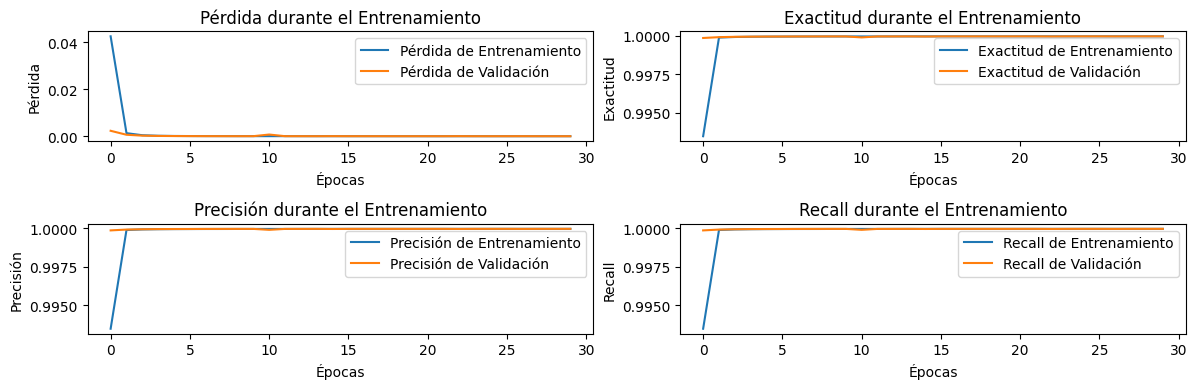

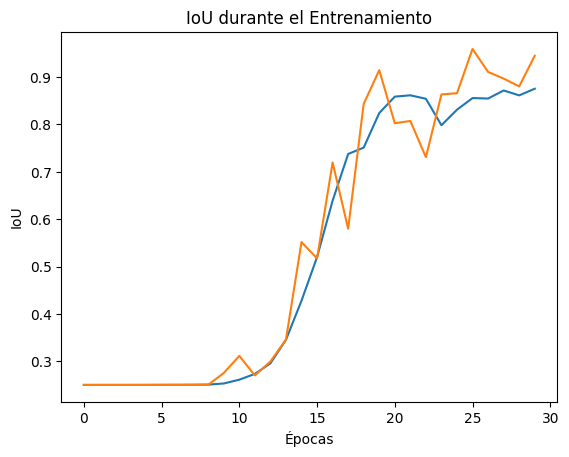

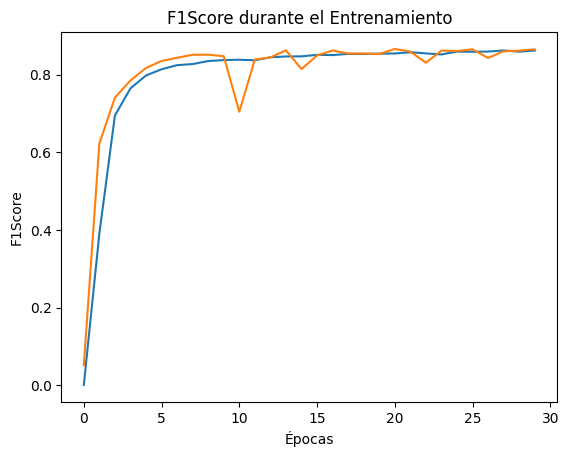

In [ ]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Exactitud
plt.subplot(2, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Exactitud de Entrenamiento')
plt.plot(history.history['val_categorical_accuracy'], label='Exactitud de Validación')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Precisión
plt.subplot(2, 2, 3)
plt.plot(history.history['precision_2'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision_2'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall_2'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall_2'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# IoU
plt.plot(history.history['mean_io_u_1'], label='IoU de Entrenamiento')
plt.plot(history.history['val_mean_io_u_1'], label='IoU de Validación')
plt.title('IoU durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.show()

# F1Score
plt.plot(history.history['f1_score'], label='F1 de Entrenamiento')
plt.plot(history.history['val_f1_score'], label='F1 de Validación')
plt.title('F1Score durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('F1Score')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

MODEL_PATH = './drive/MyDrive/Tesis/Unet_small_final_model.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 21228/21228 [55:23<00:00,  6.39it/s]


Precision: 0.89547193
Recall: 0.8410081
Accuracy: 0.9999841
IoU: 0.7658264
F1-Score: 0.86738586


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model

# Expresión regular y función para extraer la información del nombre del archivo .npy
filename_regex = re.compile(r"^(LC08_(?:L1TP|L1GT|L1GS)_\d{3}\d{3}_\d{8}_\d{8}_\d{2}_\w+_p\d{5})_(\d+)_(\w+)\.npy$")

def parse_npy_filename(filename):
    match = filename_regex.match(filename)
    if match:
        base_name, koppen_class, continent = match.groups()
        return filename, base_name, int(koppen_class), continent
    return None

# Función para clasificar el grupo de píxeles según el conteo de píxeles con valor 1 en la máscara
def get_pixel_group_from_mask(mask):
    count = np.sum(mask == 1)
    if count <= 130:
        return '0-130'
    elif count <= 618:
        return '131-618'
    else:
        return '618+'

# Rutas de CSV con las rutas de imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

# Cargar las rutas desde los CSV
img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

# Rutas base donde se encuentran las imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Configuraciones del modelo
MODEL_PATH = './drive/MyDrive/Tesis/Unet_small_final_model.h5'
OUTPUT_DIR = './inferences/'  # Carpeta para guardar los resultados (opcional)

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Cargar el modelo
model = load_model(MODEL_PATH)

# Diccionario o conjunto para rastrear las combinaciones ya mostradas (Koppen, pixel_group)
displayed_combinations = set()

# Iterar sobre cada par de imagen y máscara usando las rutas obtenidas desde CSV
for img_name, mask_name in zip(img_paths, mask_paths):
    # Extraer la clase Koppen desde el nombre de la imagen
    parsed = parse_npy_filename(img_name)
    if parsed is None:
        continue  # Saltar si el nombre no coincide con el formato esperado
    _, _, koppen_class, _ = parsed
    koppen_class_str = str(koppen_class)

    # Construir las rutas completas y cargar imagen y máscara
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1)
    mask = np.float32(mask)

    # Obtener el grupo de píxeles contando los píxeles con valor 1 en la máscara
    pixel_group = get_pixel_group_from_mask(mask)

    # Combinación única de Koppen y grupo de píxeles
    combination = (koppen_class_str, pixel_group)
    if combination in displayed_combinations:
        continue  # Si ya se mostró esta combinación, continuar
    displayed_combinations.add(combination)

    # Realizar la inferencia con el modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1)

    # Mostrar los resultados: imagen original, ground truth y predicción
    plt.figure(figsize=(12, 8))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, :3])
    plt.title(f'Imagen Original - Koppen: {koppen_class_str} - Grupo: {pixel_group}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 3)
    plt.imshow(pred_class, cmap='gray')
    plt.title('Predicción')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Unet_Small SDI

In [ ]:
N_FILTERS = 16
N_CHANNELS = 4

EPOCHS = 30
IMAGE_SIZE = (256, 256)
MODEL_NAME = 'unet_small_sdi'

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset//masks/patches/'

OUTPUT_DIR = './train_output/'

EARLY_STOP_PATIENCE = 10

CHECKPOINT_PERIOD = 10
CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM)

# If not zero will be load as weights
INITIAL_EPOCH = 0
RESTART_FROM_CHECKPOINT = None
if INITIAL_EPOCH > 0:
    RESTART_FROM_CHECKPOINT = os.path.join(OUTPUT_DIR, 'checkpoint-{}-{}-epoch_{:02d}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM, INITIAL_EPOCH))

FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, MASK_ALGORITHM)

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = [CategoricalAccuracy(), Precision(), Recall(), MeanIoU(num_classes=2), F1Score()])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1)


print('Training using {}...'.format(MASK_ALGORITHM))

# Entrenamiento del modelo (las imágenes ya están en 256x256, no necesitamos redimensionar)
history = model.fit(
    x=train_generator,  # Generador de entrenamiento
    validation_data=val_generator,  # Generador de validación
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping],  # Guardar el mejor modelo y detener el entrenamiento temprano
    verbose=1,
)

# Guardar el modelo final
model.save('Unet_small_sdi_final_model.h5')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 256, 256, 16)   │            592 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 256, 256, 16)   │             64 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 256, 256, 16)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 256, 256, 16)   │             64 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 256, 256, 16)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 16)   │              0 │ activation_21[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128, 128, 16)   │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 128, 128, 16)   │             64 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_22             │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ activation_22[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 128, 128, 16)   │             64 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_23             │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
│ (Activation)         

 Total params: 126,370 (493.63 KB)

 Trainable params: 125,986 (492.13 KB)

 Non-trainable params: 384 (1.50 KB)

Training using Kumar-Roy...
Epoch 1/30
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - categorical_accuracy: 0.9991 - f1_score: 0.9991 - loss: 0.0457 - mean_io_u_4: 0.2501 - precision_8: 0.9991 - recall_8: 0.9991
Epoch 1: val_loss improved from inf to 0.00073, saving model to best_model.keras
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 851s 700ms/step - categorical_accuracy: 0.9991 - f1_score: 0.9991 - loss: 0.0457 - mean_io_u_4: 0.2501 - precision_8: 0.9991 - recall_8: 0.9991 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.9999 - val_loss: 7.2956e-04 - val_mean_io_u_4: 0.2500 - val_precision_8: 0.9999 - val_recall_8: 0.9999
Epoch 2/30
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - categorical_accuracy: 0.9999 - f1_score: 0.9999 - loss: 5.9243e-04 - mean_io_u_4: 0.2500 - precision_8: 0.9999 - recall_8: 0.9999
Epoch 2: val_loss improved from 0.00073 to 0.00031, saving model to best_model.keras
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 862s 732ms/step - categorical_accuracy: 0.9999 - f1_score: 0.9999 - loss

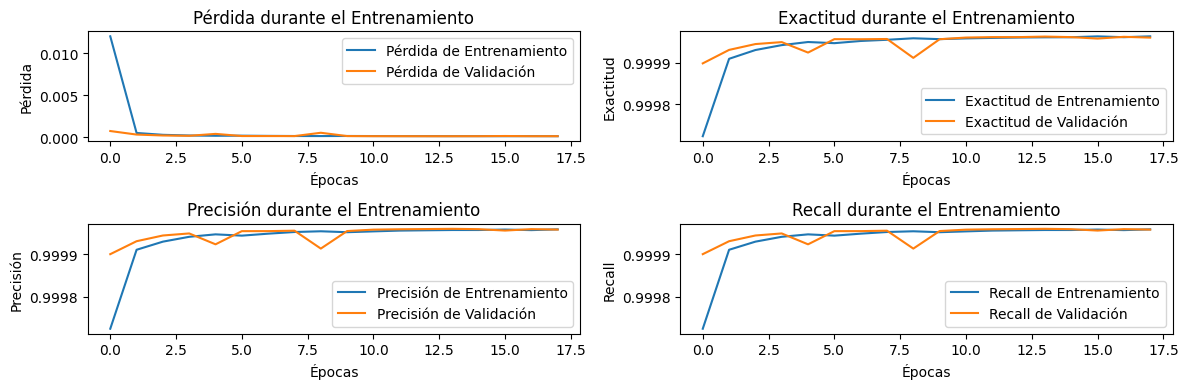

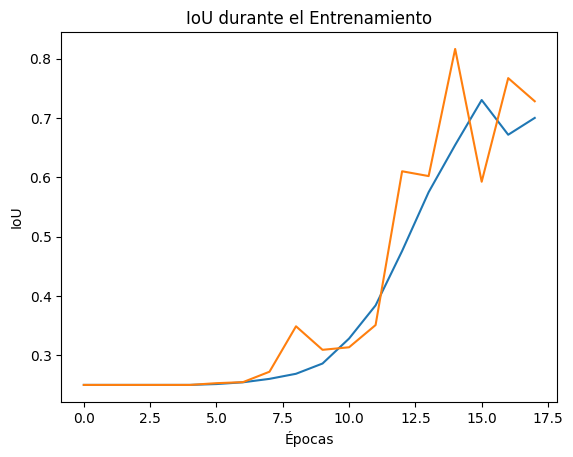

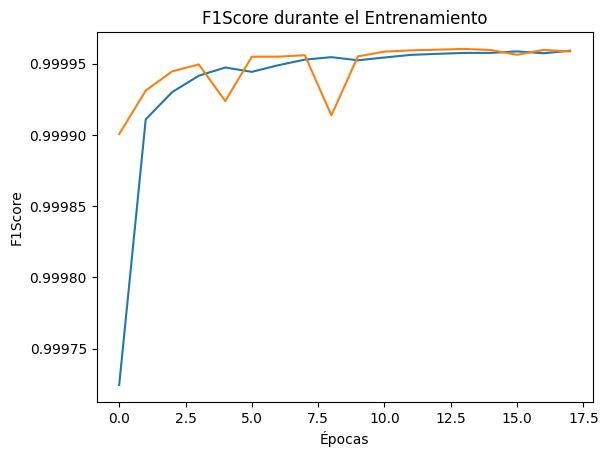

In [ ]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Exactitud
plt.subplot(2, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Exactitud de Entrenamiento')
plt.plot(history.history['val_categorical_accuracy'], label='Exactitud de Validación')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Precisión
plt.subplot(2, 2, 3)
plt.plot(history.history['precision_8'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision_8'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall_8'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall_8'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# IoU
plt.plot(history.history['mean_io_u_4'], label='IoU de Entrenamiento')
plt.plot(history.history['val_mean_io_u_4'], label='IoU de Validación')
plt.title('IoU durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.show()

# F1Score
plt.plot(history.history['f1_score'], label='F1 de Entrenamiento')
plt.plot(history.history['val_f1_score'], label='F1 de Validación')
plt.title('F1Score durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('F1Score')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

MODEL_PATH = './drive/MyDrive/Tesis/Unet_small_sdi_final_model.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 21228/21228 [51:27<00:00,  6.88it/s]

Precision: 0.873574
Recall: 0.8347149
Accuracy: 0.9999814
IoU: 0.74474764
F1-Score: 0.8537024


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model

# Expresión regular y función para extraer la información del nombre del archivo .npy
filename_regex = re.compile(r"^(LC08_(?:L1TP|L1GT|L1GS)_\d{3}\d{3}_\d{8}_\d{8}_\d{2}_\w+_p\d{5})_(\d+)_(\w+)\.npy$")

def parse_npy_filename(filename):
    match = filename_regex.match(filename)
    if match:
        base_name, koppen_class, continent = match.groups()
        return filename, base_name, int(koppen_class), continent
    return None

# Función para clasificar el grupo de píxeles según el conteo de píxeles con valor 1 en la máscara
def get_pixel_group_from_mask(mask):
    count = np.sum(mask == 1)
    if count <= 130:
        return '0-130'
    elif count <= 618:
        return '131-618'
    else:
        return '618+'

# Rutas de CSV con las rutas de imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

# Cargar las rutas desde los CSV
img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

# Rutas base donde se encuentran las imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Configuraciones del modelo
MODEL_PATH = './drive/MyDrive/Tesis/Unet_small_sdi_final_model.h5'
OUTPUT_DIR = './inferences/'  # Carpeta para guardar los resultados (opcional)

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Cargar el modelo
model = load_model(MODEL_PATH)

# Diccionario o conjunto para rastrear las combinaciones ya mostradas (Koppen, pixel_group)
displayed_combinations = set()

# Iterar sobre cada par de imagen y máscara usando las rutas obtenidas desde CSV
for img_name, mask_name in zip(img_paths, mask_paths):
    # Extraer la clase Koppen desde el nombre de la imagen
    parsed = parse_npy_filename(img_name)
    if parsed is None:
        continue  # Saltar si el nombre no coincide con el formato esperado
    _, _, koppen_class, _ = parsed
    koppen_class_str = str(koppen_class)

    # Construir las rutas completas y cargar imagen y máscara
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1)
    mask = np.float32(mask)

    # Obtener el grupo de píxeles contando los píxeles con valor 1 en la máscara
    pixel_group = get_pixel_group_from_mask(mask)

    # Combinación única de Koppen y grupo de píxeles
    combination = (koppen_class_str, pixel_group)
    if combination in displayed_combinations:
        continue  # Si ya se mostró esta combinación, continuar
    displayed_combinations.add(combination)

    # Realizar la inferencia con el modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1)

    # Mostrar los resultados: imagen original, ground truth y predicción
    plt.figure(figsize=(12, 8))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, :3])
    plt.title(f'Imagen Original - Koppen: {koppen_class_str} - Grupo: {pixel_group}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 3)
    plt.imshow(pred_class, cmap='gray')
    plt.title('Predicción')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Entrenamiento y Pruebas Unet

  ESTA ES EL CODIGO CORRECTO DE ENTRENAMIENTO!!!!!!!!!!!!!

In [ ]:
N_FILTERS = 16
N_CHANNELS = 4

EPOCHS = 30
IMAGE_SIZE = (256, 256)
MODEL_NAME = 'unet'

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset//masks/patches/'

OUTPUT_DIR = './train_output/'

EARLY_STOP_PATIENCE = 10

CHECKPOINT_PERIOD = 10
CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM)

# If not zero will be load as weights
INITIAL_EPOCH = 0
RESTART_FROM_CHECKPOINT = None
if INITIAL_EPOCH > 0:
    RESTART_FROM_CHECKPOINT = os.path.join(OUTPUT_DIR, 'checkpoint-{}-{}-epoch_{:02d}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM, INITIAL_EPOCH))

FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, MASK_ALGORITHM)

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = [CategoricalAccuracy(), precision, recall, MeanIoU(num_classes=2), F1Score()])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1)


print('Training using {}...'.format(MASK_ALGORITHM))

# Entrenamiento del modelo (las imágenes ya están en 256x256, no necesitamos redimensionar)
history = model.fit(
    x=train_generator,  # Generador de entrenamiento
    validation_data=val_generator,  # Generador de validación
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping],  # Guardar el mejor modelo y detener el entrenamiento temprano
    verbose=2,
)

# Guardar el modelo final
model.save('Unet_final_model.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 2,164,754 (8.26 MB)

 Trainable params: 2,161,810 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

Training using Kumar-Roy...
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00118, saving model to best_model.keras
1178/1178 - 934s - 793ms/step - categorical_accuracy: 0.9991 - f1_score: 0.0475 - loss: 0.0167 - mean_io_u: 0.2500 - precision: 0.0052 - recall: 0.0433 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.5695 - val_loss: 0.0012 - val_mean_io_u: 0.2503 - val_precision: 0.0543 - val_recall: 0.2208
Epoch 2/30

Epoch 2: val_loss improved from 0.00118 to 0.00036, saving model to best_model.keras
1178/1178 - 873s - 741ms/step - categorical_accuracy: 0.9999 - f1_score: 0.6962 - loss: 6.0861e-04 - mean_io_u: 0.2501 - precision: 0.1232 - recall: 0.3363 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.7674 - val_loss: 3.5800e-04 - val_mean_io_u: 0.2503 - val_precision: 0.1948 - val_recall: 0.4296
Epoch 3/30

Epoch 3: val_loss improved from 0.00036 to 0.00021, saving model to best_model.keras
1178/1178 - 852s - 723ms/step - categorical_accuracy: 0.9999 - f1_score: 0.7704 -

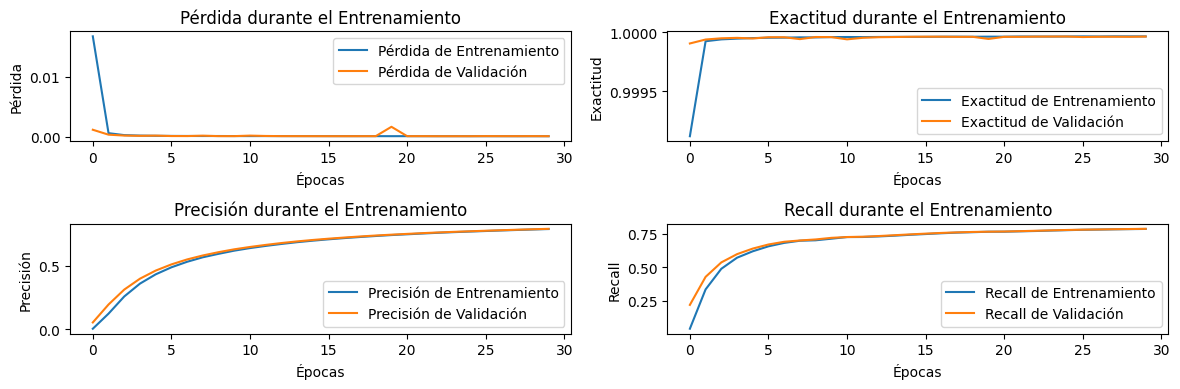

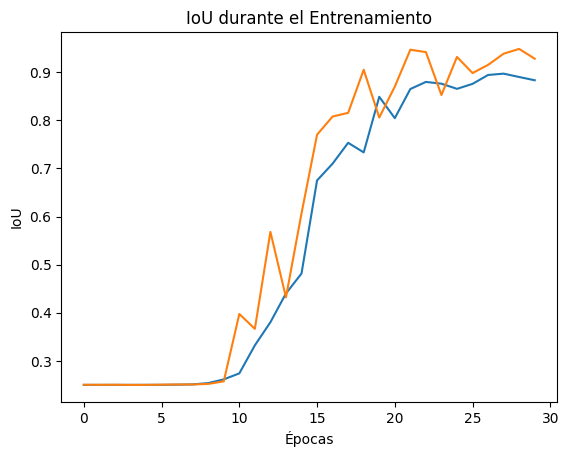

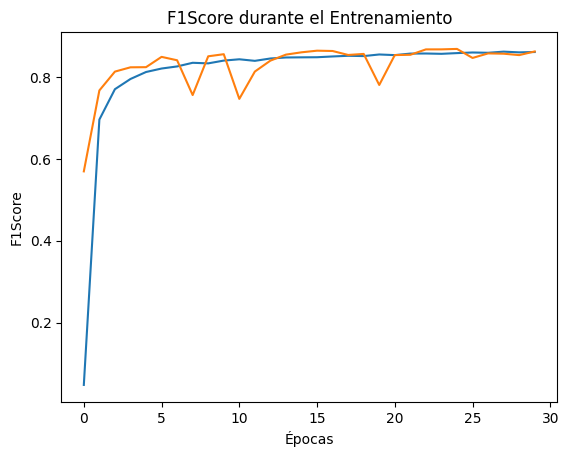

In [ ]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Exactitud
plt.subplot(2, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Exactitud de Entrenamiento')
plt.plot(history.history['val_categorical_accuracy'], label='Exactitud de Validación')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Precisión
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# IoU
plt.plot(history.history['mean_io_u'], label='IoU de Entrenamiento')
plt.plot(history.history['val_mean_io_u'], label='IoU de Validación')
plt.title('IoU durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.show()

# F1Score
plt.plot(history.history['f1_score'], label='F1 de Entrenamiento')
plt.plot(history.history['val_f1_score'], label='F1 de Validación')
plt.title('F1Score durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('F1Score')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

MODEL_PATH = './drive/MyDrive/Tesis/Unet_final_model.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 21228/21228 [51:39<00:00,  6.85it/s]

Precision: 0.90589696
Recall: 0.82359916
Accuracy: 0.9999838
IoU: 0.75869
F1-Score: 0.8627899


METRICAS USANDO BINARY CROSS ENTROPY:

Precision: 0.8124123

Recall: 0.79308575

Accuracy: 0.9999279

IoU: 0.8351289

METIRCAS USANDO CATEGORICAL CROSS ENTROPY:

Precision: 0.9114328

Recall: 0.73267156

Accuracy: 0.99993706

IoU: 0.84195566

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model

# Expresión regular y función para extraer la información del nombre del archivo .npy
filename_regex = re.compile(r"^(LC08_(?:L1TP|L1GT|L1GS)_\d{3}\d{3}_\d{8}_\d{8}_\d{2}_\w+_p\d{5})_(\d+)_(\w+)\.npy$")

def parse_npy_filename(filename):
    match = filename_regex.match(filename)
    if match:
        base_name, koppen_class, continent = match.groups()
        return filename, base_name, int(koppen_class), continent
    return None

# Función para clasificar el grupo de píxeles según el conteo de píxeles con valor 1 en la máscara
def get_pixel_group_from_mask(mask):
    count = np.sum(mask == 1)
    if count <= 130:
        return '0-130'
    elif count <= 618:
        return '131-618'
    else:
        return '618+'

# Rutas de CSV con las rutas de imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

# Cargar las rutas desde los CSV
img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

# Rutas base donde se encuentran las imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Configuraciones del modelo
MODEL_PATH = './drive/MyDrive/Tesis/Unet_final_model.h5'
OUTPUT_DIR = './inferences/'  # Carpeta para guardar los resultados (opcional)

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Cargar el modelo
model = load_model(MODEL_PATH)

# Diccionario o conjunto para rastrear las combinaciones ya mostradas (Koppen, pixel_group)
displayed_combinations = set()

# Iterar sobre cada par de imagen y máscara usando las rutas obtenidas desde CSV
for img_name, mask_name in zip(img_paths, mask_paths):
    # Extraer la clase Koppen desde el nombre de la imagen
    parsed = parse_npy_filename(img_name)
    if parsed is None:
        continue  # Saltar si el nombre no coincide con el formato esperado
    _, _, koppen_class, _ = parsed
    koppen_class_str = str(koppen_class)

    # Construir las rutas completas y cargar imagen y máscara
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1)
    mask = np.float32(mask)

    # Obtener el grupo de píxeles contando los píxeles con valor 1 en la máscara
    pixel_group = get_pixel_group_from_mask(mask)

    # Combinación única de Koppen y grupo de píxeles
    combination = (koppen_class_str, pixel_group)
    if combination in displayed_combinations:
        continue  # Si ya se mostró esta combinación, continuar
    displayed_combinations.add(combination)

    # Realizar la inferencia con el modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1)

    # Mostrar los resultados: imagen original, ground truth y predicción
    plt.figure(figsize=(12, 8))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, :3])
    plt.title(f'Imagen Original - Koppen: {koppen_class_str} - Grupo: {pixel_group}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 3)
    plt.imshow(pred_class, cmap='gray')
    plt.title('Predicción')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Entrenamiento y Pruebas Unet SDI

In [ ]:
N_FILTERS = 16
N_CHANNELS = 4

EPOCHS = 30
IMAGE_SIZE = (256, 256)
MODEL_NAME = 'unet_sdi'

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset//masks/patches/'

OUTPUT_DIR = './train_output/'

EARLY_STOP_PATIENCE = 10

CHECKPOINT_PERIOD = 10
CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM)

# If not zero will be load as weights
INITIAL_EPOCH = 0
RESTART_FROM_CHECKPOINT = None
if INITIAL_EPOCH > 0:
    RESTART_FROM_CHECKPOINT = os.path.join(OUTPUT_DIR, 'checkpoint-{}-{}-epoch_{:02d}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM, INITIAL_EPOCH))

FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, MASK_ALGORITHM)

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = [CategoricalAccuracy(), precision, recall, MeanIoU(num_classes=2), F1Score()])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1)


print('Training using {}...'.format(MASK_ALGORITHM))

# Entrenamiento del modelo (las imágenes ya están en 256x256, no necesitamos redimensionar)
history = model.fit(
    x=train_generator,  # Generador de entrenamiento
    validation_data=val_generator,  # Generador de validación
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping],  # Guardar el mejor modelo y detener el entrenamiento temprano
    verbose=2,
)

# Guardar el modelo final
model.save('Unet_sdi_final_model.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 4,381,378 (16.71 MB)

 Trainable params: 4,378,434 (16.70 MB)

 Non-trainable params: 2,944 (11.50 KB)

Training using Kumar-Roy...
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00092, saving model to best_model.keras
1178/1178 - 1127s - 957ms/step - categorical_accuracy: 0.9979 - f1_score: 0.0343 - loss: 0.0339 - mean_io_u: 0.2500 - precision: 0.0056 - recall: 0.1269 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.2247 - val_loss: 9.2166e-04 - val_mean_io_u: 0.2500 - val_precision: 0.0215 - val_recall: 0.2273
Epoch 2/30

Epoch 2: val_loss improved from 0.00092 to 0.00039, saving model to best_model.keras
1178/1178 - 1028s - 873ms/step - categorical_accuracy: 0.9999 - f1_score: 0.6716 - loss: 6.3697e-04 - mean_io_u: 0.2500 - precision: 0.0442 - recall: 0.2815 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.7441 - val_loss: 3.8565e-04 - val_mean_io_u: 0.2500 - val_precision: 0.0773 - val_recall: 0.3800
Epoch 3/30

Epoch 3: val_loss improved from 0.00039 to 0.00024, saving model to best_model.keras
1178/1178 - 1029s - 873ms/step - categorical_accuracy: 0.9999 - f1_score: 0

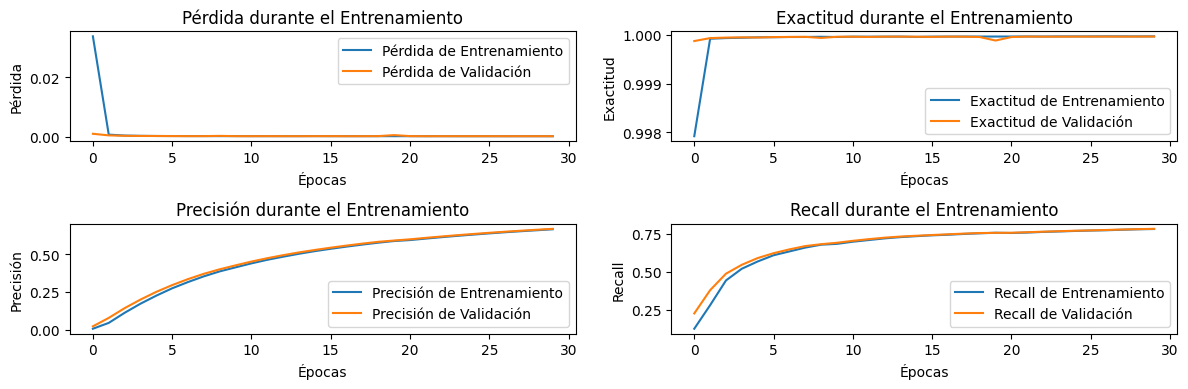

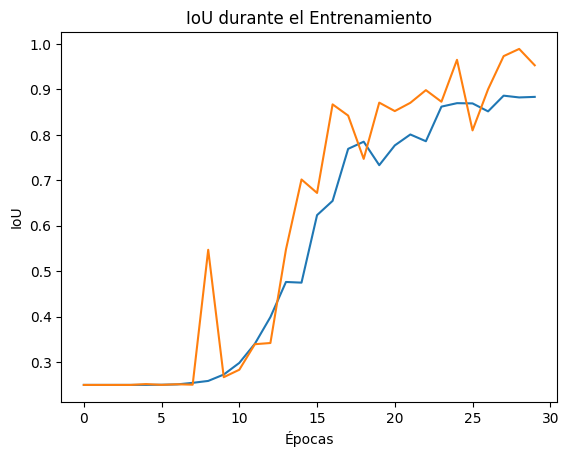

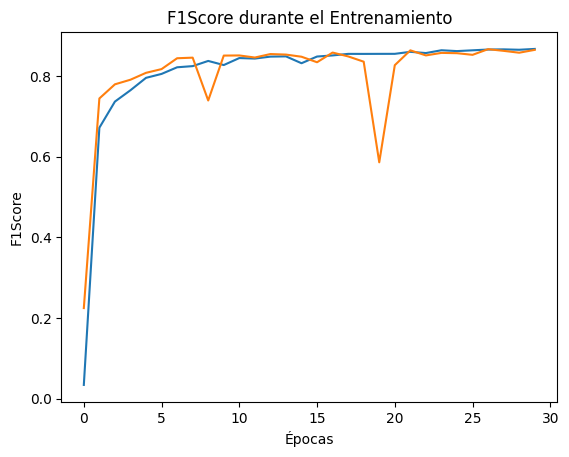

In [ ]:
import matplotlib.pyplot as pelt

# Graficar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Exactitud
plt.subplot(2, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Exactitud de Entrenamiento')
plt.plot(history.history['val_categorical_accuracy'], label='Exactitud de Validación')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Precisión
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# IoU
plt.plot(history.history['mean_io_u'], label='IoU de Entrenamiento')
plt.plot(history.history['val_mean_io_u'], label='IoU de Validación')
plt.title('IoU durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.show()

# F1Score
plt.plot(history.history['f1_score'], label='F1 de Entrenamiento')
plt.plot(history.history['val_f1_score'], label='F1 de Validación')
plt.title('F1Score durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('F1Score')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

MODEL_PATH = './drive/MyDrive/Tesis/Unet_sdi_final_model.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 21228/21228 [54:42<00:00,  6.47it/s]

Precision: 0.8894182
Recall: 0.84439486
Accuracy: 0.9999836
IoU: 0.76416916
F1-Score: 0.86632186


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model

# Expresión regular y función para extraer la información del nombre del archivo .npy
filename_regex = re.compile(r"^(LC08_(?:L1TP|L1GT|L1GS)_\d{3}\d{3}_\d{8}_\d{8}_\d{2}_\w+_p\d{5})_(\d+)_(\w+)\.npy$")

def parse_npy_filename(filename):
    match = filename_regex.match(filename)
    if match:
        base_name, koppen_class, continent = match.groups()
        return filename, base_name, int(koppen_class), continent
    return None

# Función para clasificar el grupo de píxeles según el conteo de píxeles con valor 1 en la máscara
def get_pixel_group_from_mask(mask):
    count = np.sum(mask == 1)
    if count <= 130:
        return '0-130'
    elif count <= 618:
        return '131-618'
    else:
        return '618+'

# Rutas de CSV con las rutas de imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

# Cargar las rutas desde los CSV
img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

# Rutas base donde se encuentran las imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Configuraciones del modelo
MODEL_PATH = './drive/MyDrive/Tesis/Unet_sdi_final_model.h5'
OUTPUT_DIR = './inferences/'  # Carpeta para guardar los resultados (opcional)

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Cargar el modelo
model = load_model(MODEL_PATH)

# Diccionario o conjunto para rastrear las combinaciones ya mostradas (Koppen, pixel_group)
displayed_combinations = set()

# Iterar sobre cada par de imagen y máscara usando las rutas obtenidas desde CSV
for img_name, mask_name in zip(img_paths, mask_paths):
    # Extraer la clase Koppen desde el nombre de la imagen
    parsed = parse_npy_filename(img_name)
    if parsed is None:
        continue  # Saltar si el nombre no coincide con el formato esperado
    _, _, koppen_class, _ = parsed
    koppen_class_str = str(koppen_class)

    # Construir las rutas completas y cargar imagen y máscara
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1)
    mask = np.float32(mask)

    # Obtener el grupo de píxeles contando los píxeles con valor 1 en la máscara
    pixel_group = get_pixel_group_from_mask(mask)

    # Combinación única de Koppen y grupo de píxeles
    combination = (koppen_class_str, pixel_group)
    if combination in displayed_combinations:
        continue  # Si ya se mostró esta combinación, continuar
    displayed_combinations.add(combination)

    # Realizar la inferencia con el modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1)

    # Mostrar los resultados: imagen original, ground truth y predicción
    plt.figure(figsize=(12, 8))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, :3])
    plt.title(f'Imagen Original - Koppen: {koppen_class_str} - Grupo: {pixel_group}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 3)
    plt.imshow(pred_class, cmap='gray')
    plt.title('Predicción')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Entrenamiento y pruebas de Multiscale-Net

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
N_FILTERS = 16
N_CHANNELS = 4

EPOCHS = 30
IMAGE_SIZE = (256, 256)
MODEL_NAME = 'multiscale_net'

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset//masks/patches/'

OUTPUT_DIR = './train_output/'

EARLY_STOP_PATIENCE = 10

CHECKPOINT_PERIOD = 10
CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM)

# If not zero will be load as weights
INITIAL_EPOCH = 0
RESTART_FROM_CHECKPOINT = None
if INITIAL_EPOCH > 0:
    RESTART_FROM_CHECKPOINT = os.path.join(OUTPUT_DIR, 'checkpoint-{}-{}-epoch_{:02d}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM, INITIAL_EPOCH))

FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, MASK_ALGORITHM)

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = [CategoricalAccuracy(), precision, recall, MeanIoU(num_classes=2), F1Score()])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("Multiscale_net_best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1)


print('Training using {}...'.format(MASK_ALGORITHM))

# Entrenamiento del modelo (las imágenes ya están en 256x256, no necesitamos redimensionar)
history = model.fit(
    x=train_generator,  # Generador de entrenamiento
    validation_data=val_generator,  # Generador de validación
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping],  # Guardar el mejor modelo y detener el entrenamiento temprano
    verbose=2,
)

# Guardar el modelo final
model.save('Multiscale_net_final_model.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 16)   │          1,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 16)   │          3,152 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256, 256, 16)   │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 16)   │          6,416 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 16)   │         12,560 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 16)   │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256, 256, 16)   │             64 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 45,746,034 (174.51 MB)

 Trainable params: 45,736,722 (174.47 MB)

 Non-trainable params: 9,312 (36.38 KB)

Training using Kumar-Roy...
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00040, saving model to Multiscale_net_best_model.keras
1178/1178 - 1713s - 1s/step - categorical_accuracy: 0.9985 - f1_score: 0.0613 - loss: 0.0078 - mean_io_u: 0.2502 - precision: 0.0106 - recall: 0.1675 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.7137 - val_loss: 3.9859e-04 - val_mean_io_u: 0.2506 - val_precision: 0.0535 - val_recall: 0.4261
Epoch 2/30

Epoch 2: val_loss improved from 0.00040 to 0.00020, saving model to Multiscale_net_best_model.keras
1178/1178 - 1499s - 1s/step - categorical_accuracy: 0.9999 - f1_score: 0.7559 - loss: 3.2132e-04 - mean_io_u: 0.2504 - precision: 0.0985 - recall: 0.5061 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.8028 - val_loss: 1.9771e-04 - val_mean_io_u: 0.2501 - val_precision: 0.1440 - val_recall: 0.5660
Epoch 3/30

Epoch 3: val_loss did not improve from 0.00020
1178/1178 - 1499s - 1s/step - categorical_accuracy: 1.0000 - f1_score: 0.8100 - loss: 1.8

In [ ]:
!cp Multiscale_net_final_model.h5 "/content/drive/My Drive/Tesis"
!cp Multiscale_net_best_model.keras "/content/drive/My Drive/Tesis"

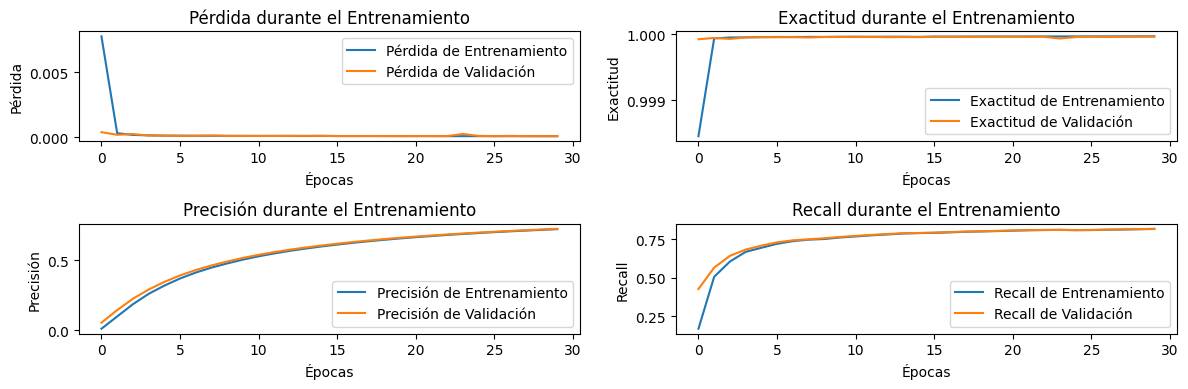

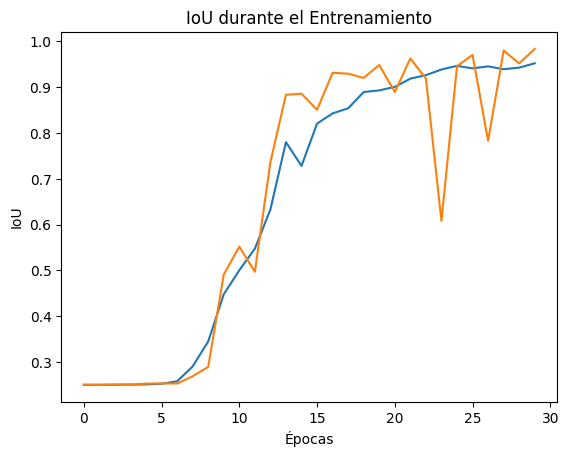

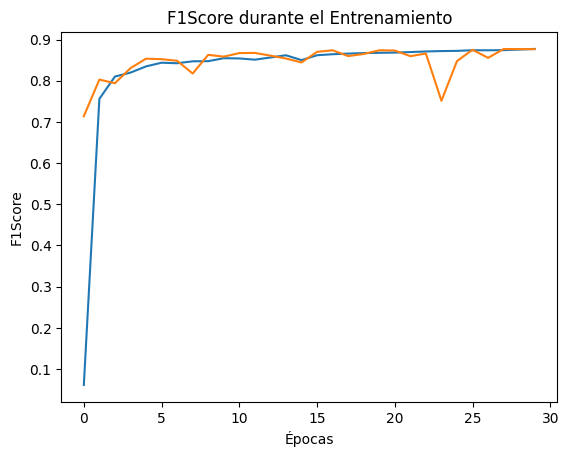

In [ ]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Exactitud
plt.subplot(2, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Exactitud de Entrenamiento')
plt.plot(history.history['val_categorical_accuracy'], label='Exactitud de Validación')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Precisión
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# IoU
plt.plot(history.history['mean_io_u'], label='IoU de Entrenamiento')
plt.plot(history.history['val_mean_io_u'], label='IoU de Validación')
plt.title('IoU durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.show()

# F1Score
plt.plot(history.history['f1_score'], label='F1 de Entrenamiento')
plt.plot(history.history['val_f1_score'], label='F1 de Validación')
plt.title('F1Score durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('F1Score')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

MODEL_PATH = './drive/My Drive/Tesis/Multiscale_net_final_model.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 21228/21228 [57:19<00:00,  6.17it/s]

Precision: 0.8911404
Recall: 0.86437017
Accuracy: 0.99998516
IoU: 0.78181833
F1-Score: 0.87755114


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model

# Expresión regular y función para extraer la información del nombre del archivo .npy
filename_regex = re.compile(r"^(LC08_(?:L1TP|L1GT|L1GS)_\d{3}\d{3}_\d{8}_\d{8}_\d{2}_\w+_p\d{5})_(\d+)_(\w+)\.npy$")

def parse_npy_filename(filename):
    match = filename_regex.match(filename)
    if match:
        base_name, koppen_class, continent = match.groups()
        return filename, base_name, int(koppen_class), continent
    return None

# Función para clasificar el grupo de píxeles según el conteo de píxeles con valor 1 en la máscara
def get_pixel_group_from_mask(mask):
    count = np.sum(mask == 1)
    if count <= 130:
        return '0-130'
    elif count <= 618:
        return '131-618'
    else:
        return '618+'

# Rutas de CSV con las rutas de imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

# Cargar las rutas desde los CSV
img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

# Rutas base donde se encuentran las imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Configuraciones del modelo
MODEL_PATH = './drive/MyDrive/Tesis/Multiscale_net_final_model.h5'
OUTPUT_DIR = './inferences/'  # Carpeta para guardar los resultados (opcional)

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Cargar el modelo
model = load_model(MODEL_PATH)

# Diccionario o conjunto para rastrear las combinaciones ya mostradas (Koppen, pixel_group)
displayed_combinations = set()

# Iterar sobre cada par de imagen y máscara usando las rutas obtenidas desde CSV
for img_name, mask_name in zip(img_paths, mask_paths):
    # Extraer la clase Koppen desde el nombre de la imagen
    parsed = parse_npy_filename(img_name)
    if parsed is None:
        continue  # Saltar si el nombre no coincide con el formato esperado
    _, _, koppen_class, _ = parsed
    koppen_class_str = str(koppen_class)

    # Construir las rutas completas y cargar imagen y máscara
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1)
    mask = np.float32(mask)

    # Obtener el grupo de píxeles contando los píxeles con valor 1 en la máscara
    pixel_group = get_pixel_group_from_mask(mask)

    # Combinación única de Koppen y grupo de píxeles
    combination = (koppen_class_str, pixel_group)
    if combination in displayed_combinations:
        continue  # Si ya se mostró esta combinación, continuar
    displayed_combinations.add(combination)

    # Realizar la inferencia con el modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1)

    # Mostrar los resultados: imagen original, ground truth y predicción
    plt.figure(figsize=(12, 8))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, :3])
    plt.title(f'Imagen Original - Koppen: {koppen_class_str} - Grupo: {pixel_group}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 3)
    plt.imshow(pred_class, cmap='gray')
    plt.title('Predicción')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Entrenamiento y pruebas del modelo UnetV2Small

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp best_model.keras "/content/drive/My Drive/Tesis"

In [ ]:
N_FILTERS = 16
N_CHANNELS = 4

EPOCHS = 30
IMAGE_SIZE = (256, 256)
MODEL_NAME = 'unet_v2_small'

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset//masks/patches/'

OUTPUT_DIR = './train_output/'

EARLY_STOP_PATIENCE = 10

CHECKPOINT_PERIOD = 10
CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM)

# If not zero will be load as weights
INITIAL_EPOCH = 0
RESTART_FROM_CHECKPOINT = None
if INITIAL_EPOCH > 0:
    RESTART_FROM_CHECKPOINT = os.path.join(OUTPUT_DIR, 'checkpoint-{}-{}-epoch_{:02d}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM, INITIAL_EPOCH))

FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, MASK_ALGORITHM)

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = [CategoricalAccuracy(), precision, recall, IoU(num_classes=2, target_class_ids=[1]), F1Score()])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("UnetV2_best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1)


print('Training using {}...'.format(MASK_ALGORITHM))

history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping],
    verbose=2,
)

# Guardar el modelo final
model.save('UnetV2_small_final_model.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 16)   │          1,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 16)   │          6,416 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 16)   │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 32)   │              0 │ activation[0][0],      │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 32)   │              0 │ activation_2[0][0],    │
│ (Concatenate)             │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 32)   │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 32)   │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 256, 256, 64)   │              0 │ activation_1[0][0],    │
│ (Concatenate)             │                        │                │ activation_3[0][0]     │
├──────────────────────

 Total params: 1,156,034 (4.41 MB)

 Trainable params: 1,154,658 (4.40 MB)

 Non-trainable params: 1,376 (5.38 KB)

Training using Kumar-Roy...
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00051, saving model to UnetV2_best_model.keras
1178/1178 - 1190s - 1s/step - categorical_accuracy: 0.9976 - f1_score: 0.0470 - loss: 0.0172 - mean_io_u: 0.2501 - precision: 0.0113 - recall: 0.3824 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.6837 - val_loss: 5.1052e-04 - val_mean_io_u: 0.2501 - val_precision: 0.0367 - val_recall: 0.4606
Epoch 2/30

Epoch 2: val_loss improved from 0.00051 to 0.00022, saving model to UnetV2_best_model.keras
1178/1178 - 1105s - 938ms/step - categorical_accuracy: 0.9999 - f1_score: 0.7317 - loss: 3.8700e-04 - mean_io_u: 0.2502 - precision: 0.0652 - recall: 0.5152 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.7935 - val_loss: 2.1736e-04 - val_mean_io_u: 0.2501 - val_precision: 0.0961 - val_recall: 0.5716
Epoch 3/30

Epoch 3: val_loss improved from 0.00022 to 0.00015, saving model to UnetV2_best_model.keras
1178/1178 - 1099s - 933ms/step - categorical_accuracy: 1.

In [ ]:
!cp UnetV2_small_final_model.h5 "/content/drive/My Drive/Tesis"
!cp UnetV2_best_model.keras "/content/drive/My Drive/Tesis"

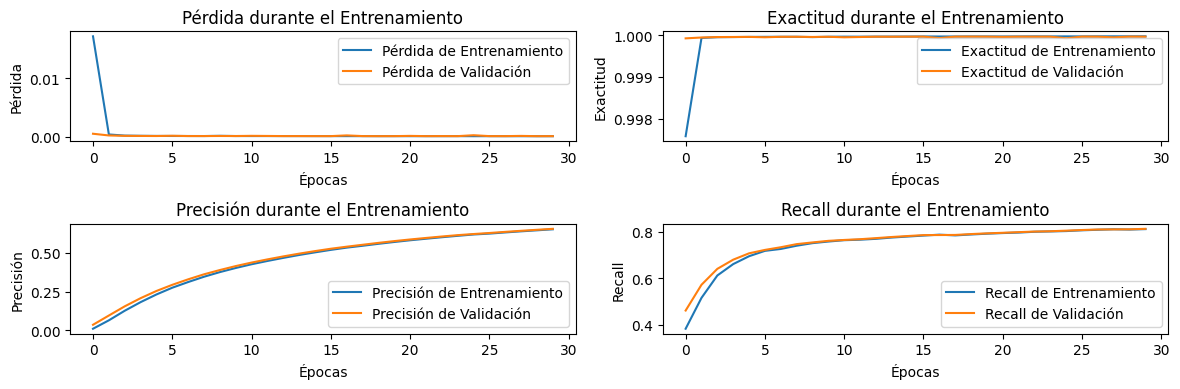

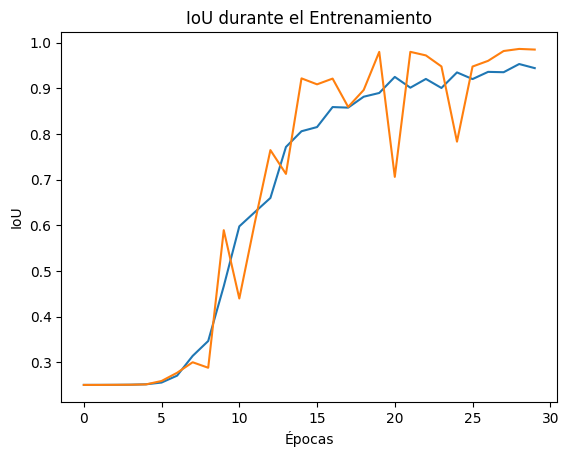

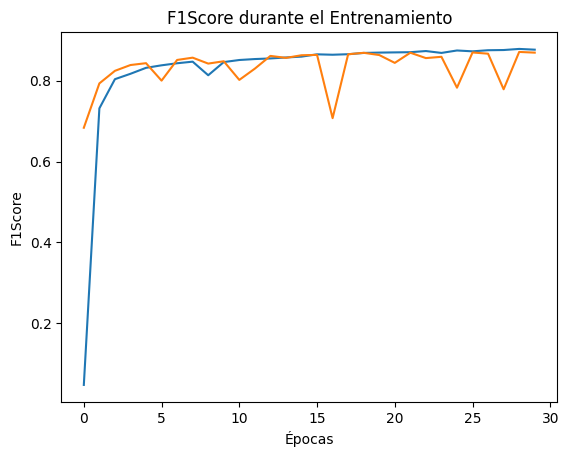

In [ ]:
import matplotlib.pyplot as pelt

# Graficar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Exactitud
plt.subplot(2, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Exactitud de Entrenamiento')
plt.plot(history.history['val_categorical_accuracy'], label='Exactitud de Validación')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Precisión
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# IoU
plt.plot(history.history['mean_io_u'], label='IoU de Entrenamiento')
plt.plot(history.history['val_mean_io_u'], label='IoU de Validación')
plt.title('IoU durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.show()

# F1Score
plt.plot(history.history['f1_score'], label='F1 de Entrenamiento')
plt.plot(history.history['val_f1_score'], label='F1 de Validación')
plt.title('F1Score durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('F1Score')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

MODEL_PATH = './drive/MyDrive/Tesis/UnetV2_small_final_model.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 21228/21228 [52:55<00:00,  6.68it/s]


Precision: 0.8449877
Recall: 0.9036854
Accuracy: 0.9999841
IoU: 0.7751762
F1-Score: 0.87335134


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model

# Expresión regular y función para extraer la información del nombre del archivo .npy
filename_regex = re.compile(r"^(LC08_(?:L1TP|L1GT|L1GS)_\d{3}\d{3}_\d{8}_\d{8}_\d{2}_\w+_p\d{5})_(\d+)_(\w+)\.npy$")

def parse_npy_filename(filename):
    match = filename_regex.match(filename)
    if match:
        base_name, koppen_class, continent = match.groups()
        return filename, base_name, int(koppen_class), continent
    return None

# Función para clasificar el grupo de píxeles según el conteo de píxeles con valor 1 en la máscara
def get_pixel_group_from_mask(mask):
    count = np.sum(mask == 1)
    if count <= 130:
        return '0-130'
    elif count <= 618:
        return '131-618'
    else:
        return '618+'

# Rutas de CSV con las rutas de imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

# Cargar las rutas desde los CSV
img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

# Rutas base donde se encuentran las imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Configuraciones del modelo
MODEL_PATH = './drive/MyDrive/Tesis/UnetV2_small_final_model.h5'
OUTPUT_DIR = './inferences/'  # Carpeta para guardar los resultados (opcional)

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Cargar el modelo
model = load_model(MODEL_PATH)

# Diccionario o conjunto para rastrear las combinaciones ya mostradas (Koppen, pixel_group)
displayed_combinations = set()

# Iterar sobre cada par de imagen y máscara usando las rutas obtenidas desde CSV
for img_name, mask_name in zip(img_paths, mask_paths):
    # Extraer la clase Koppen desde el nombre de la imagen
    parsed = parse_npy_filename(img_name)
    if parsed is None:
        continue  # Saltar si el nombre no coincide con el formato esperado
    _, _, koppen_class, _ = parsed
    koppen_class_str = str(koppen_class)

    # Construir las rutas completas y cargar imagen y máscara
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1)
    mask = np.float32(mask)

    # Obtener el grupo de píxeles contando los píxeles con valor 1 en la máscara
    pixel_group = get_pixel_group_from_mask(mask)

    # Combinación única de Koppen y grupo de píxeles
    combination = (koppen_class_str, pixel_group)
    if combination in displayed_combinations:
        continue  # Si ya se mostró esta combinación, continuar
    displayed_combinations.add(combination)

    # Realizar la inferencia con el modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1)

    # Mostrar los resultados: imagen original, ground truth y predicción
    plt.figure(figsize=(12, 8))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, :3])
    plt.title(f'Imagen Original - Koppen: {koppen_class_str} - Grupo: {pixel_group}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 3)
    plt.imshow(pred_class, cmap='gray')
    plt.title('Predicción')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Entrenamiento y pruebas del modelo UnetV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
N_FILTERS = 16
N_CHANNELS = 4

EPOCHS = 30
IMAGE_SIZE = (256, 256)
MODEL_NAME = 'unet_v2'

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset//masks/patches/'

OUTPUT_DIR = './train_output/'

EARLY_STOP_PATIENCE = 10

CHECKPOINT_PERIOD = 10
CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM)

# If not zero will be load as weights
INITIAL_EPOCH = 0
RESTART_FROM_CHECKPOINT = None
if INITIAL_EPOCH > 0:
    RESTART_FROM_CHECKPOINT = os.path.join(OUTPUT_DIR, 'checkpoint-{}-{}-epoch_{:02d}.hdf5'.format(MODEL_NAME, MASK_ALGORITHM, INITIAL_EPOCH))

FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, MASK_ALGORITHM)

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = [CategoricalAccuracy(), precision, recall, MeanIoU(num_classes=2), F1Score()])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("UnetV2_best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1)


print('Training using {}...'.format(MASK_ALGORITHM))

# Entrenamiento del modelo (las imágenes ya están en 256x256, no necesitamos redimensionar)
history = model.fit(
    x=train_generator,  # Generador de entrenamiento
    validation_data=val_generator,  # Generador de validación
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping],  # Guardar el mejor modelo y detener el entrenamiento temprano
    verbose=2,
)

# Guardar el modelo final
model.save('UnetV2_final_model.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 16)   │          1,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 16)   │          3,152 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256, 256, 16)   │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 16)   │          6,416 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 16)   │         12,560 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 16)   │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256, 256, 16)   │             64 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 48,528,418 (185.12 MB)

 Trainable params: 48,519,106 (185.09 MB)

 Non-trainable params: 9,312 (36.38 KB)

Training using Kumar-Roy...
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00025, saving model to UnetV2_best_model.keras
1178/1178 - 2312s - 2s/step - categorical_accuracy: 0.9990 - f1_score: 0.1096 - loss: 0.0094 - mean_io_u: 0.2502 - precision: 0.0227 - recall: 0.2303 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.7604 - val_loss: 2.5307e-04 - val_mean_io_u: 0.2500 - val_precision: 0.0936 - val_recall: 0.4897
Epoch 2/30

Epoch 2: val_loss improved from 0.00025 to 0.00021, saving model to UnetV2_best_model.keras
1178/1178 - 2121s - 2s/step - categorical_accuracy: 0.9999 - f1_score: 0.7758 - loss: 2.2632e-04 - mean_io_u: 0.2504 - precision: 0.1647 - recall: 0.5722 - val_categorical_accuracy: 0.9999 - val_f1_score: 0.7486 - val_loss: 2.0974e-04 - val_mean_io_u: 0.2515 - val_precision: 0.2211 - val_recall: 0.6066
Epoch 3/30

Epoch 3: val_loss improved from 0.00021 to 0.00014, saving model to UnetV2_best_model.keras
1178/1178 - 2121s - 2s/step - categorical_accuracy: 1.0000 -

In [ ]:
!cp UnetV2_final_model.h5 "/content/drive/My Drive/Tesis"
!cp UnetV2_best_model.keras "/content/drive/My Drive/Tesis"

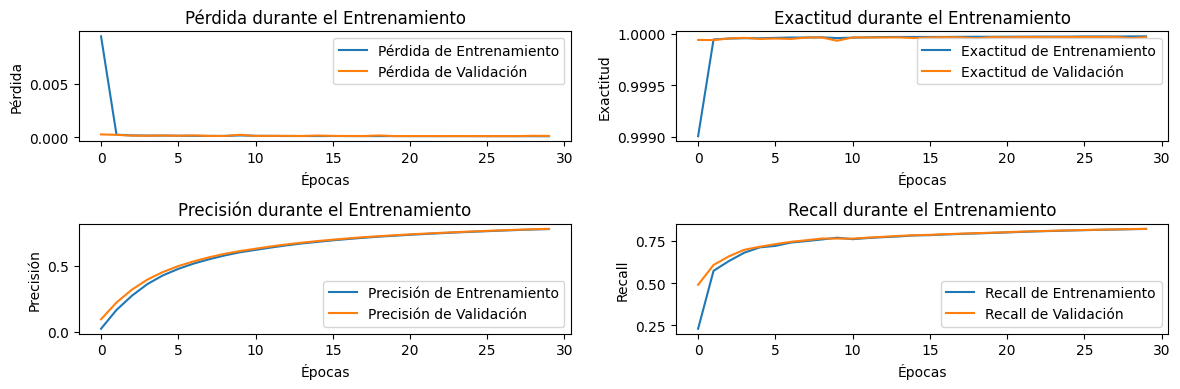

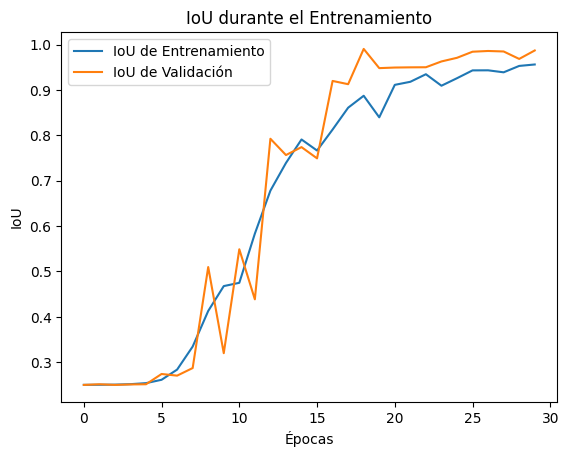

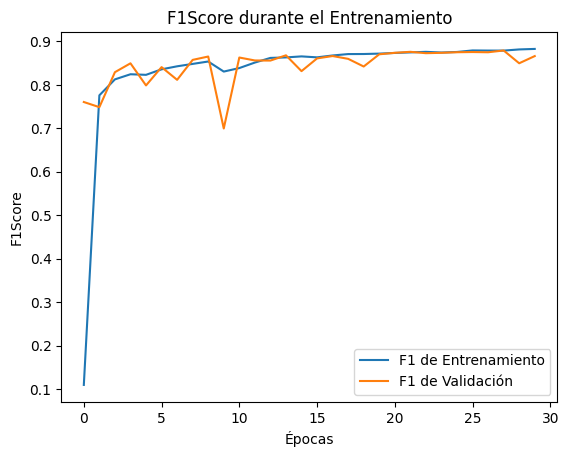

In [ ]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Exactitud
plt.subplot(2, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Exactitud de Entrenamiento')
plt.plot(history.history['val_categorical_accuracy'], label='Exactitud de Validación')
plt.title('Exactitud durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Precisión
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# IoU
plt.plot(history.history['mean_io_u'], label='IoU de Entrenamiento')
plt.plot(history.history['val_mean_io_u'], label='IoU de Validación')
plt.title('IoU durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.legend()
plt.show()

# F1Score
plt.plot(history.history['f1_score'], label='F1 de Entrenamiento')
plt.plot(history.history['val_f1_score'], label='F1 de Validación')
plt.title('F1Score durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('F1Score')
plt.legend()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

MODEL_PATH = './drive/My Drive/Tesis/UnetV2_final_model.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 21228/21228 [1:07:28<00:00,  5.24it/s]


Precision: 0.91199154
Recall: 0.8228988
Accuracy: 0.99998397
IoU: 0.762359
F1-Score: 0.8651575


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model

# Expresión regular y función para extraer la información del nombre del archivo .npy
filename_regex = re.compile(r"^(LC08_(?:L1TP|L1GT|L1GS)_\d{3}\d{3}_\d{8}_\d{8}_\d{2}_\w+_p\d{5})_(\d+)_(\w+)\.npy$")

def parse_npy_filename(filename):
    match = filename_regex.match(filename)
    if match:
        base_name, koppen_class, continent = match.groups()
        return filename, base_name, int(koppen_class), continent
    return None

# Función para clasificar el grupo de píxeles según el conteo de píxeles con valor 1 en la máscara
def get_pixel_group_from_mask(mask):
    count = np.sum(mask == 1)
    if count <= 130:
        return '0-130'
    elif count <= 618:
        return '131-618'
    else:
        return '618+'

# Rutas de CSV con las rutas de imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

# Cargar las rutas desde los CSV
img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

# Rutas base donde se encuentran las imágenes y máscaras
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Configuraciones del modelo
MODEL_PATH = './drive/MyDrive/Tesis/UnetV2_final_model.h5'
OUTPUT_DIR = './inferences/'  # Carpeta para guardar los resultados (opcional)

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Cargar el modelo
model = load_model(MODEL_PATH)

# Diccionario o conjunto para rastrear las combinaciones ya mostradas (Koppen, pixel_group)
displayed_combinations = set()

# Iterar sobre cada par de imagen y máscara usando las rutas obtenidas desde CSV
for img_name, mask_name in zip(img_paths, mask_paths):
    # Extraer la clase Koppen desde el nombre de la imagen
    parsed = parse_npy_filename(img_name)
    if parsed is None:
        continue  # Saltar si el nombre no coincide con el formato esperado
    _, _, koppen_class, _ = parsed
    koppen_class_str = str(koppen_class)

    # Construir las rutas completas y cargar imagen y máscara
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1)
    mask = np.float32(mask)

    # Obtener el grupo de píxeles contando los píxeles con valor 1 en la máscara
    pixel_group = get_pixel_group_from_mask(mask)

    # Combinación única de Koppen y grupo de píxeles
    combination = (koppen_class_str, pixel_group)
    if combination in displayed_combinations:
        continue  # Si ya se mostró esta combinación, continuar
    displayed_combinations.add(combination)

    # Realizar la inferencia con el modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1)

    # Mostrar los resultados: imagen original, ground truth y predicción
    plt.figure(figsize=(12, 8))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, :3])
    plt.title(f'Imagen Original - Koppen: {koppen_class_str} - Grupo: {pixel_group}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 3)
    plt.imshow(pred_class, cmap='gray')
    plt.title('Predicción')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Pruebas Random Forest

In [ ]:
import os
import numpy as np
import rasterio
import pandas as pd

IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

MAX_PIXEL_VALUE = 65535

def data_generator_for_rf(images_csv, masks_csv, img_dir=IMAGES_PATH, mask_dir=MASKS_PATH):
    # Leer las rutas de las imágenes y máscaras desde los CSV
    img_paths = pd.read_csv(images_csv)['0'].tolist()
    mask_paths = pd.read_csv(masks_csv)['0'].tolist()

    # Procesar cada imagen y cada máscara
    pixels = []
    labels = []

    for img_name, mask_name in zip(img_paths, mask_paths):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        # Cargar la imagen y máscara
        image = np.load(img_path)
        mask = rasterio.open(mask_path).read(1)

        # Redimensionar la imagen y la máscara a pixels
        n_pixels = image.shape[0] * image.shape[1]  # Número de píxeles (256*256)
        image_pixels = image.reshape(n_pixels, image.shape[2])  # Dimensiones: (num píxeles, 4)
        mask_pixels = mask.reshape(n_pixels)  # Dimensiones: (num píxeles,)

        pixels.append(image_pixels)
        labels.append(mask_pixels)

    # Concatenar todos los píxeles y etiquetas
    pixels = np.vstack(pixels)
    labels = np.hstack(labels)

    return pixels, labels

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

# Preparar datos de entrenamiento
X_train, y_train = data_generator_for_rf('./dataset/images_train.csv', './dataset/masks_train.csv')
print("Forma de X_train:", X_train.shape)  # Debe ser (n_pixels, 4)
print("Forma de y_train:", y_train.shape)  # Debe ser (n_pixels,)

# Crear y entrenar el modelo
rf_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    max_features='sqrt',
    bootstrap=False,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=2,
    verbose=2
)

# Usa un subconjunto más pequeño de los datos para la estimación
sample_size = int(0.1 * len(X_train))  # Usa el 1% de los datos
sample_pixels = X_train[:sample_size]
print('Shape Sample: ', sample_pixels.shape)
sample_labels = y_train[:sample_size]

start_time = time.time()
rf_model.fit(sample_pixels, sample_labels)
end_time = time.time()

# Calcular el tiempo por muestra y extrapolar
time_per_sample = (end_time - start_time) / sample_size
total_time_estimate = time_per_sample * len(X_train)

print(f"Tiempo estimado de entrenamiento: {total_time_estimate/60:.2f} minutos")
del sample_pixels, sample_labels

rf_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    max_features='sqrt',
    bootstrap=False,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=2,
    verbose=2
)
rf_model.fit(X_train, y_train)

del X_train, y_train
# Evaluar el modelo en los datos de validación
# Preparar datos de validación
X_val, y_val = data_generator_for_rf('./dataset/images_val.csv', './dataset/masks_val.csv')
y_pred = rf_model.predict(X_val)
print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred))

Forma de X_train: (202964992, 4)
Forma de y_train: (202964992,)
Shape Sample:  (20296499, 4)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  7.3min finished


Tiempo estimado de entrenamiento: 4376.75 segundos


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 79.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   26.0s finished


Matriz de Confusión:
[[152610066      5780]
 [    17083     65951]]


In [ ]:
print("\nReporte de Clasificación:")
print(classification_report(y_val, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 152615846
           1       0.92      0.79      0.85     83034

    accuracy                           1.00 152698880
   macro avg       0.96      0.90      0.93 152698880
weighted avg       1.00      1.00      1.00 152698880



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


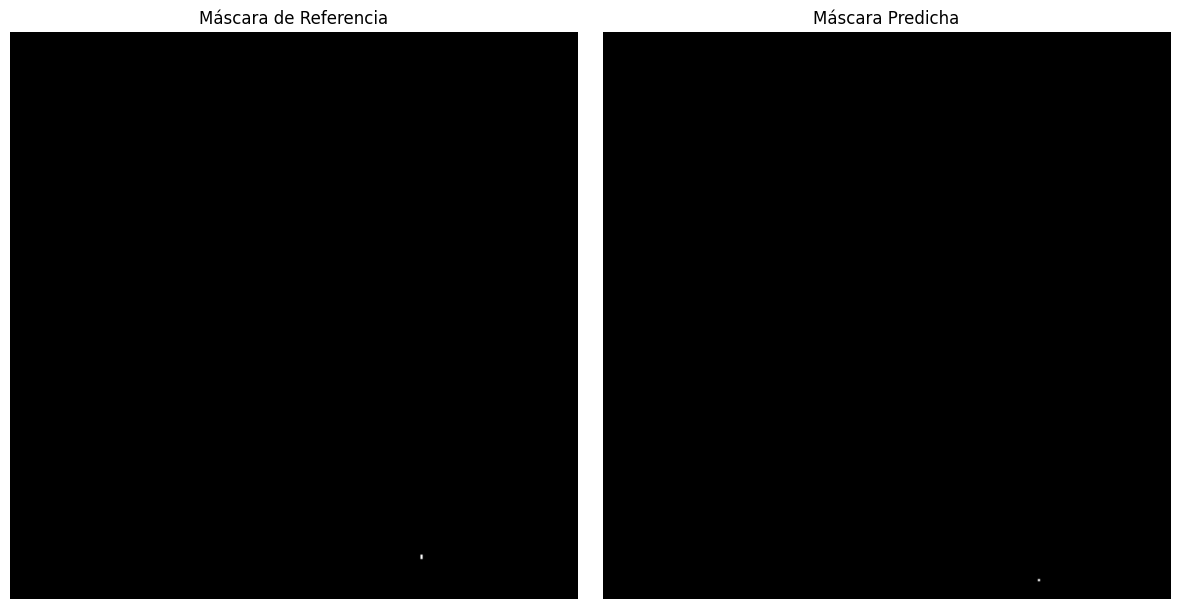

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


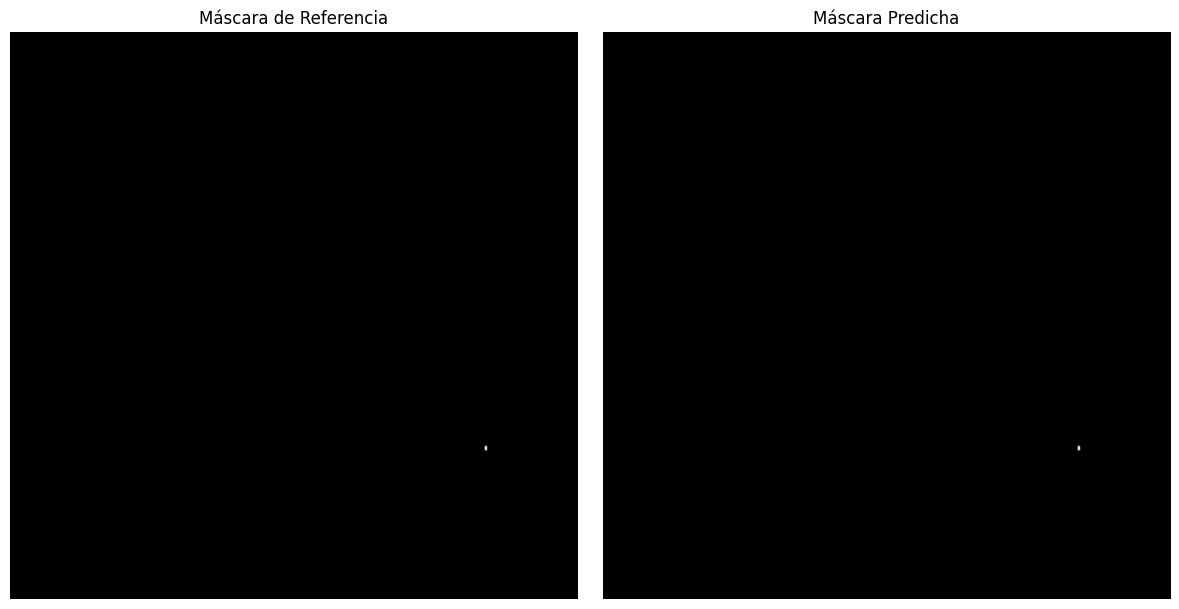

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


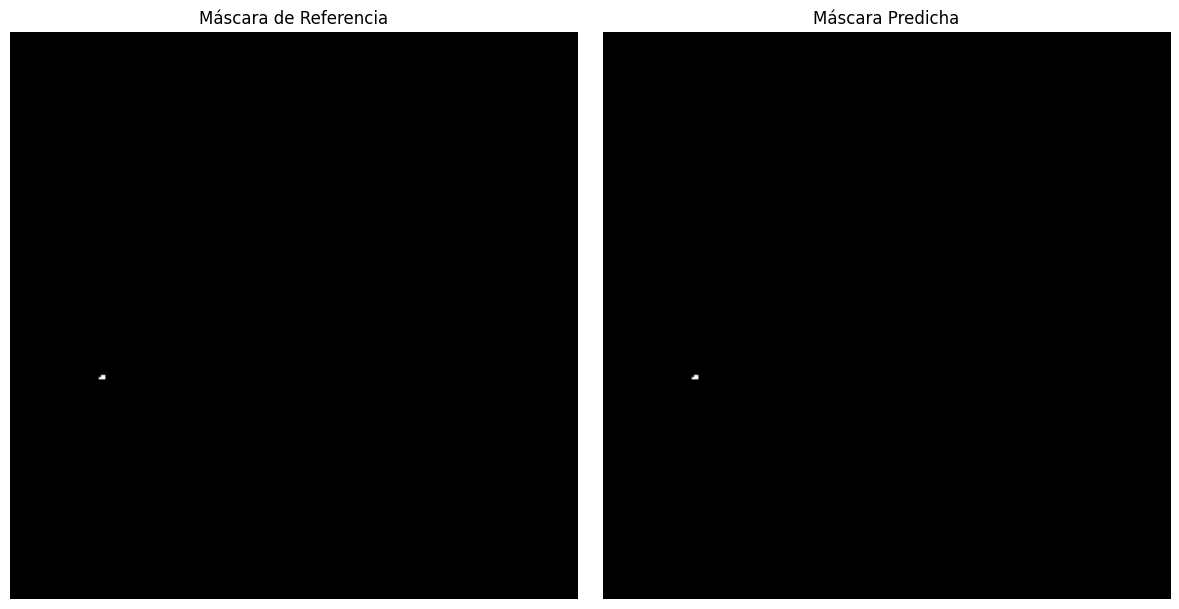

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


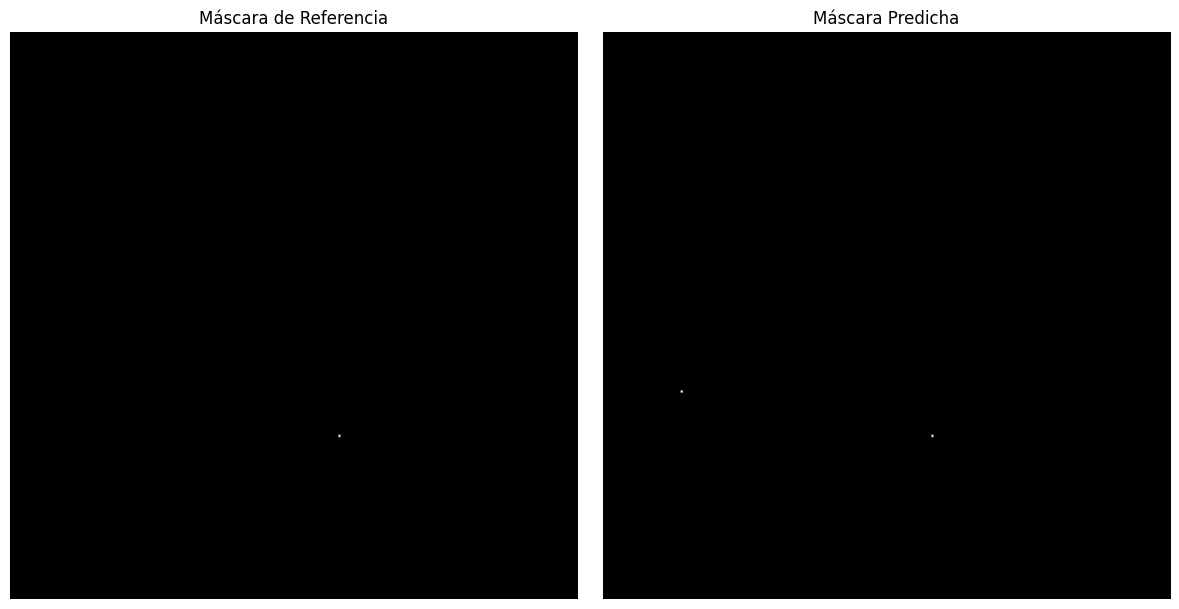

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


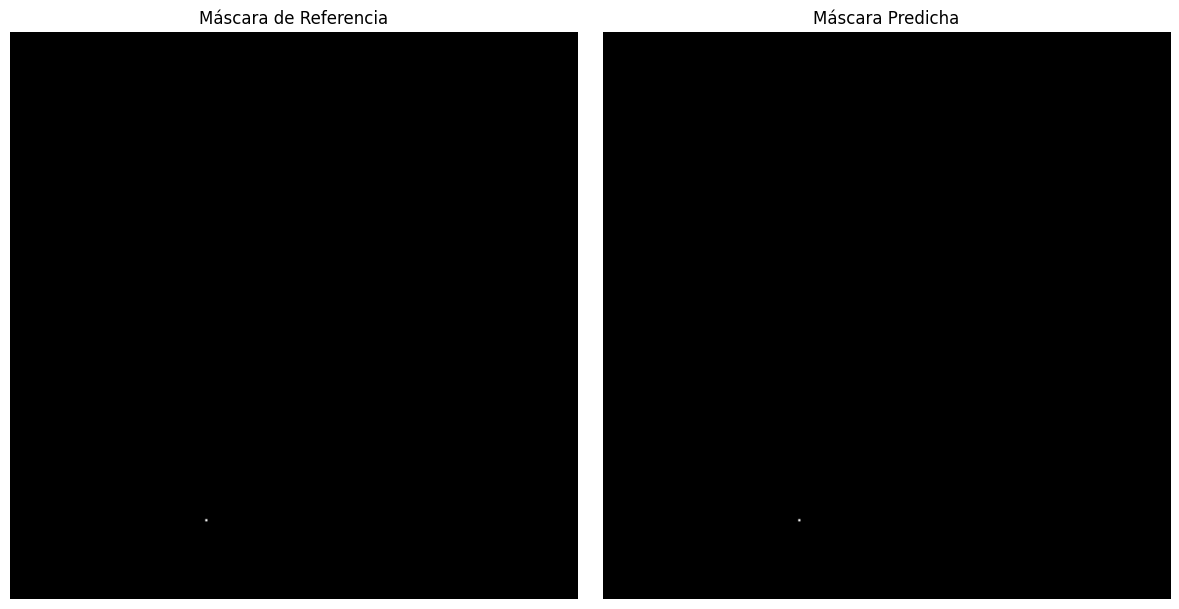

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


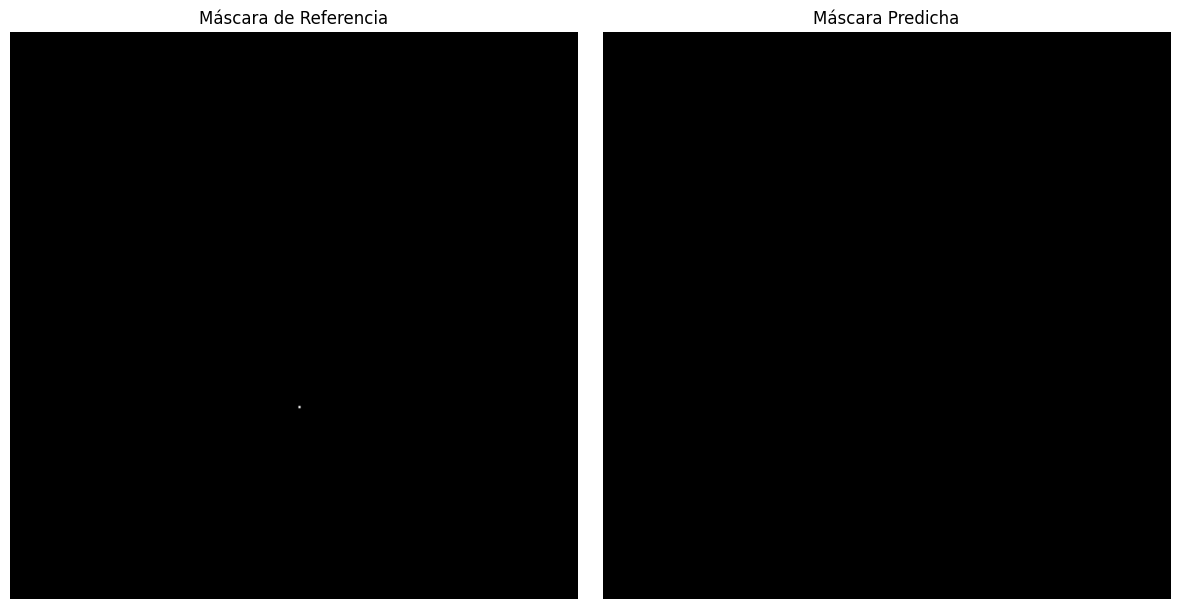

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


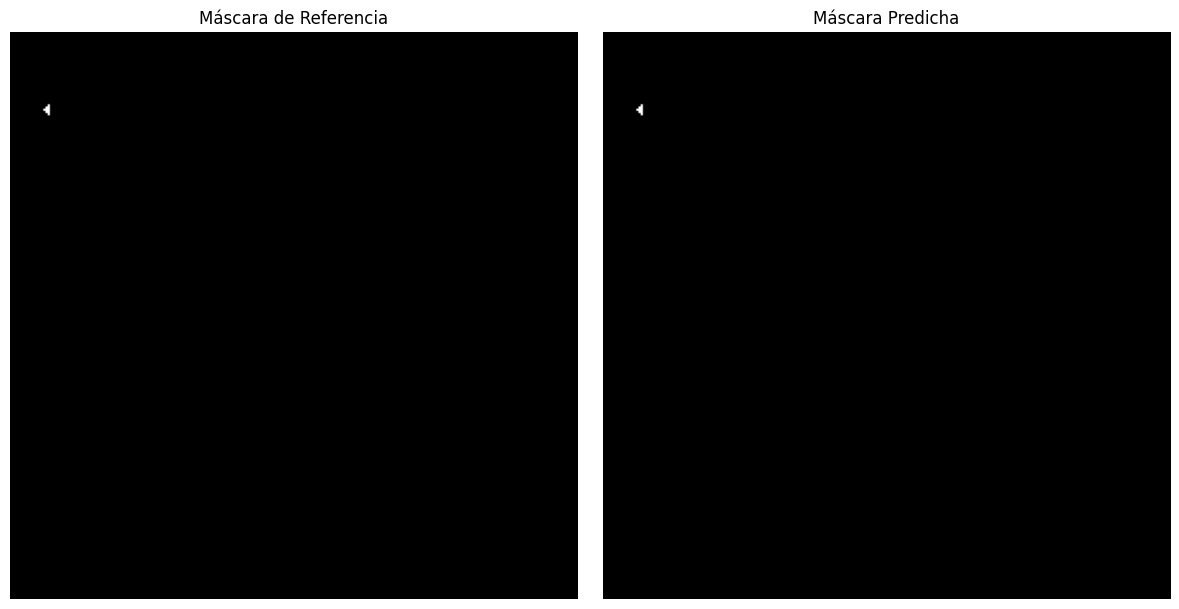

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


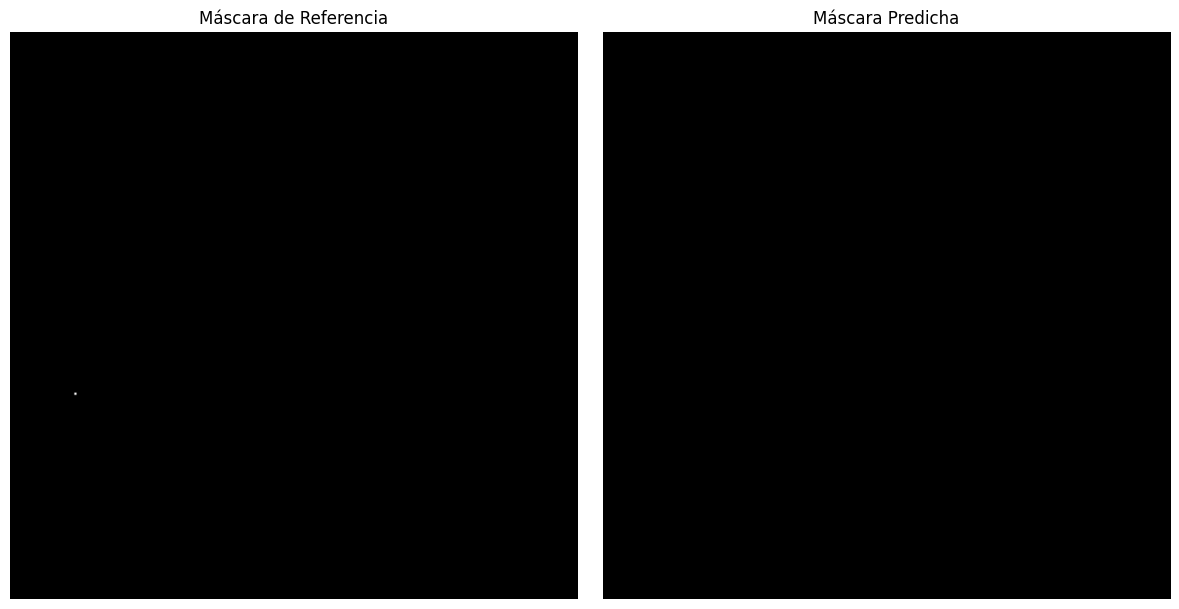

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


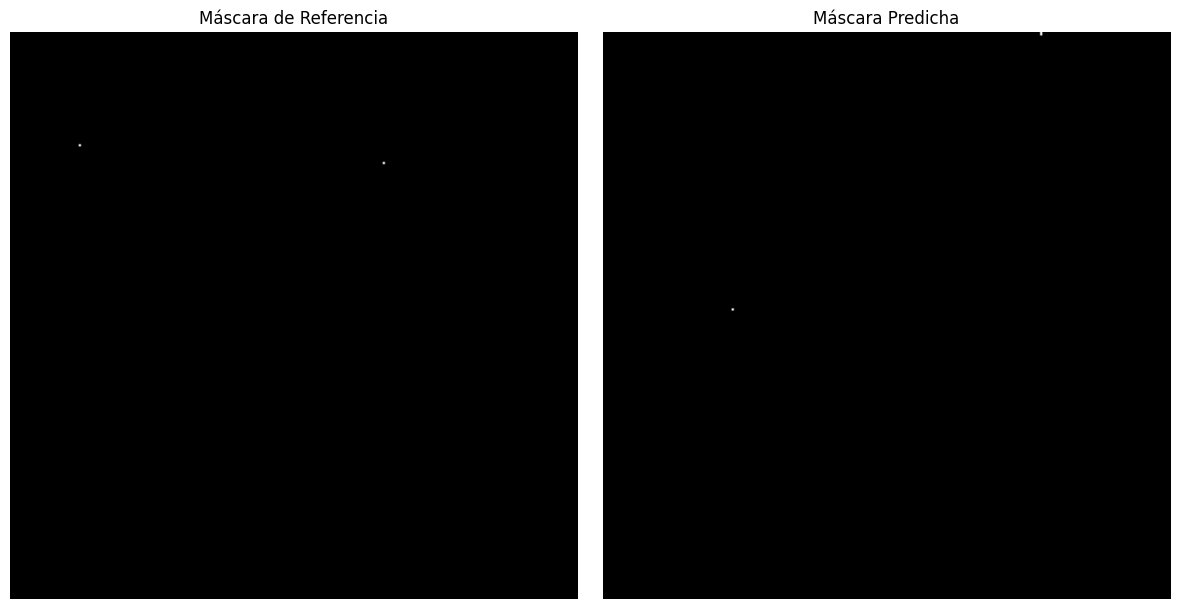

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


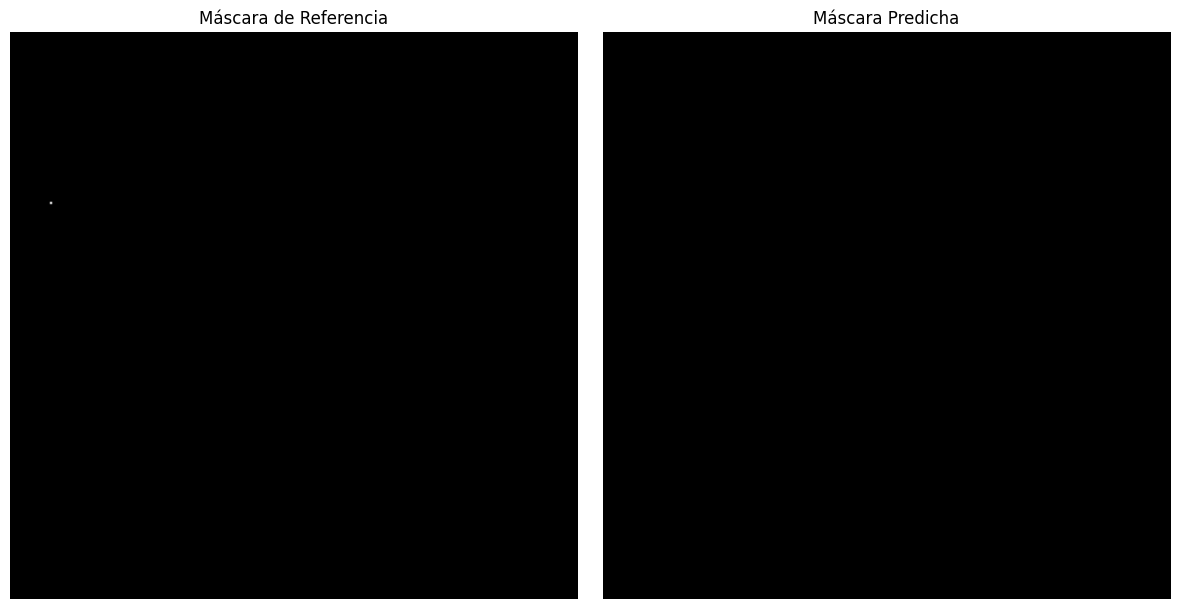

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


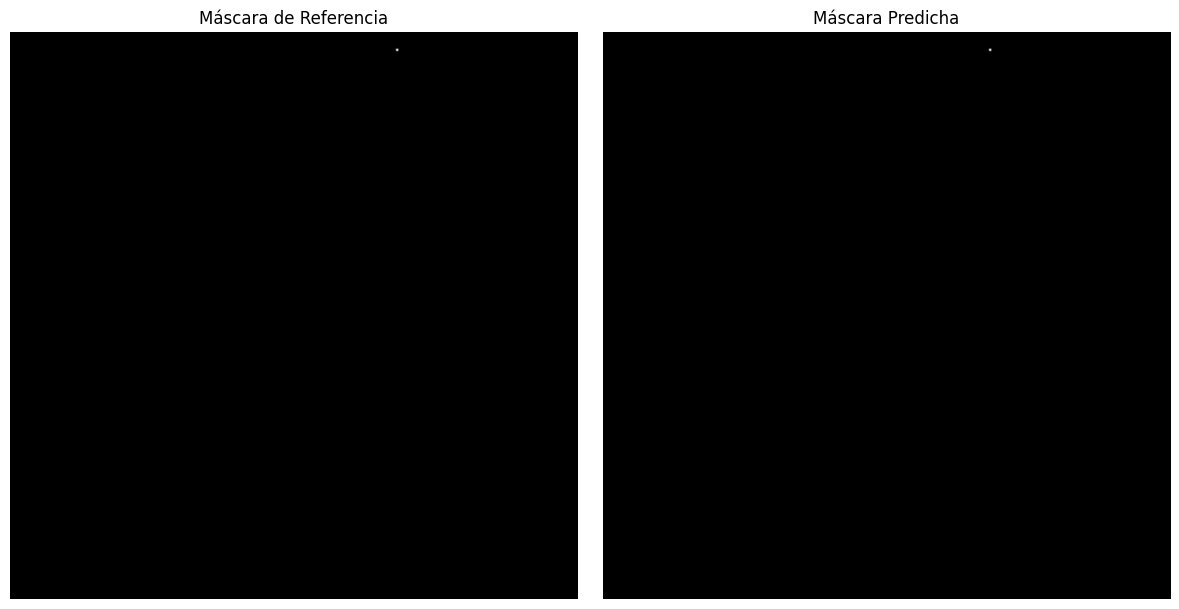

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


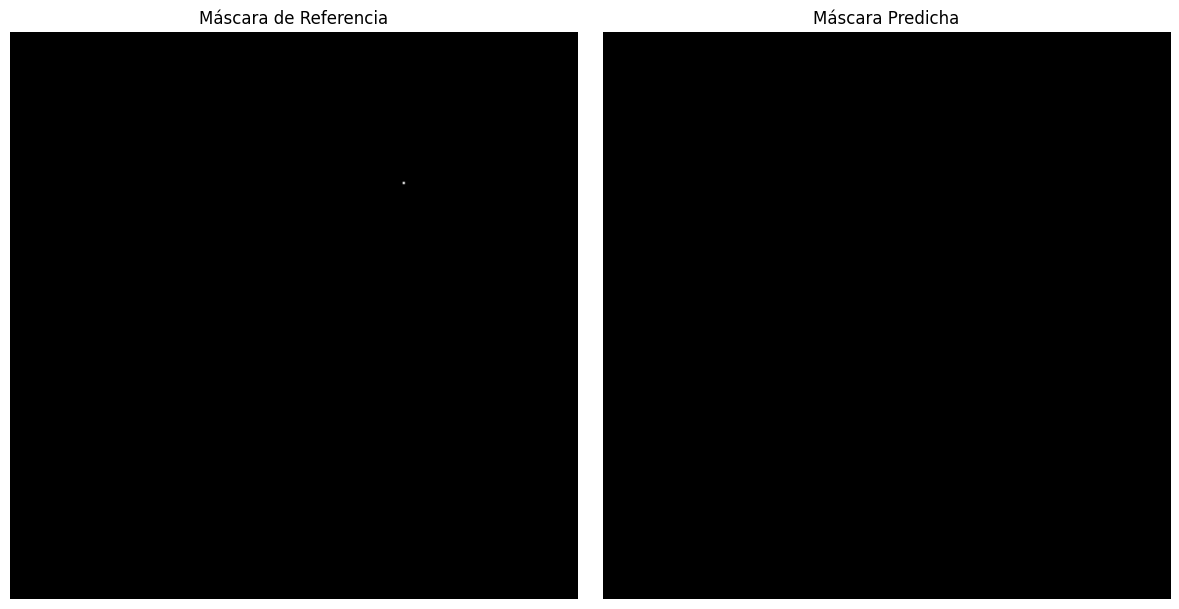

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


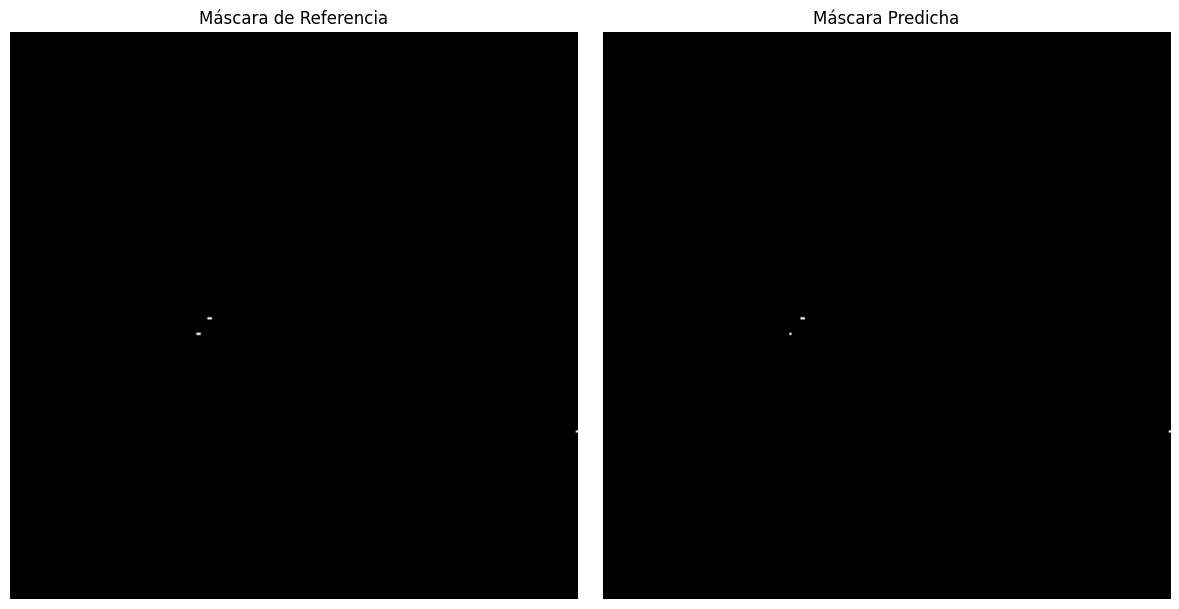

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


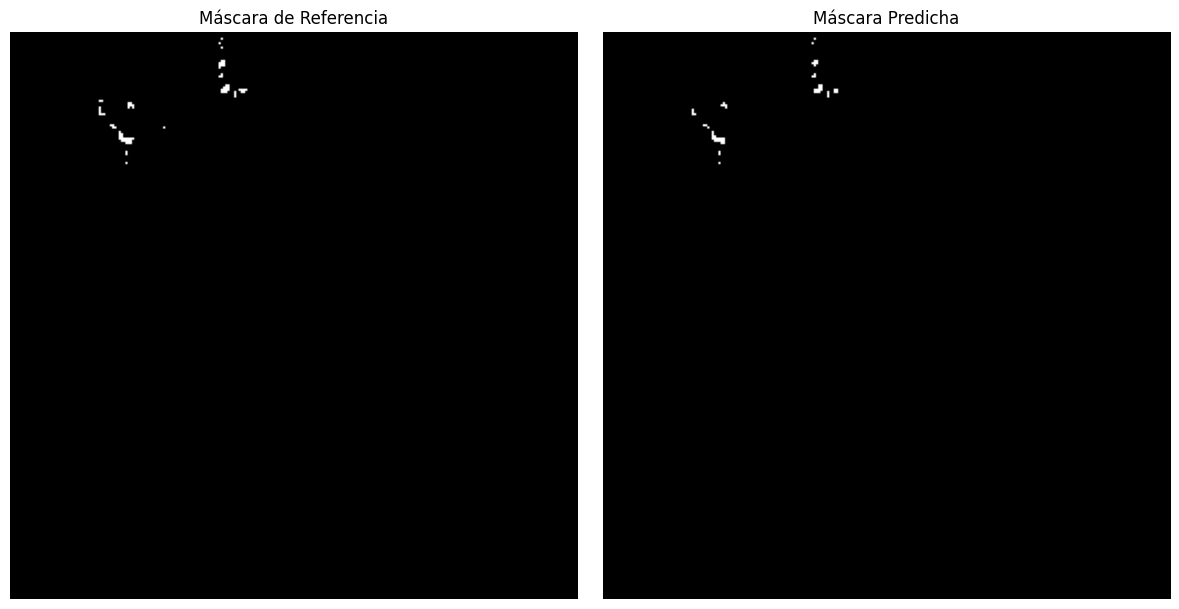

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


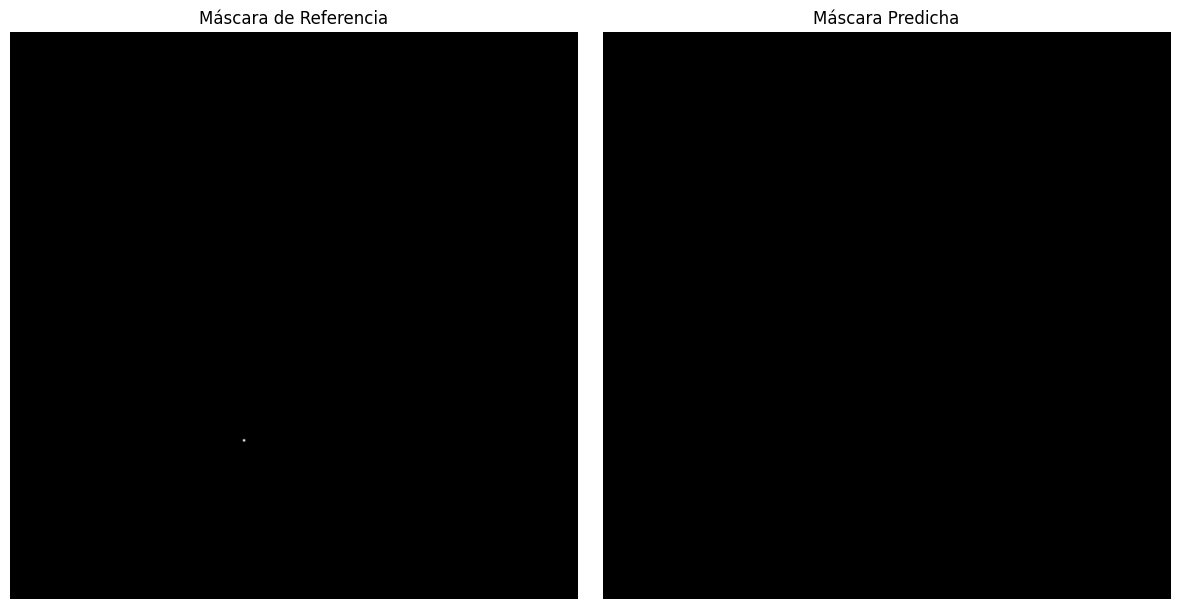

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


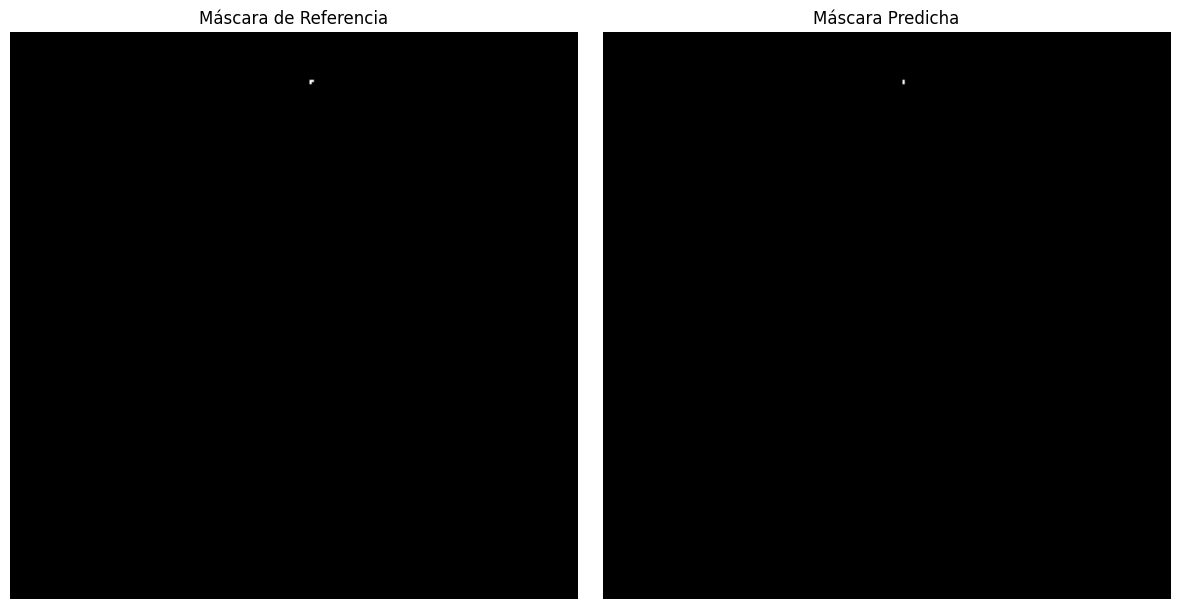

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


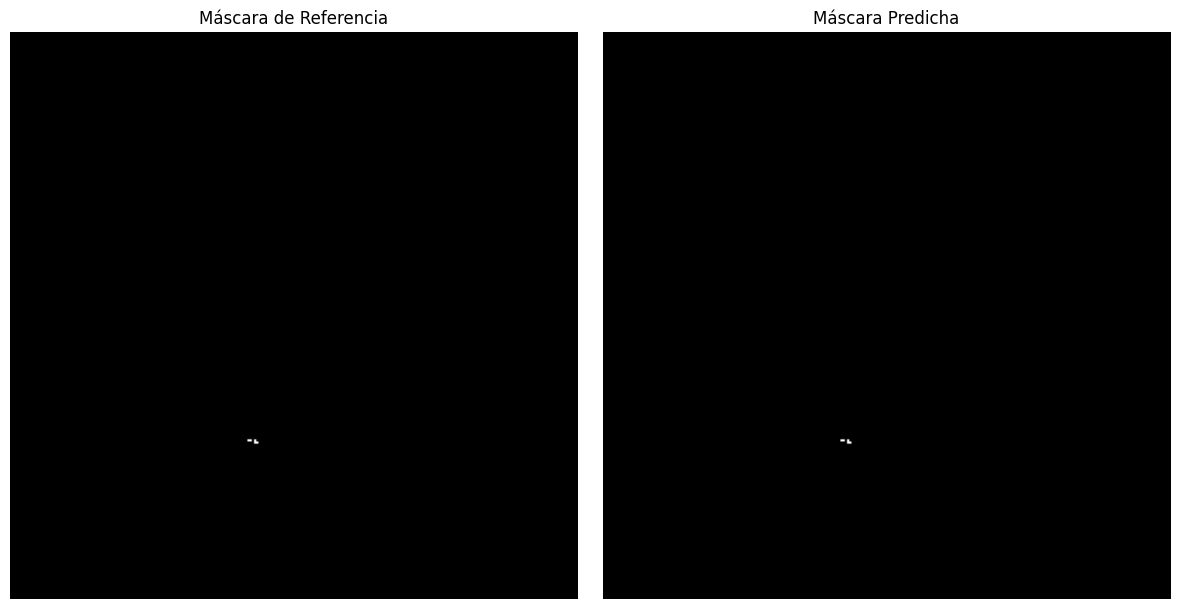

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


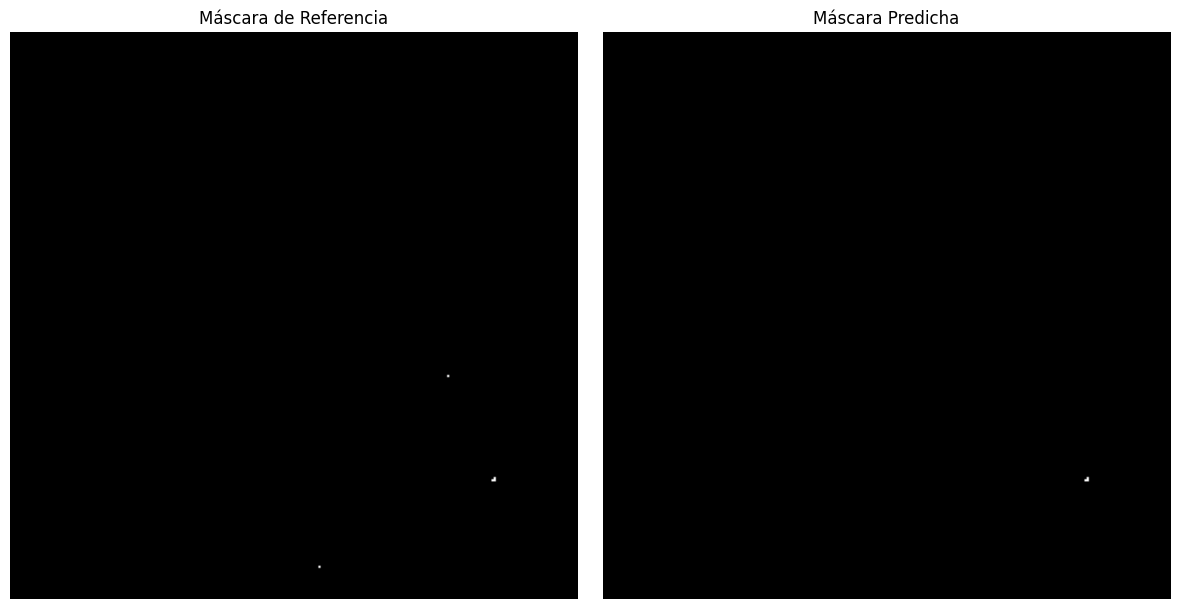

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


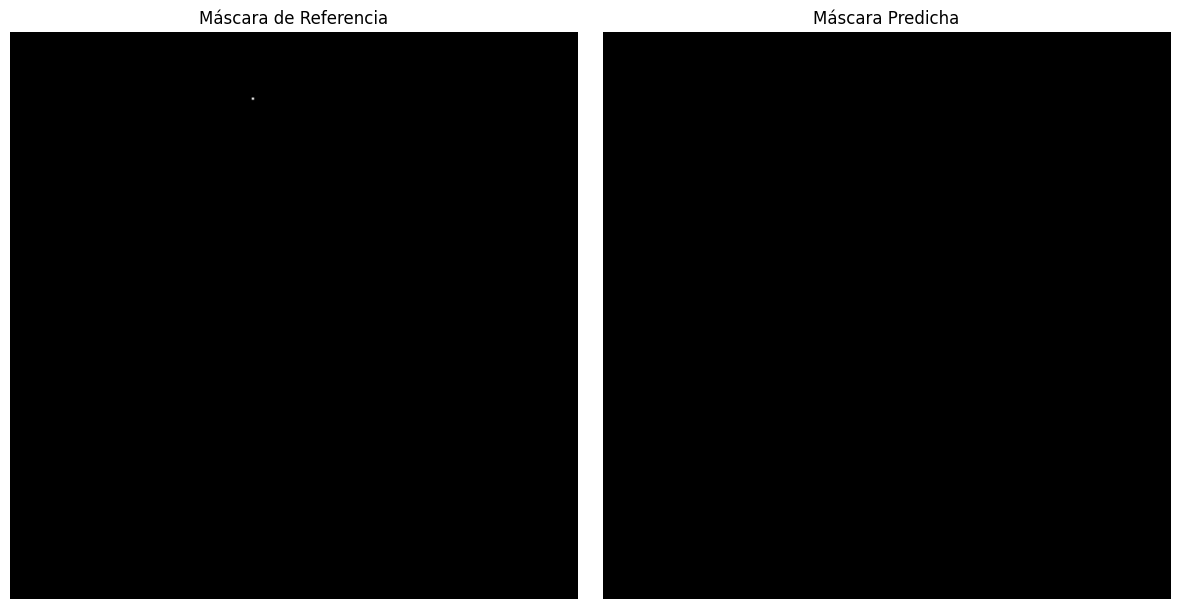

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


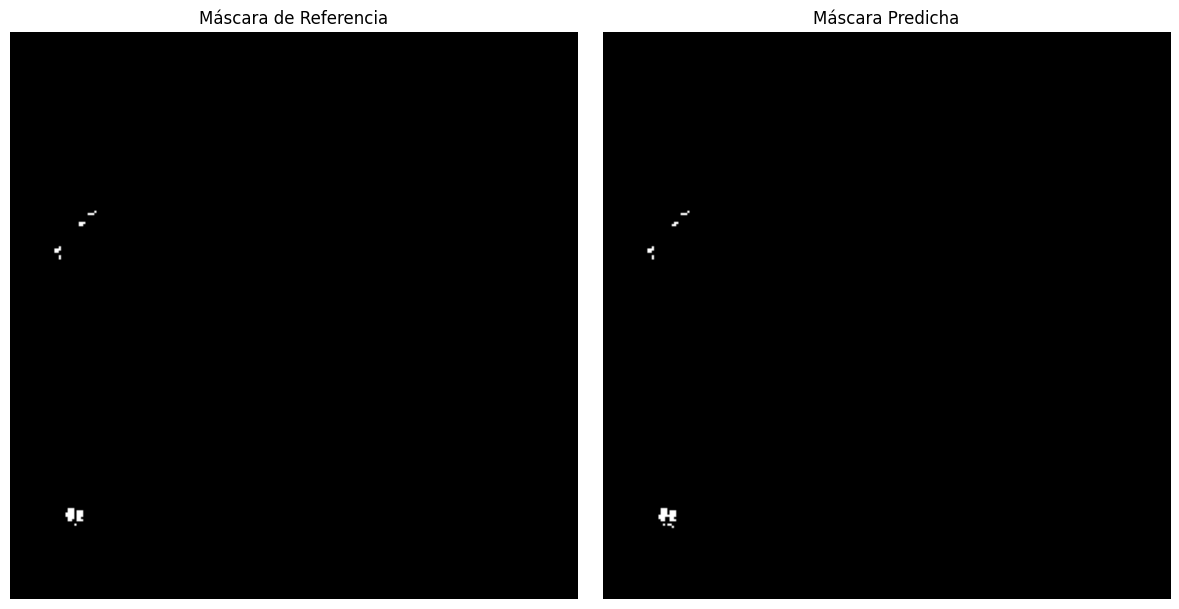

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

def visualize_random_mask_predictions(model, images_csv, masks_csv, img_dir, mask_dir, num_samples=20):
    # Leer los nombres de las imágenes y máscaras desde los CSV
    img_names = pd.read_csv(images_csv)['0'].tolist()
    mask_names = pd.read_csv(masks_csv)['0'].tolist()

    # Combinar en pares (imagen, máscara)
    pairs = list(zip(img_names, mask_names))

    # Seleccionar aleatoriamente num_samples pares
    if len(pairs) < num_samples:
        sampled_pairs = pairs
    else:
        sampled_pairs = random.sample(pairs, num_samples)

    for img_name, mask_name in sampled_pairs:
        # Construir rutas completas para la imagen y la máscara
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        # Cargar la imagen (suponiendo que es un arreglo NumPy con forma (H, W, canales))
        image = np.load(img_path)
        # Cargar la máscara de referencia usando rasterio (forma: (H, W))
        mask_true = rasterio.open(mask_path).read(1)

        H, W, channels = image.shape
        n_pixels = H * W

        # Remodelar la imagen a (n_pixels, channels) para poder hacer la predicción
        image_pixels = image.reshape(n_pixels, channels)

        # Predecir las etiquetas para cada píxel
        mask_pred = model.predict(image_pixels)
        # Reconstruir la forma original de la máscara predicha
        mask_pred = mask_pred.reshape(H, W)

        # Visualizar solo las máscaras: referencia y predicha
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].imshow(mask_true, cmap='gray')
        axs[0].set_title("Máscara de Referencia")
        axs[0].axis('off')

        axs[1].imshow(mask_pred, cmap='gray')
        axs[1].set_title("Máscara Predicha")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

visualize_random_mask_predictions(rf_model,
                                  './dataset/images_test.csv',
                                  './dataset/masks_test.csv',
                                  IMAGES_PATH,
                                  MASKS_PATH,
                                  num_samples=20)

# TRANSFER LEARNING

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Cargar el modelo guardado
model = load_model('UnetV2_final_model.h5', compile=False)  # Evita recompilar aquí

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = [CategoricalAccuracy(), precision, recall, MeanIoU(num_classes=2), F1Score()])

In [ ]:
import os
import pandas as pd
import rasterio
import numpy as np
import tensorflow
from tensorflow.keras.utils import to_categorical

IMAGES_PATH = './dataset/manual_annotations/unziped/landsat_patches/'
MASKS_PATH = './dataset/manual_annotations/unziped/manual_annotations_patches/'

MASK_ALGORITHM = 'Kumar-Roy'

MAX_PIXEL_VALUE = 65535

def get_img_762bands(path):
    img = rasterio.open(path).read((1, 2, 3)).transpose((1, 2, 0))
    ratio = np.divide(img[:,:,0], img[:,:,2], out=np.zeros_like(img[:,:,0], dtype=np.float32), where=(img[:,:,2] != 0))
    img = np.stack((img[:, :, 0], img[:, :, 1], img[:, :, 2], ratio), axis=-1)
    img = np.float32(img) / MAX_PIXEL_VALUE
    return img

def convert_to_one_hot(mask, num_classes=2):
        # Crea una máscara one-hot a partir de las máscaras binarias (0, 1)
        return np.squeeze(np.eye(num_classes)[mask.astype(int)])

class DataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, images_csv, masks_csv, batch_size, img_dir=IMAGES_PATH, mask_dir=MASKS_PATH, image_size=(256, 256)):
        # Leer las rutas de las imágenes y máscaras desde los CSV
        self.img_paths = pd.read_csv(images_csv)['images'].tolist()
        self.mask_paths = pd.read_csv(masks_csv)['masks'].tolist()

        self.batch_size = batch_size
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_size = image_size

    def __len__(self):
        # Devuelve el número total de lotes por epoch
        return int(np.floor(len(self.img_paths) / self.batch_size))

    def __getitem__(self, idx):
        # Obtener el índice de lote
        batch_img_paths = self.img_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prealocar
        images = np.empty((self.batch_size, *self.image_size, 4), dtype=np.float32)  # suponiendo 4 canales
        masks  = np.empty((self.batch_size, *self.image_size, 2), dtype=np.uint8)    # one-hot representation

        # Cargar imágenes y máscaras por lotes
        for i, (img_name, mask_name) in enumerate(zip(batch_img_paths, batch_mask_paths)):
            img_path = img_name
            mask_path = mask_name

            # Cargar imagen
            images[i] = np.load(img_path)

            # Usar with para cargar la máscara
            with rasterio.open(mask_path) as src:
                mask_raw = src.read(1)

            # Convertir la máscara a one hot
            masks[i] = to_categorical(mask_raw, num_classes=2)

        return images, masks

# Parámetros del generador
batch_size = 24
image_size = (256, 256)

# Inicializar generador de entrenamiento
train_generator = DataGenerator(images_csv='./dataset/images_train.csv',
                                masks_csv='./dataset/masks_train.csv',
                                batch_size=batch_size,
                                image_size=image_size)

val_generator = DataGenerator(images_csv='./dataset/images_val.csv',
                              masks_csv='./dataset/masks_val.csv',
                              batch_size=batch_size,
                              image_size=image_size)

test_generator = DataGenerator(images_csv='./dataset/images_test.csv',
                               masks_csv='./dataset/masks_test.csv',
                               batch_size=batch_size,
                               image_size=image_size)

In [ ]:
MASK_ALGORITHM = 'MANUAL_ANNOTATIONS'
EARLY_STOP_PATIENCE = 20
EPOCHS = 50

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, verbose=1)

print('Training using {}...'.format(MASK_ALGORITHM))

# Entrenamiento del modelo (las imágenes ya están en 256x256, no necesitamos redimensionar)
history = model.fit(
    x=train_generator,  # Generador de entrenamiento
    validation_data=val_generator,  # Generador de validación
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping],  # Guardar el mejor modelo y detener el entrenamiento temprano
    verbose=1,
)

# Guardar el modelo final
model.save('UnetV2_final_model_transfer_learning.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 16)   │          1,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 16)   │          3,152 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256, 256, 16)   │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 16)   │          6,416 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 16)   │         12,560 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 16)   │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256, 256, 16)   │             64 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 48,528,418 (185.12 MB)

 Trainable params: 48,519,106 (185.09 MB)

 Non-trainable params: 9,312 (36.38 KB)

Training using MANUAL_ANNOTATIONS...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9975 - f1_score: 0.8508 - loss: 0.0090 - mean_io_u: 0.8648 - precision: 0.8465 - recall: 0.8456
Epoch 1: val_loss improved from inf to 0.00985, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - categorical_accuracy: 0.9975 - f1_score: 0.8515 - loss: 0.0091 - mean_io_u: 0.8599 - precision: 0.8474 - recall: 0.8457 - val_categorical_accuracy: 0.9957 - val_f1_score: 0.8077 - val_loss: 0.0098 - val_mean_io_u: 0.5897 - val_precision: 0.8365 - val_recall: 0.8676
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9966 - f1_score: 0.8412 - loss: 0.0079 - mean_io_u: 0.6797 - precision: 0.8076 - recall: 0.8905
Epoch 2: val_loss improved from 0.00985 to 0.00792, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - categorical_accuracy: 0.9967 - f1_score: 0.8434 - loss: 0.0079 - mean_io_u: 0.6765 - precision: 0.8077 - r

In [ ]:
!cp UnetV2_final_model_transfer_learning.h5 "/content/drive/My Drive/Tesis"

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.MeanIoU(num_classes=2)
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['images'].tolist()
mask_paths = pd.read_csv(masks_csv)['masks'].tolist()

MODEL_PATH = './UnetV2_final_model_transfer_learning.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):

    # Cargar la imagen y la máscara
    image = np.load(img_name)
    mask = rasterio.open(mask_name).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s]

Precision: 0.94792604
Recall: 0.94193035
Accuracy: 0.9979866
IoU: 0.94676983
F1-Score: 0.9449187


Rendimiento UnetV2 Adam 0.001 50 epocas:
Precision: 0.94792604
Recall: 0.94193035
Accuracy: 0.9979866
IoU: 0.94676983
F1-Score: 0.9449187

Rendimiento UnetV2 adam 0.0005 50 epocas:
Precision: 0.9460765
Recall: 0.94143105
Accuracy: 0.9979423
IoU: 0.94569695
F1-Score: 0.94374806

Rendimiento UnetV2 adam 0.001: Precision: 0.94660366
Recall: 0.9080998
Accuracy: 0.99737585
IoU: 0.9305905
F1-Score: 0.926952

Rendimiento UnetV2 adam 0.0005:
Precision: 0.9468532
Recall: 0.9237251
Accuracy: 0.9976509
IoU: 0.93790126
F1-Score: 0.93514615

Rendimiento UnetSDI SMALL
Precision: 0.9116745
Recall: 0.96323186
Accuracy: 0.99808615
IoU: 0.93953687
F1-Score: 0.9367443

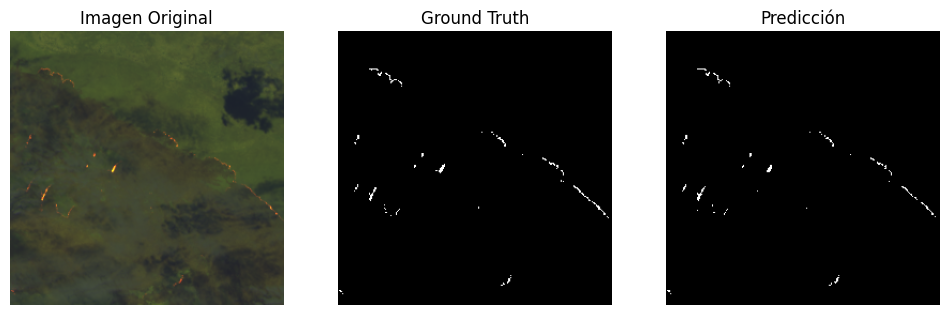

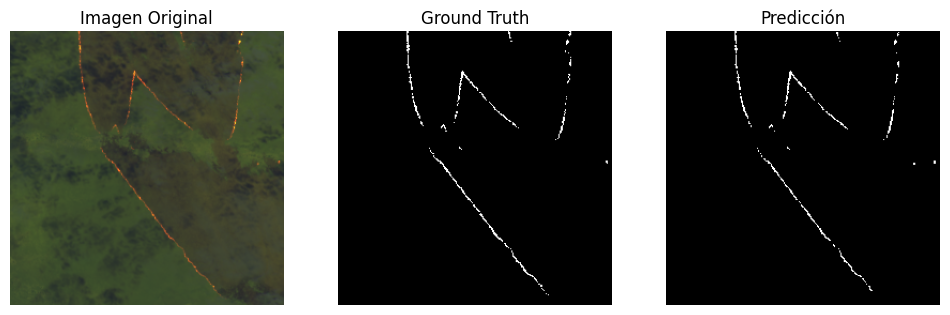

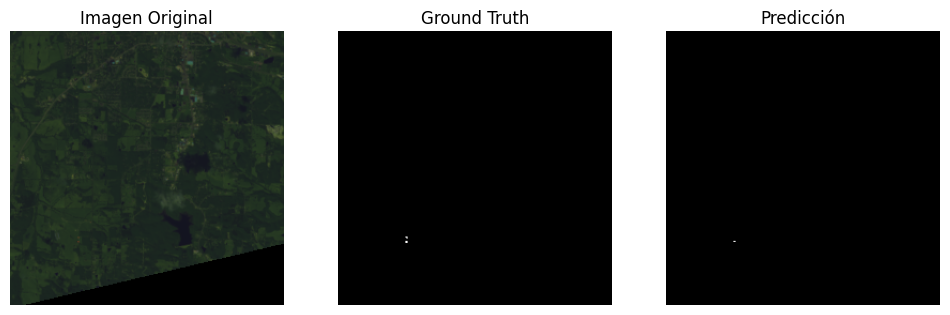

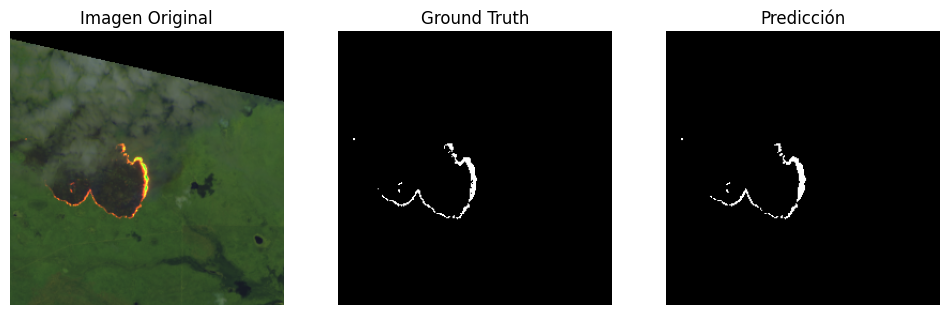

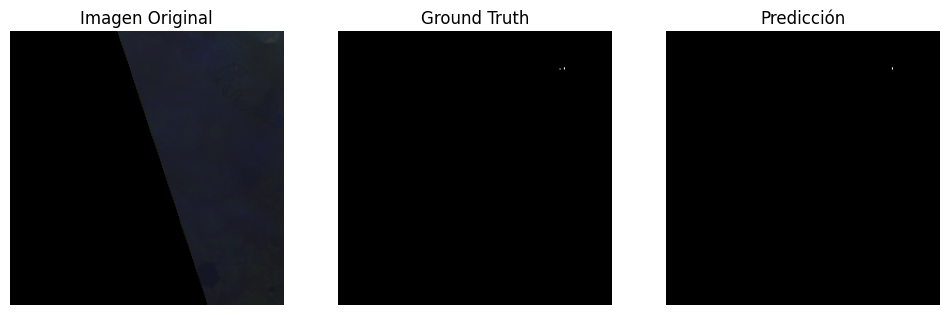

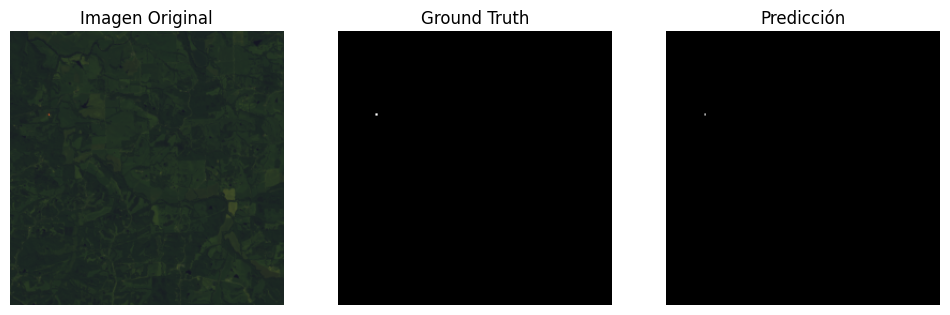

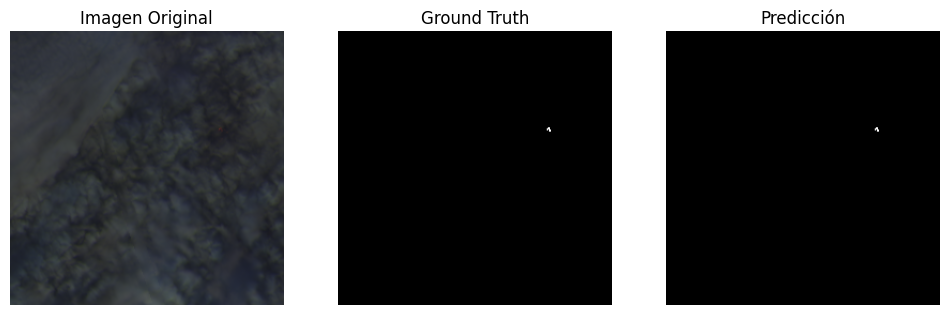

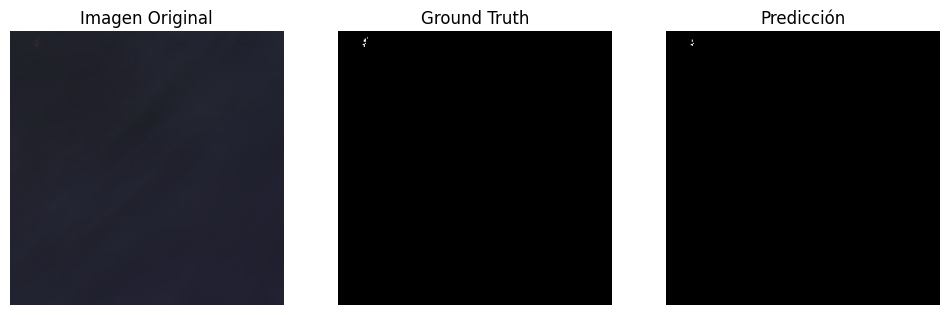

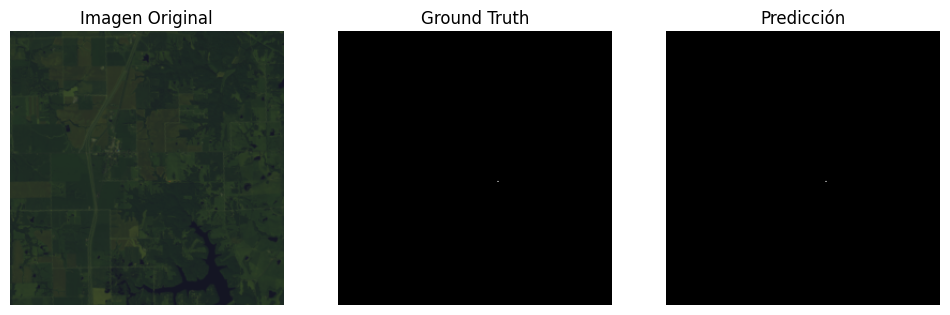

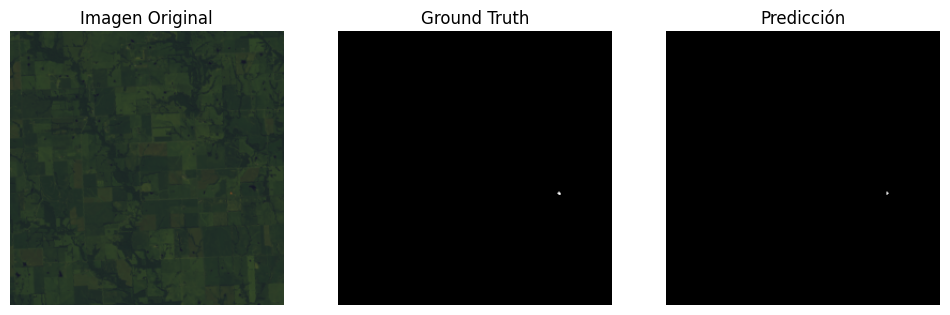

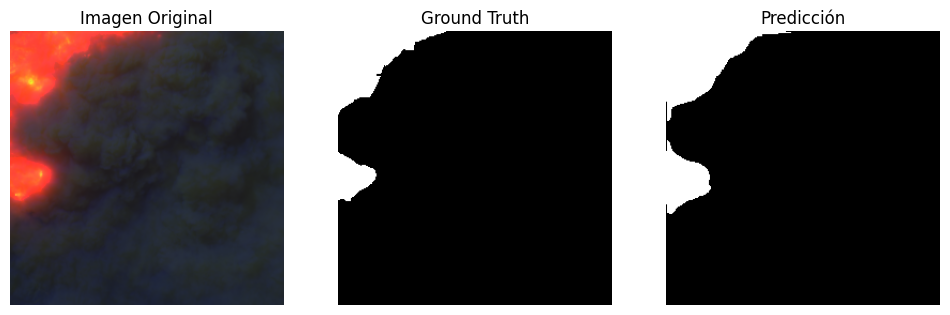

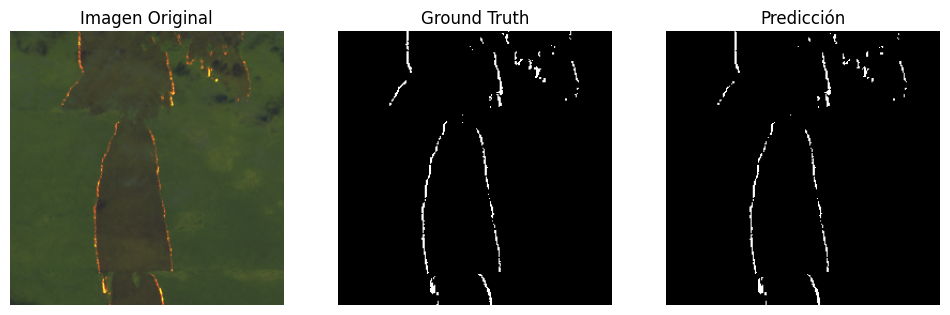

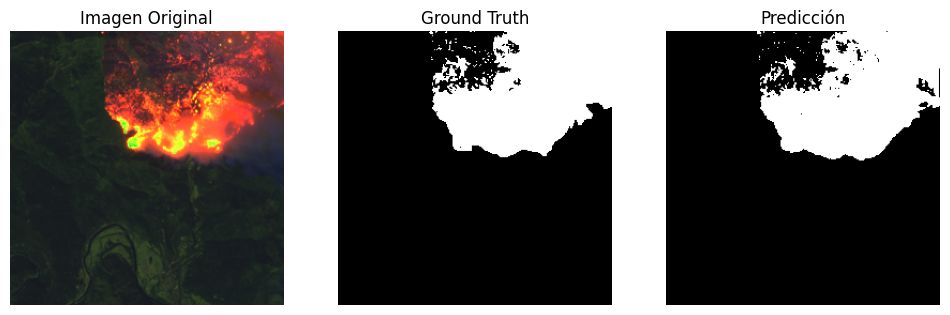

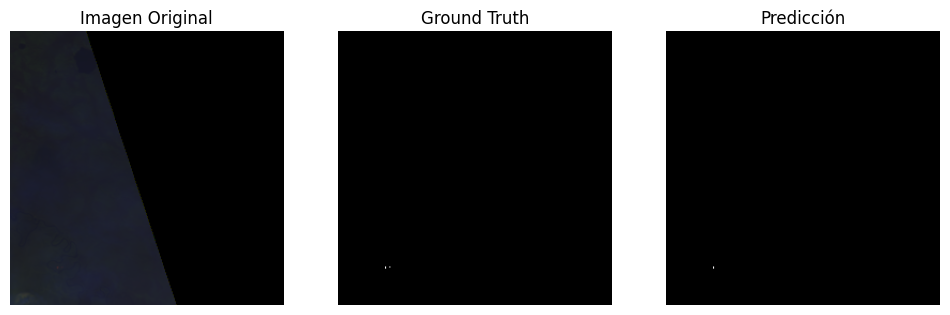

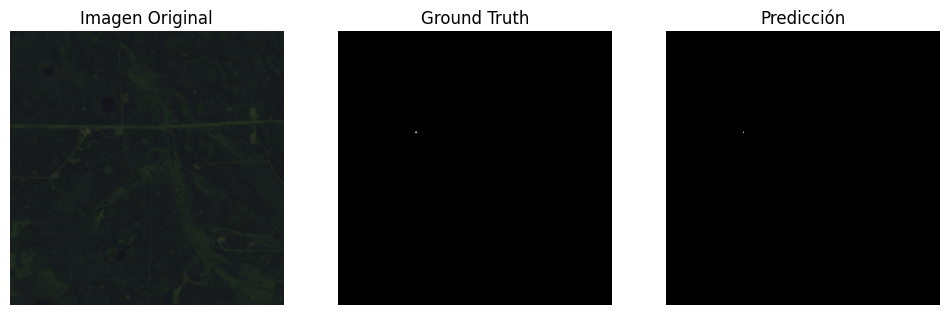

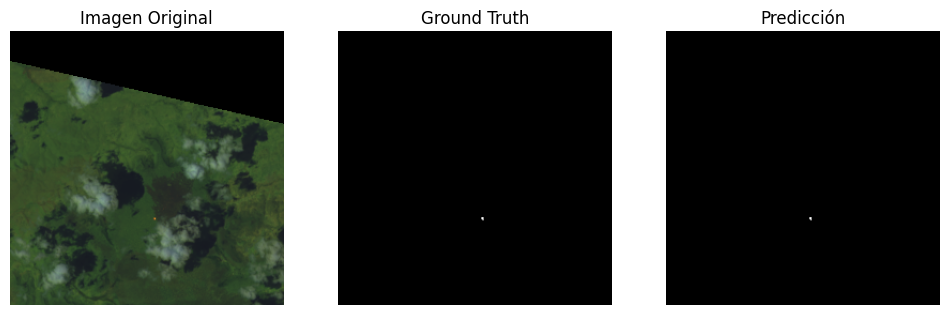

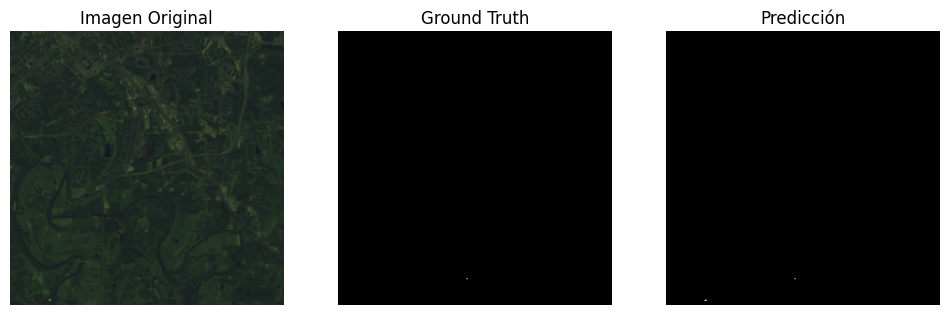

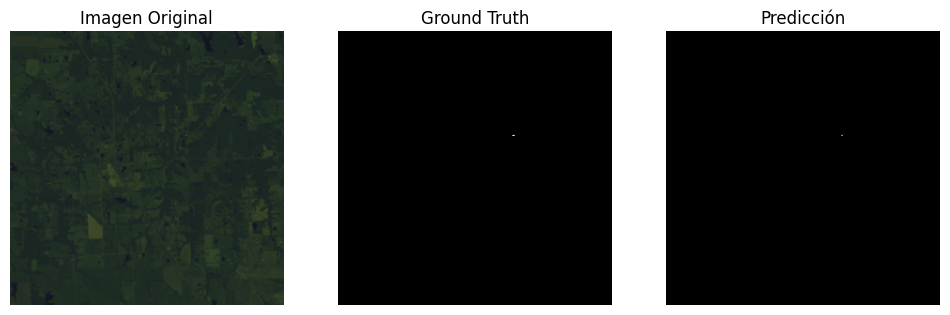

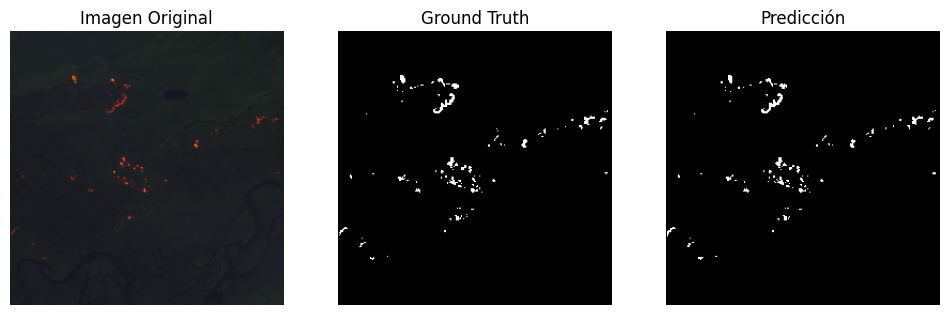

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import load_model
import pandas as pd

MAX_PIXEL_VALUE = 65535

# Configuraciones
MODEL_PATH = './UnetV2_final_model_transfer_learning.h5'  # Reemplaza con la ruta a tu modelo guardado
OUTPUT_DIR = './inferences/'  # Carpeta para guardar los resultados

# Crear la carpeta de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Cargar el modelo
model = load_model(MODEL_PATH)
i=1
for img_name, mask_name in zip(img_paths, mask_paths):
    if i >=20:
      break

    # Cargar la imagen y la máscara
    image = np.load(img_name)
    mask = rasterio.open(mask_name).read(1)#.transpose((1, 2, 0))
    mask = np.float32(mask)

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1)  # Convertir a clases (256x256)
    pred = (pred > 0.5).astype(np.uint8)  # Umbralizar la predicción

    # Guardar resultados
    plt.figure(figsize=(12, 8))

    # Mostrar imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(image[:,:,:3])
    plt.title('Imagen Original')
    plt.axis('off')

    # Mostrar ground truth
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Mostrar predicción
    plt.subplot(1, 3, 3)
    plt.imshow(pred_class, cmap='gray')
    plt.title('Predicción')
    plt.axis('off')

    plt.show()
    i+=1

# MAPA DE RENDIMIENTO POR REGION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Rutas de los archivos existentes
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

# Cargar los nombres de imágenes y máscaras
img_paths = pd.read_csv(images_csv, header=None, names=['image_filename'])
mask_paths = pd.read_csv(masks_csv, header=None, names=['mask_filename'])

# Crear un DataFrame unificado
df_unified = pd.DataFrame({
    'image_filename': img_paths['image_filename'],
    'mask_filename': mask_paths['mask_filename']
})

# Guardar el archivo
df_unified.to_csv('./dataset/test_images_masks.csv', index=False)

print("✅ Archivo test_images_masks.csv creado con éxito.")


✅ Archivo test_images_masks.csv creado con éxito.


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Cargar dataset con la información de Köppen Class
df_koppen = pd.read_csv("./dataset_analysis_with_algorithms_reduced.csv")

# Cargar el CSV que contiene las imágenes y sus máscaras correspondientes
df_test = pd.read_csv('./dataset/test_images_masks.csv')

# Asegurar que `filename` en df_koppen coincida con `image_filename` en df_test
df_test = df_test.merge(df_koppen, left_on='image_filename', right_on='filename', how='left')

# Definir rutas base
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Cargar el modelo entrenado
MODEL_PATH = './drive/My Drive/Tesis/UnetV2_small_final_model.h5'
model = load_model(MODEL_PATH)

# Definir métrica personalizada de F1-Score
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Evaluar por cada Köppen Class
results = []

for koppen_class, group in df_test.groupby('koppen_class'):
    print(f"\nEvaluando Köppen Class: {koppen_class}")

    # Definir métricas para esta clase
    precision_metric = tf.keras.metrics.Precision()
    recall_metric = tf.keras.metrics.Recall()
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    iou_metric = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
    f1_metric = F1Score()

    for img_name, mask_name in tqdm(zip(group['image_filename'], group['mask_filename']), total=len(group), desc=f"Procesando {koppen_class}"):
        img_path = os.path.join(IMAGES_PATH, img_name)
        mask_path = os.path.join(MASKS_PATH, mask_name)

        # Cargar imagen y máscara
        image = np.load(img_path)
        mask = rasterio.open(mask_path).read(1).astype(np.uint8)

        # Convertir a formato one-hot encoding
        mask_one_hot = to_categorical(mask, num_classes=2)
        mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

        # Inferencia del modelo
        pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
        pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()

        # Actualizar métricas
        precision_metric.update_state(mask_flat, pred_class)
        recall_metric.update_state(mask_flat, pred_class)
        accuracy_metric.update_state(mask_one_hot, pred)
        iou_metric.update_state(mask_flat, pred_class)
        f1_metric.update_state(mask_flat, pred_class)

    # Obtener resultados para esta Köppen Class
    print(iou_metric.result().numpy())
    results.append({
        'koppen_class': koppen_class,
        'precision': precision_metric.result().numpy(),
        'recall': recall_metric.result().numpy(),
        'accuracy': accuracy_metric.result().numpy(),
        'iou': iou_metric.result().numpy(),
        'f1_score': f1_metric.result().numpy()
    })

# Convertir a DataFrame y guardar los resultados
df_results = pd.DataFrame(results)
df_results.to_csv("koppen_class_metrics.csv", index=False)

# Mostrar resultados
print("\nResultados por Köppen Class:")
print(df_results)


Evaluando Köppen Class: 0.0


Procesando 0.0: 100%|██████████| 92/92 [00:16<00:00,  5.59it/s]


0.48275855

Evaluando Köppen Class: 1.0


Procesando 1.0: 100%|██████████| 983/983 [02:34<00:00,  6.34it/s]


0.7277822

Evaluando Köppen Class: 2.0


Procesando 2.0: 100%|██████████| 1188/1188 [03:17<00:00,  6.01it/s]


0.77954274

Evaluando Köppen Class: 3.0


Procesando 3.0: 100%|██████████| 1911/1911 [05:18<00:00,  6.00it/s]


0.86323285

Evaluando Köppen Class: 4.0


Procesando 4.0: 100%|██████████| 940/940 [02:36<00:00,  6.00it/s]


0.6367687

Evaluando Köppen Class: 5.0


Procesando 5.0: 100%|██████████| 677/677 [01:51<00:00,  6.05it/s]


0.6836574

Evaluando Köppen Class: 6.0


Procesando 6.0: 100%|██████████| 1289/1289 [03:36<00:00,  5.96it/s]


0.8196737

Evaluando Köppen Class: 7.0


Procesando 7.0: 100%|██████████| 1578/1578 [04:23<00:00,  5.99it/s]


0.6954073

Evaluando Köppen Class: 8.0


Procesando 8.0: 100%|██████████| 942/942 [02:40<00:00,  5.86it/s]


0.71093744

Evaluando Köppen Class: 9.0


Procesando 9.0: 100%|██████████| 458/458 [01:16<00:00,  5.98it/s]


0.7349896

Evaluando Köppen Class: 11.0


Procesando 11.0: 100%|██████████| 1276/1276 [03:34<00:00,  5.94it/s]


0.8097506

Evaluando Köppen Class: 12.0


Procesando 12.0: 100%|██████████| 846/846 [02:20<00:00,  6.01it/s]


0.7803559

Evaluando Köppen Class: 13.0


Procesando 13.0: 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


0.9999999

Evaluando Köppen Class: 14.0


Procesando 14.0: 100%|██████████| 1692/1692 [04:44<00:00,  5.94it/s]


0.70276296

Evaluando Köppen Class: 15.0


Procesando 15.0: 100%|██████████| 1193/1193 [03:19<00:00,  5.97it/s]


0.67468536

Evaluando Köppen Class: 16.0


Procesando 16.0: 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


0.6666666

Evaluando Köppen Class: 17.0


Procesando 17.0: 100%|██████████| 142/142 [00:23<00:00,  6.00it/s]


0.60659593

Evaluando Köppen Class: 18.0


Procesando 18.0: 100%|██████████| 152/152 [00:26<00:00,  5.73it/s]


0.7830964

Evaluando Köppen Class: 19.0


Procesando 19.0: 100%|██████████| 26/26 [00:04<00:00,  5.77it/s]


0.6666666

Evaluando Köppen Class: 20.0


Procesando 20.0: 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]


0.39999995

Evaluando Köppen Class: 21.0


Procesando 21.0: 100%|██████████| 612/612 [01:44<00:00,  5.86it/s]


0.69634587

Evaluando Köppen Class: 22.0


Procesando 22.0: 100%|██████████| 595/595 [01:39<00:00,  5.97it/s]


0.6759765

Evaluando Köppen Class: 23.0


Procesando 23.0: 100%|██████████| 337/337 [00:55<00:00,  6.05it/s]


0.69332075

Evaluando Köppen Class: 24.0


Procesando 24.0: 100%|██████████| 114/114 [00:18<00:00,  6.09it/s]


0.8370791

Evaluando Köppen Class: 25.0


Procesando 25.0: 100%|██████████| 1112/1112 [03:08<00:00,  5.89it/s]


0.67994034

Evaluando Köppen Class: 26.0


Procesando 26.0: 100%|██████████| 1733/1733 [04:51<00:00,  5.95it/s]


0.69283617

Evaluando Köppen Class: 27.0


Procesando 27.0: 100%|██████████| 806/806 [02:20<00:00,  5.75it/s]


0.86477834

Evaluando Köppen Class: 28.0


Procesando 28.0: 100%|██████████| 84/84 [00:14<00:00,  5.84it/s]


0.8170447

Evaluando Köppen Class: 29.0


Procesando 29.0: 100%|██████████| 413/413 [01:09<00:00,  5.91it/s]


0.5859872

Evaluando Köppen Class: 30.0


Procesando 30.0: 100%|██████████| 28/28 [00:04<00:00,  5.98it/s]


0.00074460154

Resultados por Köppen Class:
    koppen_class  precision    recall  accuracy       iou  f1_score
0            0.0   0.494118  0.954545  0.999948  0.482759  0.651163
1            1.0   0.831910  0.853254  0.999987  0.727782  0.842447
2            2.0   0.851348  0.902368  0.999979  0.779543  0.876116
3            3.0   0.896355  0.958951  0.999964  0.863233  0.926597
4            4.0   0.762172  0.794667  0.999950  0.636769  0.778080
5            5.0   0.771231  0.857564  0.999955  0.683657  0.812110
6            6.0   0.862121  0.943336  0.999983  0.819674  0.900902
7            7.0   0.773907  0.872706  0.999965  0.695407  0.820342
8            8.0   0.769341  0.903522  0.999971  0.710937  0.831050
9            9.0   0.814220  0.883085  0.999966  0.734990  0.847255
10          11.0   0.879406  0.910899  0.999971  0.809751  0.894875
11          12.0   0.839747  0.916900  0.999977  0.780356  0.876629
12          13.0   1.000000  1.000000  1.000000  1.000000  1.000000
13  

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Cargar dataset con la información de Köppen Class
df_koppen = pd.read_csv("./dataset_analysis_with_algorithms_reduced.csv")

# Cargar el CSV que contiene las imágenes y sus máscaras correspondientes
df_test = pd.read_csv('./dataset/test_images_masks.csv')

# Asegurar que `filename` en df_koppen coincida con `image_filename` en df_test
df_test = df_test.merge(df_koppen, left_on='image_filename', right_on='filename', how='left')

# Definir rutas base
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Cargar el modelo entrenado
MODEL_PATH = './drive/My Drive/Tesis/UnetV2_final_model.h5'
model = load_model(MODEL_PATH)

# Definir métrica personalizada de F1-Score
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Evaluar por cada Köppen Class
results = []

for koppen_class, group in df_test.groupby('koppen_class'):
    print(f"\nEvaluando Köppen Class: {koppen_class}")

    # Definir métricas para esta clase
    precision_metric = tf.keras.metrics.Precision()
    recall_metric = tf.keras.metrics.Recall()
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    iou_metric = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
    f1_metric = F1Score()

    for img_name, mask_name in tqdm(zip(group['image_filename'], group['mask_filename']), total=len(group), desc=f"Procesando {koppen_class}"):
        img_path = os.path.join(IMAGES_PATH, img_name)
        mask_path = os.path.join(MASKS_PATH, mask_name)

        # Cargar imagen y máscara
        image = np.load(img_path)
        mask = rasterio.open(mask_path).read(1).astype(np.uint8)

        # Convertir a formato one-hot encoding
        mask_one_hot = to_categorical(mask, num_classes=2)
        mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

        # Inferencia del modelo
        pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
        pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()

        # Actualizar métricas
        precision_metric.update_state(mask_flat, pred_class)
        recall_metric.update_state(mask_flat, pred_class)
        accuracy_metric.update_state(mask_one_hot, pred)
        iou_metric.update_state(mask_flat, pred_class)
        f1_metric.update_state(mask_flat, pred_class)

    # Obtener resultados para esta Köppen Class
    print(iou_metric.result().numpy())
    results.append({
        'koppen_class': koppen_class,
        'precision': precision_metric.result().numpy(),
        'recall': recall_metric.result().numpy(),
        'accuracy': accuracy_metric.result().numpy(),
        'iou': iou_metric.result().numpy(),
        'f1_score': f1_metric.result().numpy()
    })

# Convertir a DataFrame y guardar los resultados
df_results = pd.DataFrame(results)
df_results.to_csv("koppen_class_metrics.csv", index=False)

# Mostrar resultados
print("\nResultados por Köppen Class:")
print(df_results)


Evaluando Köppen Class: 0.0


Procesando 0.0: 100%|██████████| 92/92 [00:33<00:00,  2.74it/s]


0.52083325

Evaluando Köppen Class: 1.0


Procesando 1.0: 100%|██████████| 983/983 [03:15<00:00,  5.04it/s]


0.7382475

Evaluando Köppen Class: 2.0


Procesando 2.0: 100%|██████████| 1188/1188 [04:00<00:00,  4.94it/s]


0.7922172

Evaluando Köppen Class: 3.0


Procesando 3.0: 100%|██████████| 1911/1911 [06:30<00:00,  4.89it/s]


0.85388947

Evaluando Köppen Class: 4.0


Procesando 4.0: 100%|██████████| 940/940 [03:13<00:00,  4.87it/s]


0.6157908

Evaluando Köppen Class: 5.0


Procesando 5.0: 100%|██████████| 677/677 [02:20<00:00,  4.83it/s]


0.67073387

Evaluando Köppen Class: 6.0


Procesando 6.0: 100%|██████████| 1289/1289 [04:25<00:00,  4.86it/s]


0.8077748

Evaluando Köppen Class: 7.0


Procesando 7.0: 100%|██████████| 1578/1578 [05:25<00:00,  4.85it/s]


0.69350624

Evaluando Köppen Class: 8.0


Procesando 8.0: 100%|██████████| 942/942 [03:15<00:00,  4.82it/s]


0.70017177

Evaluando Köppen Class: 9.0


Procesando 9.0: 100%|██████████| 458/458 [01:34<00:00,  4.85it/s]


0.7160288

Evaluando Köppen Class: 11.0


Procesando 11.0: 100%|██████████| 1276/1276 [04:20<00:00,  4.89it/s]


0.78342766

Evaluando Köppen Class: 12.0


Procesando 12.0: 100%|██████████| 846/846 [02:55<00:00,  4.82it/s]


0.7678323

Evaluando Köppen Class: 13.0


Procesando 13.0: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


0.7142857

Evaluando Köppen Class: 14.0


Procesando 14.0: 100%|██████████| 1692/1692 [05:47<00:00,  4.87it/s]


0.68859595

Evaluando Köppen Class: 15.0


Procesando 15.0: 100%|██████████| 1193/1193 [04:07<00:00,  4.82it/s]


0.6659238

Evaluando Köppen Class: 16.0


Procesando 16.0: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


0.6666666

Evaluando Köppen Class: 17.0


Procesando 17.0: 100%|██████████| 142/142 [00:28<00:00,  4.90it/s]


0.54319173

Evaluando Köppen Class: 18.0


Procesando 18.0: 100%|██████████| 152/152 [00:31<00:00,  4.87it/s]


0.76798695

Evaluando Köppen Class: 19.0


Procesando 19.0: 100%|██████████| 26/26 [00:05<00:00,  4.89it/s]


0.6705882

Evaluando Köppen Class: 20.0


Procesando 20.0: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


0.39999995

Evaluando Köppen Class: 21.0


Procesando 21.0: 100%|██████████| 612/612 [02:05<00:00,  4.87it/s]


0.689397

Evaluando Köppen Class: 22.0


Procesando 22.0: 100%|██████████| 595/595 [02:04<00:00,  4.77it/s]


0.63883615

Evaluando Köppen Class: 23.0


Procesando 23.0: 100%|██████████| 337/337 [01:10<00:00,  4.75it/s]


0.6605648

Evaluando Köppen Class: 24.0


Procesando 24.0: 100%|██████████| 114/114 [00:23<00:00,  4.78it/s]


0.8103774

Evaluando Köppen Class: 25.0


Procesando 25.0: 100%|██████████| 1112/1112 [03:48<00:00,  4.87it/s]


0.6780869

Evaluando Köppen Class: 26.0


Procesando 26.0: 100%|██████████| 1733/1733 [06:00<00:00,  4.81it/s]


0.67893255

Evaluando Köppen Class: 27.0


Procesando 27.0: 100%|██████████| 806/806 [02:45<00:00,  4.86it/s]


0.84267354

Evaluando Köppen Class: 28.0


Procesando 28.0: 100%|██████████| 84/84 [00:17<00:00,  4.90it/s]


0.79023635

Evaluando Köppen Class: 29.0


Procesando 29.0: 100%|██████████| 413/413 [01:27<00:00,  4.72it/s]


0.55789036

Evaluando Köppen Class: 30.0


Procesando 30.0: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s]

0.0

Resultados por Köppen Class:
    koppen_class  precision    recall  accuracy       iou  f1_score
0            0.0   0.555556  0.892857  0.999958  0.520833  0.684932
1            1.0   0.869309  0.830413  0.999989  0.738248  0.849416
2            2.0   0.913504  0.856462  0.999982  0.792217  0.884064
3            3.0   0.947096  0.896658  0.999964  0.853889  0.921187
4            4.0   0.892632  0.665051  0.999955  0.615791  0.762216
5            5.0   0.900269  0.724572  0.999961  0.670734  0.802921
6            6.0   0.949774  0.843820  0.999984  0.807775  0.893668
7            7.0   0.893931  0.755690  0.999970  0.693506  0.819018
8            8.0   0.894229  0.763395  0.999974  0.700172  0.823648
9            9.0   0.868775  0.802861  0.999967  0.716029  0.834518
10          11.0   0.936983  0.827002  0.999969  0.783428  0.878564
11          12.0   0.913303  0.828198  0.999979  0.767832  0.868671
12          13.0   1.000000  0.714286  0.999990  0.714286  0.833333
13          14

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import load_model

# Cargar el archivo con imágenes y máscaras
df_test = pd.read_csv('./dataset/test_images_masks.csv')

# Definir rutas base
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Cargar el modelo entrenado
MODEL_PATH = './drive/My Drive/Tesis/UnetV2_small_final_model.h5'
model = load_model(MODEL_PATH)

# Inicializar contadores de la matriz de confusión
TP, TN, FP, FN = 0, 0, 0, 0

df_test=df_test.drop(index=0)

# Evaluar todas las imágenes
for img_name, mask_name in tqdm(zip(df_test['image_filename'], df_test['mask_filename']), total=len(df_test), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar imagen y máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Realizar la inferencia del modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8)  # Convertir a clase binaria

    # Comparar valores píxel a píxel
    TP += np.sum((pred_class == 1) & (mask == 1))  # Verdaderos Positivos
    TN += np.sum((pred_class == 0) & (mask == 0))  # Verdaderos Negativos
    FP += np.sum((pred_class == 1) & (mask == 0))  # Falsos Positivos
    FN += np.sum((pred_class == 0) & (mask == 1))  # Falsos Negativos

# Mostrar matriz de confusión final
print("\nMatriz de Confusión Total:")
print(f"TP (Verdaderos Positivos): {TP}")
print(f"TN (Verdaderos Negativos): {TN}")
print(f"FP (Falsos Positivos): {FP}")
print(f"FN (Falsos Negativos): {FN}")

# Guardar en CSV
df_confusion = pd.DataFrame([[TN, FP], [FN, TP]], columns=["No Fuego (Predicho)", "Fuego (Predicho)"], index=["No Fuego (Real)", "Fuego (Real)"])
df_confusion.to_csv("confusion_matrix_total.csv")

print("\n✅ Matriz de confusión guardada en 'confusion_matrix_total.csv'.")


Procesando imágenes: 100%|██████████| 21228/21228 [35:19<00:00, 10.01it/s]


Matriz de Confusión Total:
TP (Verdaderos Positivos): 180644
TN (Verdaderos Negativos): 1390965172
FP (Falsos Positivos): 33139
FN (Falsos Negativos): 19253

✅ Matriz de confusión guardada en 'confusion_matrix_total.csv'.


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import load_model

# Cargar el archivo con imágenes y máscaras
df_test = pd.read_csv('./dataset/test_images_masks.csv')

# Definir rutas base
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Cargar el modelo entrenado
MODEL_PATH = './drive/My Drive/Tesis/UnetV2_final_model.h5'
model = load_model(MODEL_PATH)

# Inicializar contadores de la matriz de confusión
TP, TN, FP, FN = 0, 0, 0, 0

df_test=df_test.drop(index=0)

# Evaluar todas las imágenes
for img_name, mask_name in tqdm(zip(df_test['image_filename'], df_test['mask_filename']), total=len(df_test), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar imagen y máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Realizar la inferencia del modelo
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8)  # Convertir a clase binaria

    # Comparar valores píxel a píxel
    TP += np.sum((pred_class == 1) & (mask == 1))  # Verdaderos Positivos
    TN += np.sum((pred_class == 0) & (mask == 0))  # Verdaderos Negativos
    FP += np.sum((pred_class == 1) & (mask == 0))  # Falsos Positivos
    FN += np.sum((pred_class == 0) & (mask == 1))  # Falsos Negativos

# Mostrar matriz de confusión final
print("\nMatriz de Confusión Total:")
print(f"TP (Verdaderos Positivos): {TP}")
print(f"TN (Verdaderos Negativos): {TN}")
print(f"FP (Falsos Positivos): {FP}")
print(f"FN (Falsos Negativos): {FN}")

# Guardar en CSV
df_confusion = pd.DataFrame([[TN, FP], [FN, TP]], columns=["No Fuego (Predicho)", "Fuego (Predicho)"], index=["No Fuego (Real)", "Fuego (Real)"])
df_confusion.to_csv("confusion_matrix_total.csv")

print("\n✅ Matriz de confusión guardada en 'confusion_matrix_total.csv'.")


Procesando imágenes: 100%|██████████| 21228/21228 [48:46<00:00,  7.25it/s]


Matriz de Confusión Total:
TP (Verdaderos Positivos): 164495
TN (Verdaderos Negativos): 1390982437
FP (Falsos Positivos): 15874
FN (Falsos Negativos): 35402

✅ Matriz de confusión guardada en 'confusion_matrix_total.csv'.


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Cargar dataset con la información de Köppen Class
df_koppen = pd.read_csv("./dataset_analysis_with_algorithms_reduced.csv")

# Cargar el CSV que contiene las imágenes y sus máscaras correspondientes
df_test = pd.read_csv('./dataset/test_images_masks.csv')

# Asegurar que `filename` en df_koppen coincida con `image_filename` en df_test
df_test = df_test.merge(df_koppen, left_on='image_filename', right_on='filename', how='left')

# Definir rutas base
IMAGES_PATH = './dataset/images/patches/'
MASKS_PATH = './dataset/masks/patches/'

# Cargar el modelo entrenado
MODEL_PATH = './drive/My Drive/Tesis/UnetV2_final_model.h5'
model = load_model(MODEL_PATH)

# Definir métrica personalizada de F1-Score
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Evaluar por cada Köppen Class
results = []

for koppen_class, group in df_test.groupby('fire_pixel_group'):
    print(f"\nEvaluando Grupo: {koppen_class}")

    # Definir métricas para esta clase
    precision_metric = tf.keras.metrics.Precision()
    recall_metric = tf.keras.metrics.Recall()
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    iou_metric = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
    f1_metric = F1Score()

    for img_name, mask_name in tqdm(zip(group['image_filename'], group['mask_filename']), total=len(group), desc=f"Procesando {koppen_class}"):
        img_path = os.path.join(IMAGES_PATH, img_name)
        mask_path = os.path.join(MASKS_PATH, mask_name)

        # Cargar imagen y máscara
        image = np.load(img_path)
        mask = rasterio.open(mask_path).read(1).astype(np.uint8)

        # Convertir a formato one-hot encoding
        mask_one_hot = to_categorical(mask, num_classes=2)
        mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

        # Inferencia del modelo
        pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
        pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()

        # Actualizar métricas
        precision_metric.update_state(mask_flat, pred_class)
        recall_metric.update_state(mask_flat, pred_class)
        accuracy_metric.update_state(mask_one_hot, pred)
        iou_metric.update_state(mask_flat, pred_class)
        f1_metric.update_state(mask_flat, pred_class)

    # Obtener resultados para esta Köppen Class
    print(iou_metric.result().numpy())
    results.append({
        'koppen_class': koppen_class,
        'precision': precision_metric.result().numpy(),
        'recall': recall_metric.result().numpy(),
        'accuracy': accuracy_metric.result().numpy(),
        'iou': iou_metric.result().numpy(),
        'f1_score': f1_metric.result().numpy()
    })

# Convertir a DataFrame y guardar los resultados
df_results = pd.DataFrame(results)
df_results.to_csv("koppen_class_metrics.csv", index=False)

# Mostrar resultados
print("\nResultados por Köppen Class:")
print(df_results)


Evaluando Grupo: 0-130


Procesando 0-130: 100%|██████████| 20989/20989 [1:17:05<00:00,  4.54it/s]


0.72676784

Evaluando Grupo: 131-618


Procesando 131-618: 100%|██████████| 224/224 [00:46<00:00,  4.82it/s]


0.81708467

Evaluando Grupo: 618+


Procesando 618+: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


0.82832795

Resultados por Köppen Class:
  koppen_class  precision    recall  accuracy       iou  f1_score
0        0-130   0.899329  0.791130  0.999994  0.726768  0.841767
1      131-618   0.935358  0.865985  0.999163  0.817085  0.899336
2         618+   0.911040  0.901222  0.997232  0.828328  0.906104


In [ ]:
import pandas as pd

# Cargar archivos
df_test = pd.read_csv("./dataset/test_images_masks.csv")  # Solo imágenes de test
df_koppen = pd.read_csv("./dataset_analysis_with_algorithms_reduced.csv")  # Datos con Köppen Class

# Filtrar solo los archivos del test
df_filtered = df_koppen[df_koppen['filename'].isin(df_test['image_filename'])]

# Contar imágenes por Köppen Class y Grupo de Píxeles de Fuego
df_counts = df_filtered.groupby(['koppen_class', 'fire_pixel_group']).size().reset_index(name='count')

# Guardar los resultados en un CSV
df_counts.to_csv("fire_pixel_distribution_per_koppen_test.csv", index=False)

# Mostrar los resultados en consola
print("\nDistribución de imágenes por Köppen Class y Grupo de Píxeles de Fuego (Test Set):")
print(df_counts)


Distribución de imágenes por Köppen Class y Grupo de Píxeles de Fuego (Test Set):
    koppen_class fire_pixel_group  count
0              0            0-130     92
1              1            0-130    983
2              2            0-130   1185
3              2          131-618      3
4              3            0-130   1843
5              3          131-618     64
6              3             618+      4
7              4            0-130    933
8              4          131-618      7
9              5            0-130    676
10             5          131-618      1
11             6            0-130   1284
12             6          131-618      5
13             7            0-130   1570
14             7          131-618      8
15             8            0-130    939
16             8          131-618      3
17             9            0-130    456
18             9          131-618      2
19            11            0-130   1266
20            11          131-618     10
21            1

# Prueba IoU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.metrics import IoU

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

# Obtener las rutas de las imágenes y máscaras
images_csv = './dataset/images_test.csv'
masks_csv = './dataset/masks_test.csv'

img_paths = pd.read_csv(images_csv)['0'].tolist()
mask_paths = pd.read_csv(masks_csv)['0'].tolist()

MODEL_PATH = './drive/My Drive/Tesis/UnetV2_small_final_model.h5'
model = load_model(MODEL_PATH)

# Evaluar en el conjunto de prueba
for img_name, mask_name in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc="Procesando imágenes"):
    img_path = os.path.join(IMAGES_PATH, img_name)
    mask_path = os.path.join(MASKS_PATH, mask_name)

    # Cargar la imagen y la máscara
    image = np.load(img_path)
    mask = rasterio.open(mask_path).read(1).astype(np.uint8)  # Ground truth

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)

Procesando imágenes: 100%|██████████| 20075/20075 [1:44:55<00:00,  3.19it/s]

Precision: 0.84904236
Recall: 0.905261
Accuracy: 0.99998355
IoU: 0.77975655
F1-Score: 0.87625086


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

def get_img_762bands(path):
    img = rasterio.open(path).read((1, 2, 3)).transpose((1, 2, 0))
    ratio = np.divide(img[:,:,0], img[:,:,2], out=np.zeros_like(img[:,:,0], dtype=np.float32), where=(img[:,:,2] != 0))
    img = np.stack((img[:, :, 0], img[:, :, 1], img[:, :, 2], ratio), axis=-1)
    img = np.float32(img) / MAX_PIXEL_VALUE
    return img

class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Actualizamos las métricas de Precisión y Recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Obtenemos los valores de Precisión y Recall
        precision = self.precision.result()
        recall = self.recall.result()

        # Calculamos F1-Score con la fórmula: (2 * P * R) / (P + R + ε)
        f1_score = 2 * (precision * recall) / (precision + recall + tensorflow.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        # Reseteamos las métricas internas
        self.precision.reset_state()
        self.recall.reset_state()

# Inicializar las métricas
precision_metric = tensorflow.keras.metrics.Precision()
recall_metric = tensorflow.keras.metrics.Recall()
accuracy_metric = tensorflow.keras.metrics.CategoricalAccuracy()  # Para softmax (2 clases)
iou_metric = tensorflow.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
f1_metric = F1Score()

MODEL_PATH = './UnetV2_small_final_model.h5'
model = load_model(MODEL_PATH)

patches_dir = "./test/output/patches"  # Ajusta la ruta de los parches
patch_files = glob(os.path.join(patches_dir, '*.tif'))  # Buscar archivos TIFF en el directorio
num_patches = len(patch_files)
print(f"Número de parches encontrados: {num_patches}")
for path in tqdm(patch_files, total=len(patch_files), desc="Procesando imágenes"):

    # Cargar la imagen y la máscara
    image = get_img_762bands(path)
    mask = rasterio.open(path.replace('.tif','_Kumar-Roy.tif')).read(1)

    # Convertir la máscara a formato one-hot encoding (256, 256, 2)
    mask_one_hot = to_categorical(mask, num_classes=2)

    # Aplanar la máscara para métricas basadas en píxeles
    mask_flat = np.argmax(mask_one_hot, axis=-1).flatten()

    # Realizar la inferencia
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]  # Predicción
    pred_class = np.argmax(pred, axis=-1).astype(np.uint8).flatten()  # Convertir y aplanar

    # Actualizar métricas
    precision_metric.update_state(mask_flat, pred_class)
    recall_metric.update_state(mask_flat, pred_class)
    accuracy_metric.update_state(mask_one_hot, pred)  # Usa formato one-hot
    iou_metric.update_state(mask_flat, pred_class)
    f1_metric.update_state(mask_flat, pred_class)

# Obtener los resultados finales
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
iou = iou_metric.result().numpy()
f1_score = f1_metric.result().numpy()

# Mostrar los resultados
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("IoU:", iou)
print("F1-Score:", f1_score)